In [ ]:
from botdet.data.dataset_botnet import BotnetDataset
from botdet.data.dataloader import GraphDataLoader
from botdet.data.dataset_botnet import BotnetDataset
from botdet.data.dataloader import GraphDataLoader

import torch
import torch.nn.functional as F
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.multioutput import MultiOutputClassifier

from torch_geometric.data import Batch
from torch_geometric.datasets import PPI
from torch_geometric.nn import GIN
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SGConv

import torch_geometric.transforms as T
from torch_geometric.loader import RandomNodeSampler
from torch_geometric.nn import GroupAddRev, SAGEConv
from torch_geometric.utils import index_to_mask
from torch.nn import LayerNorm, Linear
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.nn import GINConv

In [ ]:
botnet_dataset_train = BotnetDataset(name='c2', split='train', graph_format='pyg')

In [ ]:
botnet_dataset_test = BotnetDataset(name='c2', split='test', graph_format='pyg')

In [ ]:
train_loader = DataLoader(botnet_dataset_train, batch_size=12,shuffle=True)

In [ ]:
test_loader = DataLoader(botnet_dataset_test, batch_size=1,shuffle=False)

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
from torch_geometric.nn import GCNConv, global_max_pool, JumpingKnowledge

class GNNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.norm = LayerNorm(in_channels, elementwise_affine=True)
        self.conv =  GINConv(
                    Sequential(
                        Linear(in_channels, out_channels),
                        ReLU(),
                        Linear(out_channels, out_channels),
                        ReLU(),
                        BN(out_channels),
                    ), train_eps=False)

    def reset_parameters(self):
        self.norm.reset_parameters()
        self.conv.reset_parameters()

    def forward(self, x, edge_index, dropout_mask=None):
        x = self.norm(x).relu()
        if self.training and dropout_mask is not None:
            x = x * dropout_mask
        return self.conv(x, edge_index)

class XgBoT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, num_groups=2):
        super().__init__()

        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)
        self.norm = LayerNorm(hidden_channels, elementwise_affine=True)

        assert hidden_channels % num_groups == 0
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = GNNBlock(
                hidden_channels // num_groups,
                hidden_channels // num_groups,
            )
            self.convs.append(GroupAddRev(conv, num_groups=num_groups))

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        self.norm.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        x = self.lin1(x)

        # Generate a dropout mask which will be shared across GNN blocks:
        mask = None
        if self.training and self.dropout > 0:
            mask = torch.zeros_like(x).bernoulli_(1 - self.dropout)
            mask = mask.requires_grad_(False)
            mask = mask / (1 - self.dropout)

        for conv in self.convs:
            x = conv(x, edge_index, mask)
        x = self.norm(x).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.lin2(x)


model = XgBoT(
    in_channels=1,
    hidden_channels=64,
    out_channels=2,
    num_layers=24, 
    dropout=0.2,
    num_groups=2,
).to('cuda:0')
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters()) 

In [ ]:
model

In [ ]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [ ]:
best = 1e9

for epoch in range(1, 70):
    model.train()

    total_loss = 0
    for data in tqdm.tqdm(train_loader):
        data = data.to('cuda')
        optimizer.zero_grad()
        out = model(data.x,data.edge_index).cuda()
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        print('Training acc:', compute_accuracy(out, data.y))
        if loss < best:
          best = loss
          torch.save(model.state_dict(), '/content/drive/MyDrive/revnet28_c2_weight/best_dgi.pkl')

  2%|▏         | 1/64 [00:20<21:45, 20.71s/it]

Training acc: 0.9995638728141785


  3%|▎         | 2/64 [00:41<21:32, 20.84s/it]

Training acc: 0.9996029734611511


  5%|▍         | 3/64 [01:02<21:17, 20.94s/it]

Training acc: 0.999808132648468


  6%|▋         | 4/64 [01:23<20:49, 20.83s/it]

Training acc: 0.9997326731681824


  8%|▊         | 5/64 [01:44<20:25, 20.77s/it]

Training acc: 0.9997116923332214


  9%|▉         | 6/64 [02:04<20:07, 20.81s/it]

Training acc: 0.9998716711997986


 11%|█         | 7/64 [02:25<19:49, 20.87s/it]

Training acc: 0.9998453855514526


 12%|█▎        | 8/64 [02:46<19:28, 20.87s/it]

Training acc: 0.9998418688774109


 14%|█▍        | 9/64 [03:07<19:07, 20.87s/it]

Training acc: 0.9997510313987732


 16%|█▌        | 10/64 [03:28<18:48, 20.90s/it]

Training acc: 0.9996764063835144


 17%|█▋        | 11/64 [03:49<18:27, 20.89s/it]

Training acc: 0.999685525894165


 19%|█▉        | 12/64 [04:10<18:08, 20.93s/it]

Training acc: 0.9997344613075256


 20%|██        | 13/64 [04:31<17:47, 20.93s/it]

Training acc: 0.9998224973678589


 22%|██▏       | 14/64 [04:52<17:25, 20.91s/it]

Training acc: 0.9998329877853394


 23%|██▎       | 15/64 [05:12<17:00, 20.83s/it]

Training acc: 0.9997236132621765


 25%|██▌       | 16/64 [05:33<16:38, 20.79s/it]

Training acc: 0.9997898936271667


 27%|██▋       | 17/64 [05:54<16:16, 20.77s/it]

Training acc: 0.9998266696929932


 28%|██▊       | 18/64 [06:15<15:56, 20.80s/it]

Training acc: 0.9998563528060913


 30%|██▉       | 19/64 [06:36<15:36, 20.82s/it]

Training acc: 0.9997924566268921


 31%|███▏      | 20/64 [06:56<15:16, 20.83s/it]

Training acc: 0.9996394515037537


 33%|███▎      | 21/64 [07:17<14:54, 20.81s/it]

Training acc: 0.999546468257904


 34%|███▍      | 22/64 [07:38<14:34, 20.83s/it]

Training acc: 0.9996351599693298


 36%|███▌      | 23/64 [07:59<14:14, 20.84s/it]

Training acc: 0.9998061656951904


 38%|███▊      | 24/64 [08:20<13:55, 20.89s/it]

Training acc: 0.9997075796127319


 39%|███▉      | 25/64 [08:41<13:32, 20.84s/it]

Training acc: 0.9997068643569946


 41%|████      | 26/64 [09:02<13:12, 20.86s/it]

Training acc: 0.9996475577354431


 42%|████▏     | 27/64 [09:22<12:51, 20.85s/it]

Training acc: 0.9995173811912537


 44%|████▍     | 28/64 [09:43<12:30, 20.86s/it]

Training acc: 0.9998232126235962


 45%|████▌     | 29/64 [10:04<12:10, 20.86s/it]

Training acc: 0.9997037053108215


 47%|████▋     | 30/64 [10:25<11:50, 20.91s/it]

Training acc: 0.9994655847549438


 48%|████▊     | 31/64 [10:46<11:30, 20.93s/it]

Training acc: 0.9996433854103088


 50%|█████     | 32/64 [11:07<11:09, 20.92s/it]

Training acc: 0.9997305274009705


 52%|█████▏    | 33/64 [11:28<10:48, 20.93s/it]

Training acc: 0.9997000098228455


 53%|█████▎    | 34/64 [11:49<10:26, 20.88s/it]

Training acc: 0.9998239278793335


 55%|█████▍    | 35/64 [12:10<10:05, 20.87s/it]

Training acc: 0.9994055032730103


 56%|█████▋    | 36/64 [12:31<09:44, 20.88s/it]

Training acc: 0.9996488690376282


 58%|█████▊    | 37/64 [12:51<09:24, 20.90s/it]

Training acc: 0.9998633861541748


 59%|█████▉    | 38/64 [13:12<09:01, 20.82s/it]

Training acc: 0.9998201727867126


 61%|██████    | 39/64 [13:33<08:40, 20.81s/it]

Training acc: 0.9998040795326233


 62%|██████▎   | 40/64 [13:54<08:20, 20.85s/it]

Training acc: 0.9998285174369812


 64%|██████▍   | 41/64 [14:15<07:59, 20.86s/it]

Training acc: 0.9996738433837891


 66%|██████▌   | 42/64 [14:36<07:39, 20.87s/it]

Training acc: 0.9997760057449341


 67%|██████▋   | 43/64 [14:56<07:18, 20.86s/it]

Training acc: 0.9998359084129333


 69%|██████▉   | 44/64 [15:17<06:56, 20.82s/it]

Training acc: 0.9995517730712891


 70%|███████   | 45/64 [15:38<06:34, 20.78s/it]

Training acc: 0.9997381567955017


 72%|███████▏  | 46/64 [15:59<06:13, 20.76s/it]

Training acc: 0.9994990229606628


 73%|███████▎  | 47/64 [16:19<05:52, 20.74s/it]

Training acc: 0.9996296167373657


 75%|███████▌  | 48/64 [16:41<05:34, 20.91s/it]

Training acc: 0.9998154640197754


 77%|███████▋  | 49/64 [17:01<05:13, 20.87s/it]

Training acc: 0.9998531341552734


 78%|███████▊  | 50/64 [17:22<04:52, 20.87s/it]

Training acc: 0.9997810125350952


 80%|███████▉  | 51/64 [17:43<04:31, 20.91s/it]

Training acc: 0.9998542666435242


 81%|████████▏ | 52/64 [18:04<04:11, 20.93s/it]

Training acc: 0.9998685717582703


 83%|████████▎ | 53/64 [18:25<03:49, 20.91s/it]

Training acc: 0.999870240688324


 84%|████████▍ | 54/64 [18:46<03:29, 20.91s/it]

Training acc: 0.9998822808265686


 86%|████████▌ | 55/64 [19:07<03:08, 20.93s/it]

Training acc: 0.9997475147247314


 88%|████████▊ | 56/64 [19:28<02:47, 20.93s/it]

Training acc: 0.9998345971107483


 89%|████████▉ | 57/64 [19:49<02:26, 20.93s/it]

Training acc: 0.9997366070747375


 91%|█████████ | 58/64 [20:10<02:05, 20.95s/it]

Training acc: 0.9997080564498901


 92%|█████████▏| 59/64 [20:31<01:44, 20.92s/it]

Training acc: 0.9998005032539368


 94%|█████████▍| 60/64 [20:51<01:23, 20.89s/it]

Training acc: 0.9998304843902588


 95%|█████████▌| 61/64 [21:12<01:02, 20.91s/it]

Training acc: 0.999830961227417


 97%|█████████▋| 62/64 [21:33<00:41, 20.90s/it]

Training acc: 0.9998686909675598


 98%|█████████▊| 63/64 [21:54<00:20, 20.92s/it]

Training acc: 0.9998013377189636


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998741149902344


  2%|▏         | 1/64 [00:21<22:04, 21.02s/it]

Training acc: 0.9998167157173157


  3%|▎         | 2/64 [00:41<21:39, 20.96s/it]

Training acc: 0.9998127818107605


  5%|▍         | 3/64 [01:02<21:13, 20.88s/it]

Training acc: 0.9998297691345215


  6%|▋         | 4/64 [01:23<20:52, 20.88s/it]

Training acc: 0.999820351600647


  8%|▊         | 5/64 [01:44<20:30, 20.85s/it]

Training acc: 0.9998855590820312


  9%|▉         | 6/64 [02:05<20:09, 20.86s/it]

Training acc: 0.9998676776885986


 11%|█         | 7/64 [02:26<19:52, 20.92s/it]

Training acc: 0.9995147585868835


 12%|█▎        | 8/64 [02:47<19:31, 20.92s/it]

Training acc: 0.9998350739479065


 14%|█▍        | 9/64 [03:08<19:12, 20.95s/it]

Training acc: 0.999612033367157


 16%|█▌        | 10/64 [03:29<18:49, 20.91s/it]

Training acc: 0.9997363686561584


 17%|█▋        | 11/64 [03:50<18:28, 20.92s/it]

Training acc: 0.9998672604560852


 19%|█▉        | 12/64 [04:10<18:08, 20.93s/it]

Training acc: 0.9997981190681458


 20%|██        | 13/64 [04:31<17:47, 20.93s/it]

Training acc: 0.9996999502182007


 22%|██▏       | 14/64 [04:52<17:25, 20.90s/it]

Training acc: 0.9997718930244446


 23%|██▎       | 15/64 [05:13<17:04, 20.92s/it]

Training acc: 0.9996673464775085


 25%|██▌       | 16/64 [05:34<16:46, 20.98s/it]

Training acc: 0.9998372793197632


 27%|██▋       | 17/64 [05:55<16:24, 20.95s/it]

Training acc: 0.9997907876968384


 28%|██▊       | 18/64 [06:16<15:57, 20.81s/it]

Training acc: 0.9995791912078857


 30%|██▉       | 19/64 [06:37<15:37, 20.83s/it]

Training acc: 0.9997693300247192


 31%|███▏      | 20/64 [06:58<15:18, 20.88s/it]

Training acc: 0.9998879432678223


 33%|███▎      | 21/64 [07:18<14:55, 20.84s/it]

Training acc: 0.9997367262840271


 34%|███▍      | 22/64 [07:39<14:33, 20.80s/it]

Training acc: 0.9997559785842896


 36%|███▌      | 23/64 [08:00<14:13, 20.83s/it]

Training acc: 0.9997490644454956


 38%|███▊      | 24/64 [08:21<13:52, 20.81s/it]

Training acc: 0.9997535347938538


 39%|███▉      | 25/64 [08:42<13:31, 20.82s/it]

Training acc: 0.9997708201408386


 41%|████      | 26/64 [09:02<13:09, 20.78s/it]

Training acc: 0.9997747540473938


 42%|████▏     | 27/64 [09:23<12:49, 20.79s/it]

Training acc: 0.9998699426651001


 44%|████▍     | 28/64 [09:44<12:26, 20.74s/it]

Training acc: 0.9998610019683838


 45%|████▌     | 29/64 [10:05<12:08, 20.80s/it]

Training acc: 0.9998690485954285


 47%|████▋     | 30/64 [10:25<11:47, 20.81s/it]

Training acc: 0.9997459650039673


 48%|████▊     | 31/64 [10:46<11:29, 20.89s/it]

Training acc: 0.9997105598449707


 50%|█████     | 32/64 [11:07<11:06, 20.84s/it]

Training acc: 0.999869704246521


 52%|█████▏    | 33/64 [11:28<10:46, 20.85s/it]

Training acc: 0.9998640418052673


 53%|█████▎    | 34/64 [11:49<10:26, 20.88s/it]

Training acc: 0.9992508888244629


 55%|█████▍    | 35/64 [12:10<10:06, 20.91s/it]

Training acc: 0.9998111724853516


 56%|█████▋    | 36/64 [12:31<09:47, 20.98s/it]

Training acc: 0.9997580051422119


 58%|█████▊    | 37/64 [12:52<09:24, 20.92s/it]

Training acc: 0.9997668862342834


 59%|█████▉    | 38/64 [13:13<09:01, 20.84s/it]

Training acc: 0.999811053276062


 61%|██████    | 39/64 [13:33<08:41, 20.85s/it]

Training acc: 0.9997434020042419


 62%|██████▎   | 40/64 [13:54<08:20, 20.85s/it]

Training acc: 0.9998765587806702


 64%|██████▍   | 41/64 [14:15<07:59, 20.85s/it]

Training acc: 0.9998611807823181


 66%|██████▌   | 42/64 [14:36<07:38, 20.86s/it]

Training acc: 0.999755859375


 67%|██████▋   | 43/64 [14:57<07:17, 20.84s/it]

Training acc: 0.9998120665550232


 69%|██████▉   | 44/64 [15:18<06:57, 20.85s/it]

Training acc: 0.999861478805542


 70%|███████   | 45/64 [15:38<06:35, 20.82s/it]

Training acc: 0.9998471140861511


 72%|███████▏  | 46/64 [15:59<06:14, 20.81s/it]

Training acc: 0.9996981620788574


 73%|███████▎  | 47/64 [16:20<05:53, 20.80s/it]

Training acc: 0.9997133016586304


 75%|███████▌  | 48/64 [16:41<05:32, 20.79s/it]

Training acc: 0.9997860193252563


 77%|███████▋  | 49/64 [17:02<05:12, 20.86s/it]

Training acc: 0.9996103644371033


 78%|███████▊  | 50/64 [17:23<04:52, 20.87s/it]

Training acc: 0.9996153116226196


 80%|███████▉  | 51/64 [17:44<04:31, 20.88s/it]

Training acc: 0.9998711347579956


 81%|████████▏ | 52/64 [18:04<04:10, 20.88s/it]

Training acc: 0.9996399879455566


 83%|████████▎ | 53/64 [18:25<03:49, 20.88s/it]

Training acc: 0.9998639225959778


 84%|████████▍ | 54/64 [18:46<03:28, 20.89s/it]

Training acc: 0.9997938871383667


 86%|████████▌ | 55/64 [19:07<03:07, 20.86s/it]

Training acc: 0.9996210336685181


 88%|████████▊ | 56/64 [19:28<02:46, 20.84s/it]

Training acc: 0.9997833967208862


 89%|████████▉ | 57/64 [19:49<02:25, 20.81s/it]

Training acc: 0.9994730949401855


 91%|█████████ | 58/64 [20:10<02:05, 20.91s/it]

Training acc: 0.9996697306632996


 92%|█████████▏| 59/64 [20:30<01:44, 20.84s/it]

Training acc: 0.9998500347137451


 94%|█████████▍| 60/64 [20:51<01:23, 20.89s/it]

Training acc: 0.999806821346283


 95%|█████████▌| 61/64 [21:12<01:02, 20.93s/it]

Training acc: 0.9997249841690063


 97%|█████████▋| 62/64 [21:33<00:41, 20.90s/it]

Training acc: 0.9997267723083496


 98%|█████████▊| 63/64 [21:54<00:20, 20.88s/it]

Training acc: 0.999798595905304


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998980164527893


  2%|▏         | 1/64 [00:20<21:57, 20.91s/it]

Training acc: 0.9998981952667236


  3%|▎         | 2/64 [00:41<21:32, 20.85s/it]

Training acc: 0.9998892545700073


  5%|▍         | 3/64 [01:02<21:12, 20.86s/it]

Training acc: 0.9997529983520508


  6%|▋         | 4/64 [01:23<20:49, 20.83s/it]

Training acc: 0.9996989369392395


  8%|▊         | 5/64 [01:44<20:31, 20.87s/it]

Training acc: 0.9997876882553101


  9%|▉         | 6/64 [02:05<20:07, 20.82s/it]

Training acc: 0.9998595118522644


 11%|█         | 7/64 [02:25<19:46, 20.82s/it]

Training acc: 0.9997925162315369


 12%|█▎        | 8/64 [02:46<19:28, 20.86s/it]

Training acc: 0.9998627305030823


 14%|█▍        | 9/64 [03:07<19:04, 20.81s/it]

Training acc: 0.9998527765274048


 16%|█▌        | 10/64 [03:28<18:44, 20.82s/it]

Training acc: 0.9996554851531982


 17%|█▋        | 11/64 [03:49<18:23, 20.82s/it]

Training acc: 0.9998145699501038


 19%|█▉        | 12/64 [04:10<18:04, 20.85s/it]

Training acc: 0.9998356103897095


 20%|██        | 13/64 [04:31<17:45, 20.90s/it]

Training acc: 0.9998889565467834


 22%|██▏       | 14/64 [04:52<17:27, 20.95s/it]

Training acc: 0.999764084815979


 23%|██▎       | 15/64 [05:12<17:04, 20.91s/it]

Training acc: 0.9998940229415894


 25%|██▌       | 16/64 [05:33<16:42, 20.88s/it]

Training acc: 0.999768078327179


 27%|██▋       | 17/64 [05:54<16:23, 20.93s/it]

Training acc: 0.9998193383216858


 28%|██▊       | 18/64 [06:15<16:02, 20.93s/it]

Training acc: 0.9998348951339722


 30%|██▉       | 19/64 [06:36<15:40, 20.91s/it]

Training acc: 0.9996867775917053


 31%|███▏      | 20/64 [06:57<15:18, 20.89s/it]

Training acc: 0.9996982216835022


 33%|███▎      | 21/64 [07:18<14:58, 20.89s/it]

Training acc: 0.9998557567596436


 34%|███▍      | 22/64 [07:39<14:36, 20.87s/it]

Training acc: 0.9996466040611267


 36%|███▌      | 23/64 [07:59<14:12, 20.80s/it]

Training acc: 0.9997130036354065


 38%|███▊      | 24/64 [08:20<13:52, 20.81s/it]

Training acc: 0.9998055100440979


 39%|███▉      | 25/64 [08:41<13:32, 20.83s/it]

Training acc: 0.9997562170028687


 41%|████      | 26/64 [09:02<13:11, 20.84s/it]

Training acc: 0.9998742341995239


 42%|████▏     | 27/64 [09:23<12:49, 20.81s/it]

Training acc: 0.9997950196266174


 44%|████▍     | 28/64 [09:43<12:29, 20.82s/it]

Training acc: 0.9997323751449585


 45%|████▌     | 29/64 [10:04<12:08, 20.80s/it]

Training acc: 0.9998003840446472


 47%|████▋     | 30/64 [10:25<11:47, 20.80s/it]

Training acc: 0.9998649954795837


 48%|████▊     | 31/64 [10:46<11:28, 20.87s/it]

Training acc: 0.9997737407684326


 50%|█████     | 32/64 [11:07<11:07, 20.86s/it]

Training acc: 0.9996744990348816


 52%|█████▏    | 33/64 [11:28<10:47, 20.88s/it]

Training acc: 0.9998041391372681


 53%|█████▎    | 34/64 [11:49<10:25, 20.86s/it]

Training acc: 0.9998758435249329


 55%|█████▍    | 35/64 [12:10<10:06, 20.90s/it]

Training acc: 0.9994404315948486


 56%|█████▋    | 36/64 [12:30<09:43, 20.86s/it]

Training acc: 0.9978518486022949


 58%|█████▊    | 37/64 [12:51<09:22, 20.85s/it]

Training acc: 0.9997513294219971


 59%|█████▉    | 38/64 [13:12<09:02, 20.85s/it]

Training acc: 0.9998418688774109


 61%|██████    | 39/64 [13:33<08:41, 20.86s/it]

Training acc: 0.999839186668396


 62%|██████▎   | 40/64 [13:54<08:21, 20.89s/it]

Training acc: 0.999710738658905


 64%|██████▍   | 41/64 [14:15<07:59, 20.86s/it]

Training acc: 0.9998569488525391


 66%|██████▌   | 42/64 [14:36<07:38, 20.85s/it]

Training acc: 0.9998405575752258


 67%|██████▋   | 43/64 [14:56<07:17, 20.85s/it]

Training acc: 0.9998319149017334


 69%|██████▉   | 44/64 [15:17<06:57, 20.86s/it]

Training acc: 0.9997823238372803


 70%|███████   | 45/64 [15:38<06:36, 20.89s/it]

Training acc: 0.9997523427009583


 72%|███████▏  | 46/64 [15:59<06:16, 20.93s/it]

Training acc: 0.9997894167900085


 73%|███████▎  | 47/64 [16:20<05:55, 20.94s/it]

Training acc: 0.9995210766792297


 75%|███████▌  | 48/64 [16:41<05:34, 20.93s/it]

Training acc: 0.9998195171356201


 77%|███████▋  | 49/64 [17:02<05:13, 20.88s/it]

Training acc: 0.9998238682746887


 78%|███████▊  | 50/64 [17:23<04:52, 20.91s/it]

Training acc: 0.9997631907463074


 80%|███████▉  | 51/64 [17:44<04:32, 20.93s/it]

Training acc: 0.999700129032135


 81%|████████▏ | 52/64 [18:05<04:11, 20.95s/it]

Training acc: 0.9994985461235046


 83%|████████▎ | 53/64 [18:26<03:49, 20.91s/it]

Training acc: 0.9996869564056396


 84%|████████▍ | 54/64 [18:46<03:28, 20.85s/it]

Training acc: 0.9994936585426331


 86%|████████▌ | 55/64 [19:07<03:07, 20.88s/it]

Training acc: 0.9998161792755127


 88%|████████▊ | 56/64 [19:28<02:46, 20.84s/it]

Training acc: 0.9997389912605286


 89%|████████▉ | 57/64 [19:49<02:25, 20.82s/it]

Training acc: 0.9998455047607422


 91%|█████████ | 58/64 [20:10<02:05, 20.85s/it]

Training acc: 0.9997237324714661


 92%|█████████▏| 59/64 [20:30<01:43, 20.80s/it]

Training acc: 0.9997348189353943


 94%|█████████▍| 60/64 [20:51<01:23, 20.79s/it]

Training acc: 0.9998685121536255


 95%|█████████▌| 61/64 [21:12<01:02, 20.77s/it]

Training acc: 0.9997369647026062


 97%|█████████▋| 62/64 [21:33<00:41, 20.79s/it]

Training acc: 0.9997777342796326


 98%|█████████▊| 63/64 [21:54<00:20, 20.82s/it]

Training acc: 0.9997667670249939


100%|██████████| 64/64 [22:15<00:00, 20.86s/it]


Training acc: 0.9995742440223694


  2%|▏         | 1/64 [00:20<21:48, 20.77s/it]

Training acc: 0.9996694922447205


  3%|▎         | 2/64 [00:41<21:34, 20.87s/it]

Training acc: 0.9997596740722656


  5%|▍         | 3/64 [01:02<21:15, 20.91s/it]

Training acc: 0.9998413920402527


  6%|▋         | 4/64 [01:23<20:52, 20.88s/it]

Training acc: 0.9997971057891846


  8%|▊         | 5/64 [01:44<20:29, 20.83s/it]

Training acc: 0.9997060298919678


  9%|▉         | 6/64 [02:04<20:06, 20.80s/it]

Training acc: 0.9998524785041809


 11%|█         | 7/64 [02:25<19:46, 20.81s/it]

Training acc: 0.9998732805252075


 12%|█▎        | 8/64 [02:46<19:22, 20.76s/it]

Training acc: 0.9997385144233704


 14%|█▍        | 9/64 [03:07<19:03, 20.79s/it]

Training acc: 0.9997279047966003


 16%|█▌        | 10/64 [03:28<18:43, 20.81s/it]

Training acc: 0.9998994469642639


 17%|█▋        | 11/64 [03:48<18:20, 20.77s/it]

Training acc: 0.9998523592948914


 19%|█▉        | 12/64 [04:09<18:00, 20.78s/it]

Training acc: 0.9984402656555176


 20%|██        | 13/64 [04:30<17:41, 20.81s/it]

Training acc: 0.9996742606163025


 22%|██▏       | 14/64 [04:51<17:21, 20.83s/it]

Training acc: 0.9998406767845154


 23%|██▎       | 15/64 [05:12<16:59, 20.81s/it]

Training acc: 0.9998113512992859


 25%|██▌       | 16/64 [05:33<16:39, 20.83s/it]

Training acc: 0.99953293800354


 27%|██▋       | 17/64 [05:53<16:19, 20.85s/it]

Training acc: 0.999765932559967


 28%|██▊       | 18/64 [06:15<16:01, 20.91s/it]

Training acc: 0.999832272529602


 30%|██▉       | 19/64 [06:35<15:41, 20.92s/it]

Training acc: 0.999862790107727


 31%|███▏      | 20/64 [06:56<15:21, 20.93s/it]

Training acc: 0.9996810555458069


 33%|███▎      | 21/64 [07:17<14:59, 20.91s/it]

Training acc: 0.9998689293861389


 34%|███▍      | 22/64 [07:38<14:38, 20.91s/it]

Training acc: 0.9997425675392151


 36%|███▌      | 23/64 [07:59<14:18, 20.93s/it]

Training acc: 0.9996620416641235


 38%|███▊      | 24/64 [08:20<13:57, 20.93s/it]

Training acc: 0.9989474415779114


 39%|███▉      | 25/64 [08:41<13:36, 20.93s/it]

Training acc: 0.999731719493866


 41%|████      | 26/64 [09:02<13:16, 20.96s/it]

Training acc: 0.9997117519378662


 42%|████▏     | 27/64 [09:23<12:54, 20.94s/it]

Training acc: 0.9997479915618896


 44%|████▍     | 28/64 [09:44<12:32, 20.89s/it]

Training acc: 0.99977046251297


 45%|████▌     | 29/64 [10:05<12:12, 20.94s/it]

Training acc: 0.9998173117637634


 47%|████▋     | 30/64 [10:26<11:50, 20.90s/it]

Training acc: 0.9990986585617065


 48%|████▊     | 31/64 [10:46<11:28, 20.87s/it]

Training acc: 0.9995172619819641


 50%|█████     | 32/64 [11:07<11:06, 20.84s/it]

Training acc: 0.9996510148048401


 52%|█████▏    | 33/64 [11:28<10:45, 20.83s/it]

Training acc: 0.9923217296600342


 53%|█████▎    | 34/64 [11:49<10:24, 20.83s/it]

Training acc: 0.9997508525848389


 55%|█████▍    | 35/64 [12:10<10:03, 20.82s/it]

Training acc: 0.9935768842697144


 56%|█████▋    | 36/64 [12:31<09:44, 20.88s/it]

Training acc: 0.9995356798171997


 58%|█████▊    | 37/64 [12:51<09:22, 20.85s/it]

Training acc: 0.9989718198776245


 59%|█████▉    | 38/64 [13:12<09:03, 20.90s/it]

Training acc: 0.9992250800132751


 61%|██████    | 39/64 [13:33<08:41, 20.87s/it]

Training acc: 0.9990769624710083


 62%|██████▎   | 40/64 [13:54<08:20, 20.86s/it]

Training acc: 0.9992626309394836


 64%|██████▍   | 41/64 [14:15<08:00, 20.88s/it]

Training acc: 0.9990378618240356


 66%|██████▌   | 42/64 [14:36<07:38, 20.86s/it]

Training acc: 0.996696949005127


 67%|██████▋   | 43/64 [14:57<07:18, 20.87s/it]

Training acc: 0.9992238879203796


 69%|██████▉   | 44/64 [15:17<06:56, 20.81s/it]

Training acc: 0.9989185929298401


 70%|███████   | 45/64 [15:38<06:35, 20.81s/it]

Training acc: 0.9995422959327698


 72%|███████▏  | 46/64 [15:59<06:14, 20.81s/it]

Training acc: 0.9994558691978455


 73%|███████▎  | 47/64 [16:20<05:53, 20.79s/it]

Training acc: 0.9992890357971191


 75%|███████▌  | 48/64 [16:41<05:33, 20.82s/it]

Training acc: 0.9960539937019348


 77%|███████▋  | 49/64 [17:02<05:12, 20.85s/it]

Training acc: 0.9995424747467041


 78%|███████▊  | 50/64 [17:22<04:51, 20.84s/it]

Training acc: 0.9986094832420349


 80%|███████▉  | 51/64 [17:43<04:30, 20.82s/it]

Training acc: 0.9989453554153442


 81%|████████▏ | 52/64 [18:04<04:10, 20.88s/it]

Training acc: 0.999000608921051


 83%|████████▎ | 53/64 [18:25<03:50, 20.93s/it]

Training acc: 0.9985885620117188


 84%|████████▍ | 54/64 [18:46<03:29, 20.93s/it]

Training acc: 0.9994253516197205


 86%|████████▌ | 55/64 [19:07<03:07, 20.88s/it]

Training acc: 0.9994438886642456


 88%|████████▊ | 56/64 [19:28<02:46, 20.84s/it]

Training acc: 0.9994538426399231


 89%|████████▉ | 57/64 [19:48<02:25, 20.84s/it]

Training acc: 0.9996955990791321


 91%|█████████ | 58/64 [20:09<02:05, 20.88s/it]

Training acc: 0.9995402693748474


 92%|█████████▏| 59/64 [20:30<01:44, 20.87s/it]

Training acc: 0.9993612170219421


 94%|█████████▍| 60/64 [20:51<01:23, 20.86s/it]

Training acc: 0.9996377229690552


 95%|█████████▌| 61/64 [21:12<01:02, 20.84s/it]

Training acc: 0.9997144341468811


 97%|█████████▋| 62/64 [21:33<00:41, 20.87s/it]

Training acc: 0.9997232556343079


 98%|█████████▊| 63/64 [21:54<00:20, 20.89s/it]

Training acc: 0.9995931386947632


100%|██████████| 64/64 [22:15<00:00, 20.86s/it]


Training acc: 0.9993475675582886


  2%|▏         | 1/64 [00:20<21:49, 20.78s/it]

Training acc: 0.9996335506439209


  3%|▎         | 2/64 [00:41<21:23, 20.70s/it]

Training acc: 0.9996198415756226


  5%|▍         | 3/64 [01:02<21:06, 20.77s/it]

Training acc: 0.9997321367263794


  6%|▋         | 4/64 [01:23<20:49, 20.82s/it]

Training acc: 0.9995594024658203


  8%|▊         | 5/64 [01:43<20:24, 20.76s/it]

Training acc: 0.9996283054351807


  9%|▉         | 6/64 [02:04<20:04, 20.77s/it]

Training acc: 0.9996263384819031


 11%|█         | 7/64 [02:25<19:42, 20.75s/it]

Training acc: 0.9998141527175903


 12%|█▎        | 8/64 [02:46<19:25, 20.81s/it]

Training acc: 0.9997432231903076


 14%|█▍        | 9/64 [03:07<19:05, 20.82s/it]

Training acc: 0.9995525479316711


 16%|█▌        | 10/64 [03:28<18:46, 20.85s/it]

Training acc: 0.9995383620262146


 17%|█▋        | 11/64 [03:48<18:24, 20.83s/it]

Training acc: 0.9990282654762268


 19%|█▉        | 12/64 [04:09<18:03, 20.84s/it]

Training acc: 0.9996039271354675


 20%|██        | 13/64 [04:30<17:44, 20.87s/it]

Training acc: 0.9995473623275757


 22%|██▏       | 14/64 [04:51<17:26, 20.93s/it]

Training acc: 0.9997010827064514


 23%|██▎       | 15/64 [05:12<17:06, 20.94s/it]

Training acc: 0.9998013377189636


 25%|██▌       | 16/64 [05:33<16:46, 20.98s/it]

Training acc: 0.9995538592338562


 27%|██▋       | 17/64 [05:54<16:23, 20.92s/it]

Training acc: 0.9997198581695557


 28%|██▊       | 18/64 [06:15<16:02, 20.93s/it]

Training acc: 0.9993926882743835


 30%|██▉       | 19/64 [06:36<15:44, 20.99s/it]

Training acc: 0.9998399615287781


 31%|███▏      | 20/64 [06:57<15:21, 20.93s/it]

Training acc: 0.9998164772987366


 33%|███▎      | 21/64 [07:17<14:55, 20.82s/it]

Training acc: 0.9997657537460327


 34%|███▍      | 22/64 [07:38<14:34, 20.82s/it]

Training acc: 0.9994664788246155


 36%|███▌      | 23/64 [07:59<14:11, 20.77s/it]

Training acc: 0.9995681643486023


 38%|███▊      | 24/64 [08:20<13:51, 20.80s/it]

Training acc: 0.9996724724769592


 39%|███▉      | 25/64 [08:41<13:31, 20.80s/it]

Training acc: 0.9996183514595032


 41%|████      | 26/64 [09:01<13:10, 20.80s/it]

Training acc: 0.9998117685317993


 42%|████▏     | 27/64 [09:22<12:50, 20.82s/it]

Training acc: 0.999678909778595


 44%|████▍     | 28/64 [09:43<12:32, 20.91s/it]

Training acc: 0.9998231530189514


 45%|████▌     | 29/64 [10:04<12:11, 20.91s/it]

Training acc: 0.999757707118988


 47%|████▋     | 30/64 [10:25<11:49, 20.88s/it]

Training acc: 0.9994215965270996


 48%|████▊     | 31/64 [10:46<11:28, 20.86s/it]

Training acc: 0.9997307062149048


 50%|█████     | 32/64 [11:07<11:07, 20.85s/it]

Training acc: 0.9997540712356567


 52%|█████▏    | 33/64 [11:28<10:47, 20.88s/it]

Training acc: 0.9998021125793457


 53%|█████▎    | 34/64 [11:49<10:27, 20.91s/it]

Training acc: 0.9994691610336304


 55%|█████▍    | 35/64 [12:10<10:06, 20.91s/it]

Training acc: 0.999772310256958


 56%|█████▋    | 36/64 [12:30<09:44, 20.89s/it]

Training acc: 0.9990452527999878


 58%|█████▊    | 37/64 [12:51<09:22, 20.84s/it]

Training acc: 0.9996940493583679


 59%|█████▉    | 38/64 [13:12<09:01, 20.84s/it]

Training acc: 0.9994227886199951


 61%|██████    | 39/64 [13:33<08:41, 20.87s/it]

Training acc: 0.9996141195297241


 62%|██████▎   | 40/64 [13:54<08:20, 20.87s/it]

Training acc: 0.9997756481170654


 64%|██████▍   | 41/64 [14:15<07:59, 20.87s/it]

Training acc: 0.9998307824134827


 66%|██████▌   | 42/64 [14:35<07:38, 20.85s/it]

Training acc: 0.9997930526733398


 67%|██████▋   | 43/64 [14:56<07:17, 20.83s/it]

Training acc: 0.9998264908790588


 69%|██████▉   | 44/64 [15:17<06:57, 20.85s/it]

Training acc: 0.9997926354408264


 70%|███████   | 45/64 [15:38<06:35, 20.82s/it]

Training acc: 0.9997893571853638


 72%|███████▏  | 46/64 [15:59<06:14, 20.80s/it]

Training acc: 0.9996073842048645


 73%|███████▎  | 47/64 [16:20<05:54, 20.85s/it]

Training acc: 0.999759316444397


 75%|███████▌  | 48/64 [16:41<05:34, 20.91s/it]

Training acc: 0.9998204708099365


 77%|███████▋  | 49/64 [17:02<05:13, 20.91s/it]

Training acc: 0.9995825290679932


 78%|███████▊  | 50/64 [17:23<04:53, 20.94s/it]

Training acc: 0.999751627445221


 80%|███████▉  | 51/64 [17:43<04:31, 20.90s/it]

Training acc: 0.9997602701187134


 81%|████████▏ | 52/64 [18:04<04:10, 20.87s/it]

Training acc: 0.999847412109375


 83%|████████▎ | 53/64 [18:25<03:49, 20.85s/it]

Training acc: 0.9994179606437683


 84%|████████▍ | 54/64 [18:46<03:28, 20.87s/it]

Training acc: 0.9995617866516113


 86%|████████▌ | 55/64 [19:07<03:07, 20.85s/it]

Training acc: 0.9996036887168884


 88%|████████▊ | 56/64 [19:28<02:46, 20.87s/it]

Training acc: 0.9998519420623779


 89%|████████▉ | 57/64 [19:48<02:25, 20.85s/it]

Training acc: 0.9998047947883606


 91%|█████████ | 58/64 [20:09<02:04, 20.81s/it]

Training acc: 0.9994154572486877


 92%|█████████▏| 59/64 [20:30<01:44, 20.88s/it]

Training acc: 0.999414324760437


 94%|█████████▍| 60/64 [20:51<01:23, 20.81s/it]

Training acc: 0.9997948408126831


 95%|█████████▌| 61/64 [21:12<01:02, 20.81s/it]

Training acc: 0.999627947807312


 97%|█████████▋| 62/64 [21:32<00:41, 20.77s/it]

Training acc: 0.9997085928916931


 98%|█████████▊| 63/64 [21:53<00:20, 20.79s/it]

Training acc: 0.999648928642273


100%|██████████| 64/64 [22:14<00:00, 20.85s/it]


Training acc: 0.9997297525405884


  2%|▏         | 1/64 [00:20<22:00, 20.95s/it]

Training acc: 0.9996301531791687


  3%|▎         | 2/64 [00:41<21:30, 20.82s/it]

Training acc: 0.9997692108154297


  5%|▍         | 3/64 [01:02<21:09, 20.82s/it]

Training acc: 0.9975321292877197


  6%|▋         | 4/64 [01:23<20:51, 20.86s/it]

Training acc: 0.999690055847168


  8%|▊         | 5/64 [01:44<20:30, 20.86s/it]

Training acc: 0.999737560749054


  9%|▉         | 6/64 [02:05<20:10, 20.86s/it]

Training acc: 0.9996746182441711


 11%|█         | 7/64 [02:25<19:47, 20.84s/it]

Training acc: 0.9984716773033142


 12%|█▎        | 8/64 [02:46<19:28, 20.86s/it]

Training acc: 0.9997621774673462


 14%|█▍        | 9/64 [03:07<19:07, 20.86s/it]

Training acc: 0.9996182322502136


 16%|█▌        | 10/64 [03:28<18:46, 20.86s/it]

Training acc: 0.999358594417572


 17%|█▋        | 11/64 [03:49<18:24, 20.84s/it]

Training acc: 0.999576210975647


 19%|█▉        | 12/64 [04:10<18:05, 20.88s/it]

Training acc: 0.9993581175804138


 20%|██        | 13/64 [04:31<17:43, 20.84s/it]

Training acc: 0.9995251893997192


 22%|██▏       | 14/64 [04:52<17:24, 20.88s/it]

Training acc: 0.999587893486023


 23%|██▎       | 15/64 [05:12<17:02, 20.87s/it]

Training acc: 0.9994905591011047


 25%|██▌       | 16/64 [05:33<16:41, 20.87s/it]

Training acc: 0.9998019933700562


 27%|██▋       | 17/64 [05:54<16:21, 20.87s/it]

Training acc: 0.9994474053382874


 28%|██▊       | 18/64 [06:15<15:59, 20.87s/it]

Training acc: 0.9996944069862366


 30%|██▉       | 19/64 [06:36<15:37, 20.83s/it]

Training acc: 0.9995298385620117


 31%|███▏      | 20/64 [06:57<15:16, 20.84s/it]

Training acc: 0.999729335308075


 33%|███▎      | 21/64 [07:17<14:55, 20.83s/it]

Training acc: 0.9992605447769165


 34%|███▍      | 22/64 [07:38<14:34, 20.83s/it]

Training acc: 0.9995294809341431


 36%|███▌      | 23/64 [07:59<14:12, 20.79s/it]

Training acc: 0.9996596574783325


 38%|███▊      | 24/64 [08:20<13:53, 20.83s/it]

Training acc: 0.9996809959411621


 39%|███▉      | 25/64 [08:41<13:33, 20.85s/it]

Training acc: 0.9998363852500916


 41%|████      | 26/64 [09:02<13:12, 20.84s/it]

Training acc: 0.9998161792755127


 42%|████▏     | 27/64 [09:23<12:52, 20.87s/it]

Training acc: 0.9997187256813049


 44%|████▍     | 28/64 [09:43<12:28, 20.78s/it]

Training acc: 0.9996671676635742


 45%|████▌     | 29/64 [10:04<12:07, 20.78s/it]

Training acc: 0.999871015548706


 47%|████▋     | 30/64 [10:25<11:47, 20.80s/it]

Training acc: 0.999833345413208


 48%|████▊     | 31/64 [10:45<11:25, 20.78s/it]

Training acc: 0.9998643398284912


 50%|█████     | 32/64 [11:06<11:05, 20.81s/it]

Training acc: 0.9998623728752136


 52%|█████▏    | 33/64 [11:27<10:45, 20.83s/it]

Training acc: 0.9995280504226685


 53%|█████▎    | 34/64 [11:48<10:25, 20.84s/it]

Training acc: 0.9996973276138306


 55%|█████▍    | 35/64 [12:09<10:03, 20.83s/it]

Training acc: 0.9995926022529602


 56%|█████▋    | 36/64 [12:30<09:43, 20.84s/it]

Training acc: 0.9995744824409485


 58%|█████▊    | 37/64 [12:51<09:22, 20.85s/it]

Training acc: 0.9997159242630005


 59%|█████▉    | 38/64 [13:11<09:01, 20.85s/it]

Training acc: 0.9997977614402771


 61%|██████    | 39/64 [13:32<08:41, 20.87s/it]

Training acc: 0.9996338486671448


 62%|██████▎   | 40/64 [13:53<08:20, 20.86s/it]

Training acc: 0.9998186230659485


 64%|██████▍   | 41/64 [14:14<08:00, 20.89s/it]

Training acc: 0.999748945236206


 66%|██████▌   | 42/64 [14:35<07:39, 20.88s/it]

Training acc: 0.9998335838317871


 67%|██████▋   | 43/64 [14:56<07:18, 20.86s/it]

Training acc: 0.9996780157089233


 69%|██████▉   | 44/64 [15:17<06:56, 20.81s/it]

Training acc: 0.9997201561927795


 70%|███████   | 45/64 [15:38<06:36, 20.88s/it]

Training acc: 0.9997786283493042


 72%|███████▏  | 46/64 [15:58<06:15, 20.87s/it]

Training acc: 0.9996812343597412


 73%|███████▎  | 47/64 [16:19<05:53, 20.78s/it]

Training acc: 0.9997686147689819


 75%|███████▌  | 48/64 [16:40<05:32, 20.79s/it]

Training acc: 0.9994978904724121


 77%|███████▋  | 49/64 [17:01<05:11, 20.79s/it]

Training acc: 0.9997016787528992


 78%|███████▊  | 50/64 [17:21<04:50, 20.78s/it]

Training acc: 0.9997210502624512


 80%|███████▉  | 51/64 [17:42<04:30, 20.82s/it]

Training acc: 0.9994919896125793


 81%|████████▏ | 52/64 [18:03<04:10, 20.86s/it]

Training acc: 0.9992982149124146


 83%|████████▎ | 53/64 [18:24<03:49, 20.86s/it]

Training acc: 0.9998311996459961


 84%|████████▍ | 54/64 [18:45<03:28, 20.86s/it]

Training acc: 0.9996922016143799


 86%|████████▌ | 55/64 [19:06<03:07, 20.84s/it]

Training acc: 0.9995851516723633


 88%|████████▊ | 56/64 [19:27<02:46, 20.87s/it]

Training acc: 0.9991222023963928


 89%|████████▉ | 57/64 [19:48<02:26, 20.87s/it]

Training acc: 0.9995154142379761


 91%|█████████ | 58/64 [20:09<02:05, 20.91s/it]

Training acc: 0.999846875667572


 92%|█████████▏| 59/64 [20:29<01:44, 20.87s/it]

Training acc: 0.9997664093971252


 94%|█████████▍| 60/64 [20:50<01:23, 20.88s/it]

Training acc: 0.9998741745948792


 95%|█████████▌| 61/64 [21:11<01:02, 20.88s/it]

Training acc: 0.9997340440750122


 97%|█████████▋| 62/64 [21:32<00:41, 20.92s/it]

Training acc: 0.9994121193885803


 98%|█████████▊| 63/64 [21:53<00:20, 20.93s/it]

Training acc: 0.9998290538787842


100%|██████████| 64/64 [22:14<00:00, 20.85s/it]


Training acc: 0.9998196363449097


  2%|▏         | 1/64 [00:21<22:05, 21.04s/it]

Training acc: 0.9997813701629639


  3%|▎         | 2/64 [00:41<21:38, 20.94s/it]

Training acc: 0.9997091293334961


  5%|▍         | 3/64 [01:02<21:15, 20.91s/it]

Training acc: 0.9997575283050537


  6%|▋         | 4/64 [01:23<20:55, 20.92s/it]

Training acc: 0.9996688365936279


  8%|▊         | 5/64 [01:44<20:33, 20.91s/it]

Training acc: 0.9996898174285889


  9%|▉         | 6/64 [02:05<20:10, 20.86s/it]

Training acc: 0.9997413754463196


 11%|█         | 7/64 [02:26<19:52, 20.91s/it]

Training acc: 0.9998137950897217


 12%|█▎        | 8/64 [02:47<19:33, 20.96s/it]

Training acc: 0.9998104572296143


 14%|█▍        | 9/64 [03:08<19:09, 20.90s/it]

Training acc: 0.9996887445449829


 16%|█▌        | 10/64 [03:29<18:47, 20.88s/it]

Training acc: 0.9996652603149414


 17%|█▋        | 11/64 [03:49<18:27, 20.89s/it]

Training acc: 0.9997446537017822


 19%|█▉        | 12/64 [04:10<18:06, 20.89s/it]

Training acc: 0.999636173248291


 20%|██        | 13/64 [04:31<17:47, 20.92s/it]

Training acc: 0.9994446039199829


 22%|██▏       | 14/64 [04:52<17:25, 20.91s/it]

Training acc: 0.9997665882110596


 23%|██▎       | 15/64 [05:13<17:05, 20.93s/it]

Training acc: 0.9997919797897339


 25%|██▌       | 16/64 [05:34<16:44, 20.93s/it]

Training acc: 0.9998085498809814


 27%|██▋       | 17/64 [05:55<16:20, 20.86s/it]

Training acc: 0.9997339844703674


 28%|██▊       | 18/64 [06:16<16:00, 20.87s/it]

Training acc: 0.9996424317359924


 30%|██▉       | 19/64 [06:37<15:39, 20.88s/it]

Training acc: 0.9996782541275024


 31%|███▏      | 20/64 [06:57<15:16, 20.83s/it]

Training acc: 0.99970942735672


 33%|███▎      | 21/64 [07:18<14:55, 20.83s/it]

Training acc: 0.9998564124107361


 34%|███▍      | 22/64 [07:39<14:35, 20.84s/it]

Training acc: 0.9998531341552734


 36%|███▌      | 23/64 [08:00<14:13, 20.81s/it]

Training acc: 0.9997321963310242


 38%|███▊      | 24/64 [08:21<13:52, 20.82s/it]

Training acc: 0.9994823336601257


 39%|███▉      | 25/64 [08:42<13:33, 20.85s/it]

Training acc: 0.9996821284294128


 41%|████      | 26/64 [09:02<13:12, 20.86s/it]

Training acc: 0.9995099902153015


 42%|████▏     | 27/64 [09:23<12:53, 20.91s/it]

Training acc: 0.9995899796485901


 44%|████▍     | 28/64 [09:44<12:32, 20.91s/it]

Training acc: 0.9998434782028198


 45%|████▌     | 29/64 [10:05<12:10, 20.88s/it]

Training acc: 0.99969083070755


 47%|████▋     | 30/64 [10:26<11:50, 20.89s/it]

Training acc: 0.9993748664855957


 48%|████▊     | 31/64 [10:47<11:28, 20.87s/it]

Training acc: 0.9952155351638794


 50%|█████     | 32/64 [11:08<11:09, 20.94s/it]

Training acc: 0.9994804263114929


 52%|█████▏    | 33/64 [11:29<10:48, 20.92s/it]

Training acc: 0.9988512396812439


 53%|█████▎    | 34/64 [11:50<10:26, 20.90s/it]

Training acc: 0.9990023970603943


 55%|█████▍    | 35/64 [12:11<10:05, 20.86s/it]

Training acc: 0.9989210367202759


 56%|█████▋    | 36/64 [12:31<09:44, 20.86s/it]

Training acc: 0.9989032745361328


 58%|█████▊    | 37/64 [12:52<09:21, 20.81s/it]

Training acc: 0.9993404746055603


 59%|█████▉    | 38/64 [13:13<09:01, 20.82s/it]

Training acc: 0.9994090795516968


 61%|██████    | 39/64 [13:34<08:42, 20.88s/it]

Training acc: 0.999386727809906


 62%|██████▎   | 40/64 [13:55<08:19, 20.80s/it]

Training acc: 0.9995284080505371


 64%|██████▍   | 41/64 [14:15<07:57, 20.78s/it]

Training acc: 0.9995742440223694


 66%|██████▌   | 42/64 [14:36<07:38, 20.83s/it]

Training acc: 0.9995653033256531


 67%|██████▋   | 43/64 [14:57<07:16, 20.80s/it]

Training acc: 0.9995532631874084


 69%|██████▉   | 44/64 [15:18<06:56, 20.82s/it]

Training acc: 0.9995896816253662


 70%|███████   | 45/64 [15:39<06:36, 20.85s/it]

Training acc: 0.9995632171630859


 72%|███████▏  | 46/64 [16:00<06:15, 20.86s/it]

Training acc: 0.9997886419296265


 73%|███████▎  | 47/64 [16:20<05:53, 20.81s/it]

Training acc: 0.9997796416282654


 75%|███████▌  | 48/64 [16:41<05:33, 20.82s/it]

Training acc: 0.9997309446334839


 77%|███████▋  | 49/64 [17:02<05:12, 20.84s/it]

Training acc: 0.9997089505195618


 78%|███████▊  | 50/64 [17:23<04:51, 20.82s/it]

Training acc: 0.9997038245201111


 80%|███████▉  | 51/64 [17:44<04:30, 20.81s/it]

Training acc: 0.9997639060020447


 81%|████████▏ | 52/64 [18:04<04:09, 20.81s/it]

Training acc: 0.999484121799469


 83%|████████▎ | 53/64 [18:25<03:49, 20.84s/it]

Training acc: 0.9996597766876221


 84%|████████▍ | 54/64 [18:46<03:28, 20.89s/it]

Training acc: 0.9997618198394775


 86%|████████▌ | 55/64 [19:07<03:08, 20.92s/it]

Training acc: 0.9998189806938171


 88%|████████▊ | 56/64 [19:28<02:46, 20.87s/it]

Training acc: 0.9997742772102356


 89%|████████▉ | 57/64 [19:49<02:26, 20.86s/it]

Training acc: 0.9997662305831909


 91%|█████████ | 58/64 [20:10<02:05, 20.92s/it]

Training acc: 0.9997999668121338


 92%|█████████▏| 59/64 [20:31<01:44, 20.94s/it]

Training acc: 0.9998245239257812


 94%|█████████▍| 60/64 [20:52<01:23, 20.92s/it]

Training acc: 0.9997958540916443


 95%|█████████▌| 61/64 [21:13<01:02, 20.91s/it]

Training acc: 0.9997187256813049


 97%|█████████▋| 62/64 [21:34<00:41, 20.91s/it]

Training acc: 0.999676525592804


 98%|█████████▊| 63/64 [21:54<00:20, 20.81s/it]

Training acc: 0.9996575117111206


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.999478280544281


  2%|▏         | 1/64 [00:21<22:03, 21.00s/it]

Training acc: 0.9996188282966614


  3%|▎         | 2/64 [00:41<21:37, 20.93s/it]

Training acc: 0.9998044967651367


  5%|▍         | 3/64 [01:02<21:19, 20.97s/it]

Training acc: 0.9996546506881714


  6%|▋         | 4/64 [01:23<20:57, 20.96s/it]

Training acc: 0.99980628490448


  8%|▊         | 5/64 [01:44<20:36, 20.95s/it]

Training acc: 0.9996806383132935


  9%|▉         | 6/64 [02:05<20:16, 20.97s/it]

Training acc: 0.9996879696846008


 11%|█         | 7/64 [02:26<19:53, 20.93s/it]

Training acc: 0.9998492002487183


 12%|█▎        | 8/64 [02:47<19:27, 20.85s/it]

Training acc: 0.9997985363006592


 14%|█▍        | 9/64 [03:08<19:05, 20.83s/it]

Training acc: 0.9998409152030945


 16%|█▌        | 10/64 [03:29<18:47, 20.88s/it]

Training acc: 0.9997715353965759


 17%|█▋        | 11/64 [03:49<18:23, 20.83s/it]

Training acc: 0.9996353387832642


 19%|█▉        | 12/64 [04:10<18:00, 20.78s/it]

Training acc: 0.999759316444397


 20%|██        | 13/64 [04:31<17:41, 20.81s/it]

Training acc: 0.9998139142990112


 22%|██▏       | 14/64 [04:52<17:20, 20.81s/it]

Training acc: 0.9998085498809814


 23%|██▎       | 15/64 [05:12<16:58, 20.78s/it]

Training acc: 0.9998075366020203


 25%|██▌       | 16/64 [05:33<16:39, 20.83s/it]

Training acc: 0.9996836185455322


 27%|██▋       | 17/64 [05:54<16:19, 20.84s/it]

Training acc: 0.9997642636299133


 28%|██▊       | 18/64 [06:15<15:58, 20.83s/it]

Training acc: 0.9997725486755371


 30%|██▉       | 19/64 [06:36<15:37, 20.83s/it]

Training acc: 0.9995588660240173


 31%|███▏      | 20/64 [06:56<15:14, 20.78s/it]

Training acc: 0.9998623132705688


 33%|███▎      | 21/64 [07:17<14:54, 20.80s/it]

Training acc: 0.999701976776123


 34%|███▍      | 22/64 [07:38<14:33, 20.81s/it]

Training acc: 0.9996296763420105


 36%|███▌      | 23/64 [07:59<14:14, 20.84s/it]

Training acc: 0.9997169375419617


 38%|███▊      | 24/64 [08:20<13:52, 20.81s/it]

Training acc: 0.9998023509979248


 39%|███▉      | 25/64 [08:41<13:30, 20.79s/it]

Training acc: 0.9997984170913696


 41%|████      | 26/64 [09:01<13:10, 20.80s/it]

Training acc: 0.9996654391288757


 42%|████▏     | 27/64 [09:22<12:49, 20.80s/it]

Training acc: 0.9997655153274536


 44%|████▍     | 28/64 [09:43<12:27, 20.78s/it]

Training acc: 0.9996708035469055


 45%|████▌     | 29/64 [10:04<12:07, 20.78s/it]

Training acc: 0.9997437596321106


 47%|████▋     | 30/64 [10:25<11:47, 20.82s/it]

Training acc: 0.999839723110199


 48%|████▊     | 31/64 [10:45<11:26, 20.81s/it]

Training acc: 0.9997206926345825


 50%|█████     | 32/64 [11:06<11:06, 20.84s/it]

Training acc: 0.9996715188026428


 52%|█████▏    | 33/64 [11:27<10:45, 20.81s/it]

Training acc: 0.9995441436767578


 53%|█████▎    | 34/64 [11:48<10:25, 20.83s/it]

Training acc: 0.9998343586921692


 55%|█████▍    | 35/64 [12:09<10:06, 20.91s/it]

Training acc: 0.9998413324356079


 56%|█████▋    | 36/64 [12:30<09:44, 20.88s/it]

Training acc: 0.9997662901878357


 58%|█████▊    | 37/64 [12:51<09:23, 20.88s/it]

Training acc: 0.9996675252914429


 59%|█████▉    | 38/64 [13:12<09:02, 20.87s/it]

Training acc: 0.9998127222061157


 61%|██████    | 39/64 [13:32<08:41, 20.87s/it]

Training acc: 0.9996926188468933


 62%|██████▎   | 40/64 [13:53<08:20, 20.85s/it]

Training acc: 0.9996349215507507


 64%|██████▍   | 41/64 [14:14<07:58, 20.82s/it]

Training acc: 0.9997618198394775


 66%|██████▌   | 42/64 [14:35<07:37, 20.81s/it]

Training acc: 0.9996462464332581


 67%|██████▋   | 43/64 [14:56<07:17, 20.84s/it]

Training acc: 0.9996533393859863


 69%|██████▉   | 44/64 [15:17<06:57, 20.87s/it]

Training acc: 0.9998120665550232


 70%|███████   | 45/64 [15:37<06:36, 20.87s/it]

Training acc: 0.9998264908790588


 72%|███████▏  | 46/64 [15:58<06:15, 20.88s/it]

Training acc: 0.9997900128364563


 73%|███████▎  | 47/64 [16:19<05:55, 20.89s/it]

Training acc: 0.9995877146720886


 75%|███████▌  | 48/64 [16:40<05:34, 20.88s/it]

Training acc: 0.9997047185897827


 77%|███████▋  | 49/64 [17:01<05:13, 20.91s/it]

Training acc: 0.9998384118080139


 78%|███████▊  | 50/64 [17:22<04:52, 20.89s/it]

Training acc: 0.9997257590293884


 80%|███████▉  | 51/64 [17:43<04:31, 20.89s/it]

Training acc: 0.999467670917511


 81%|████████▏ | 52/64 [18:04<04:10, 20.85s/it]

Training acc: 0.9997115135192871


 83%|████████▎ | 53/64 [18:24<03:49, 20.85s/it]

Training acc: 0.9997835755348206


 84%|████████▍ | 54/64 [18:45<03:28, 20.84s/it]

Training acc: 0.9997788071632385


 86%|████████▌ | 55/64 [19:06<03:07, 20.85s/it]

Training acc: 0.9998089671134949


 88%|████████▊ | 56/64 [19:27<02:46, 20.83s/it]

Training acc: 0.9998473525047302


 89%|████████▉ | 57/64 [19:48<02:25, 20.83s/it]

Training acc: 0.9994226694107056


 91%|█████████ | 58/64 [20:09<02:05, 20.92s/it]

Training acc: 0.9998722672462463


 92%|█████████▏| 59/64 [20:30<01:44, 20.96s/it]

Training acc: 0.999717652797699


 94%|█████████▍| 60/64 [20:51<01:23, 20.87s/it]

Training acc: 0.999822735786438


 95%|█████████▌| 61/64 [21:12<01:02, 20.91s/it]

Training acc: 0.9997536540031433


 97%|█████████▋| 62/64 [21:32<00:41, 20.87s/it]

Training acc: 0.9998524785041809


 98%|█████████▊| 63/64 [21:53<00:20, 20.88s/it]

Training acc: 0.9996637105941772


100%|██████████| 64/64 [22:14<00:00, 20.85s/it]


Training acc: 0.9997264742851257


  2%|▏         | 1/64 [00:20<21:46, 20.74s/it]

Training acc: 0.9997549057006836


  3%|▎         | 2/64 [00:41<21:29, 20.81s/it]

Training acc: 0.9997880458831787


  5%|▍         | 3/64 [01:02<21:13, 20.87s/it]

Training acc: 0.9998499751091003


  6%|▋         | 4/64 [01:23<20:55, 20.92s/it]

Training acc: 0.9995157718658447


  8%|▊         | 5/64 [01:44<20:34, 20.92s/it]

Training acc: 0.9997260570526123


  9%|▉         | 6/64 [02:05<20:15, 20.95s/it]

Training acc: 0.9998553991317749


 11%|█         | 7/64 [02:26<19:52, 20.93s/it]

Training acc: 0.9997873306274414


 12%|█▎        | 8/64 [02:47<19:34, 20.97s/it]

Training acc: 0.999724268913269


 14%|█▍        | 9/64 [03:08<19:11, 20.93s/it]

Training acc: 0.9998175501823425


 16%|█▌        | 10/64 [03:29<18:50, 20.93s/it]

Training acc: 0.9992244839668274


 17%|█▋        | 11/64 [03:50<18:28, 20.92s/it]

Training acc: 0.9997193217277527


 19%|█▉        | 12/64 [04:10<18:06, 20.90s/it]

Training acc: 0.9998907446861267


 20%|██        | 13/64 [04:31<17:43, 20.86s/it]

Training acc: 0.9991517663002014


 22%|██▏       | 14/64 [04:52<17:23, 20.87s/it]

Training acc: 0.9998180270195007


 23%|██▎       | 15/64 [05:13<17:00, 20.83s/it]

Training acc: 0.9998676180839539


 25%|██▌       | 16/64 [05:34<16:40, 20.85s/it]

Training acc: 0.9995023608207703


 27%|██▋       | 17/64 [05:55<16:22, 20.90s/it]

Training acc: 0.9980415105819702


 28%|██▊       | 18/64 [06:16<16:01, 20.90s/it]

Training acc: 0.9995148777961731


 30%|██▉       | 19/64 [06:36<15:39, 20.88s/it]

Training acc: 0.9997320175170898


 31%|███▏      | 20/64 [06:57<15:16, 20.84s/it]

Training acc: 0.9997473359107971


 33%|███▎      | 21/64 [07:18<14:55, 20.83s/it]

Training acc: 0.9996781349182129


 34%|███▍      | 22/64 [07:39<14:34, 20.81s/it]

Training acc: 0.9996175169944763


 36%|███▌      | 23/64 [08:00<14:12, 20.80s/it]

Training acc: 0.9997066259384155


 38%|███▊      | 24/64 [08:21<13:54, 20.86s/it]

Training acc: 0.9997230768203735


 39%|███▉      | 25/64 [08:42<13:34, 20.89s/it]

Training acc: 0.9995639324188232


 41%|████      | 26/64 [09:03<13:15, 20.94s/it]

Training acc: 0.9996442794799805


 42%|████▏     | 27/64 [09:23<12:53, 20.90s/it]

Training acc: 0.9997179508209229


 44%|████▍     | 28/64 [09:44<12:33, 20.94s/it]

Training acc: 0.9997876882553101


 45%|████▌     | 29/64 [10:05<12:12, 20.94s/it]

Training acc: 0.9994012713432312


 47%|████▋     | 30/64 [10:26<11:49, 20.86s/it]

Training acc: 0.9997156858444214


 48%|████▊     | 31/64 [10:47<11:28, 20.86s/it]

Training acc: 0.9995238184928894


 50%|█████     | 32/64 [11:08<11:07, 20.87s/it]

Training acc: 0.9996955394744873


 52%|█████▏    | 33/64 [11:29<10:45, 20.83s/it]

Training acc: 0.9996387362480164


 53%|█████▎    | 34/64 [11:49<10:23, 20.79s/it]

Training acc: 0.9994618892669678


 55%|█████▍    | 35/64 [12:10<10:01, 20.74s/it]

Training acc: 0.999568521976471


 56%|█████▋    | 36/64 [12:31<09:41, 20.77s/it]

Training acc: 0.9995811581611633


 58%|█████▊    | 37/64 [12:51<09:20, 20.78s/it]

Training acc: 0.9994120597839355


 59%|█████▉    | 38/64 [13:12<09:00, 20.79s/it]

Training acc: 0.9997079968452454


 61%|██████    | 39/64 [13:33<08:40, 20.84s/it]

Training acc: 0.9994134902954102


 62%|██████▎   | 40/64 [13:54<08:21, 20.88s/it]

Training acc: 0.9997678995132446


 64%|██████▍   | 41/64 [14:15<08:01, 20.93s/it]

Training acc: 0.999824583530426


 66%|██████▌   | 42/64 [14:36<07:39, 20.89s/it]

Training acc: 0.9998136162757874


 67%|██████▋   | 43/64 [14:57<07:19, 20.92s/it]

Training acc: 0.999700665473938


 69%|██████▉   | 44/64 [15:18<06:58, 20.91s/it]

Training acc: 0.9997607469558716


 70%|███████   | 45/64 [15:39<06:36, 20.89s/it]

Training acc: 0.9996365308761597


 72%|███████▏  | 46/64 [16:00<06:15, 20.86s/it]

Training acc: 0.9998120665550232


 73%|███████▎  | 47/64 [16:20<05:54, 20.84s/it]

Training acc: 0.999763011932373


 75%|███████▌  | 48/64 [16:41<05:33, 20.83s/it]

Training acc: 0.9996100068092346


 77%|███████▋  | 49/64 [17:02<05:12, 20.85s/it]

Training acc: 0.9998453855514526


 78%|███████▊  | 50/64 [17:23<04:51, 20.84s/it]

Training acc: 0.9995850920677185


 80%|███████▉  | 51/64 [17:44<04:30, 20.83s/it]

Training acc: 0.999587893486023


 81%|████████▏ | 52/64 [18:05<04:09, 20.82s/it]

Training acc: 0.9998263120651245


 83%|████████▎ | 53/64 [18:25<03:49, 20.84s/it]

Training acc: 0.999817430973053


 84%|████████▍ | 54/64 [18:46<03:28, 20.82s/it]

Training acc: 0.9998345375061035


 86%|████████▌ | 55/64 [19:07<03:07, 20.85s/it]

Training acc: 0.9996492862701416


 88%|████████▊ | 56/64 [19:28<02:46, 20.83s/it]

Training acc: 0.9998473525047302


 89%|████████▉ | 57/64 [19:49<02:26, 20.91s/it]

Training acc: 0.9998008608818054


 91%|█████████ | 58/64 [20:10<02:05, 20.90s/it]

Training acc: 0.9995564818382263


 92%|█████████▏| 59/64 [20:31<01:44, 20.91s/it]

Training acc: 0.9998047947883606


 94%|█████████▍| 60/64 [20:52<01:23, 20.91s/it]

Training acc: 0.9996687173843384


 95%|█████████▌| 61/64 [21:12<01:02, 20.86s/it]

Training acc: 0.9996655583381653


 97%|█████████▋| 62/64 [21:33<00:41, 20.81s/it]

Training acc: 0.9997594356536865


 98%|█████████▊| 63/64 [21:54<00:20, 20.81s/it]

Training acc: 0.9998249411582947


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.999814510345459


  2%|▏         | 1/64 [00:20<21:58, 20.92s/it]

Training acc: 0.9994929432868958


  3%|▎         | 2/64 [00:41<21:25, 20.73s/it]

Training acc: 0.9998051524162292


  5%|▍         | 3/64 [01:02<21:06, 20.76s/it]

Training acc: 0.9998376965522766


  6%|▋         | 4/64 [01:23<20:47, 20.79s/it]

Training acc: 0.9996625185012817


  8%|▊         | 5/64 [01:43<20:26, 20.79s/it]

Training acc: 0.9997349977493286


  9%|▉         | 6/64 [02:04<20:07, 20.81s/it]

Training acc: 0.9995117783546448


 11%|█         | 7/64 [02:25<19:42, 20.75s/it]

Training acc: 0.9997707009315491


 12%|█▎        | 8/64 [02:46<19:24, 20.80s/it]

Training acc: 0.9997168183326721


 14%|█▍        | 9/64 [03:07<19:08, 20.87s/it]

Training acc: 0.99967360496521


 16%|█▌        | 10/64 [03:28<18:48, 20.90s/it]

Training acc: 0.9996928572654724


 17%|█▋        | 11/64 [03:49<18:28, 20.91s/it]

Training acc: 0.9997029304504395


 19%|█▉        | 12/64 [04:10<18:05, 20.88s/it]

Training acc: 0.9998725056648254


 20%|██        | 13/64 [04:30<17:45, 20.89s/it]

Training acc: 0.9998145699501038


 22%|██▏       | 14/64 [04:51<17:23, 20.87s/it]

Training acc: 0.9997314214706421


 23%|██▎       | 15/64 [05:12<17:03, 20.88s/it]

Training acc: 0.9997883439064026


 25%|██▌       | 16/64 [05:33<16:41, 20.87s/it]

Training acc: 0.9997414350509644


 27%|██▋       | 17/64 [05:54<16:22, 20.91s/it]

Training acc: 0.9997283816337585


 28%|██▊       | 18/64 [06:15<16:03, 20.94s/it]

Training acc: 0.999678909778595


 30%|██▉       | 19/64 [06:36<15:41, 20.93s/it]

Training acc: 0.9996981024742126


 31%|███▏      | 20/64 [06:57<15:20, 20.92s/it]

Training acc: 0.9997962117195129


 33%|███▎      | 21/64 [07:18<14:57, 20.88s/it]

Training acc: 0.9998533725738525


 34%|███▍      | 22/64 [07:39<14:37, 20.90s/it]

Training acc: 0.999860405921936


 36%|███▌      | 23/64 [07:59<14:14, 20.84s/it]

Training acc: 0.9998564720153809


 38%|███▊      | 24/64 [08:20<13:53, 20.84s/it]

Training acc: 0.9998204112052917


 39%|███▉      | 25/64 [08:41<13:33, 20.87s/it]

Training acc: 0.9997844696044922


 41%|████      | 26/64 [09:02<13:13, 20.89s/it]

Training acc: 0.9997128248214722


 42%|████▏     | 27/64 [09:23<12:52, 20.88s/it]

Training acc: 0.9998587965965271


 44%|████▍     | 28/64 [09:44<12:32, 20.90s/it]

Training acc: 0.9995669722557068


 45%|████▌     | 29/64 [10:05<12:09, 20.85s/it]

Training acc: 0.9996438026428223


 47%|████▋     | 30/64 [10:25<11:48, 20.83s/it]

Training acc: 0.9998084306716919


 48%|████▊     | 31/64 [10:46<11:27, 20.83s/it]

Training acc: 0.9997313022613525


 50%|█████     | 32/64 [11:07<11:07, 20.86s/it]

Training acc: 0.9996843338012695


 52%|█████▏    | 33/64 [11:28<10:46, 20.85s/it]

Training acc: 0.9998665452003479


 53%|█████▎    | 34/64 [11:49<10:26, 20.90s/it]

Training acc: 0.9998510479927063


 55%|█████▍    | 35/64 [12:10<10:05, 20.87s/it]

Training acc: 0.9998734593391418


 56%|█████▋    | 36/64 [12:30<09:42, 20.81s/it]

Training acc: 0.999839723110199


 58%|█████▊    | 37/64 [12:51<09:23, 20.85s/it]

Training acc: 0.9997968673706055


 59%|█████▉    | 38/64 [13:12<09:02, 20.88s/it]

Training acc: 0.9998490810394287


 61%|██████    | 39/64 [13:33<08:43, 20.93s/it]

Training acc: 0.9997038245201111


 62%|██████▎   | 40/64 [13:54<08:21, 20.91s/it]

Training acc: 0.9998051524162292


 64%|██████▍   | 41/64 [14:15<07:59, 20.86s/it]

Training acc: 0.9996325969696045


 66%|██████▌   | 42/64 [14:36<07:38, 20.85s/it]

Training acc: 0.9996158480644226


 67%|██████▋   | 43/64 [14:56<07:17, 20.81s/it]

Training acc: 0.9998114705085754


 69%|██████▉   | 44/64 [15:17<06:56, 20.80s/it]

Training acc: 0.9997599720954895


 70%|███████   | 45/64 [15:38<06:37, 20.90s/it]

Training acc: 0.9997254610061646


 72%|███████▏  | 46/64 [15:59<06:15, 20.86s/it]

Training acc: 0.9997163414955139


 73%|███████▎  | 47/64 [16:20<05:53, 20.82s/it]

Training acc: 0.9997900128364563


 75%|███████▌  | 48/64 [16:41<05:32, 20.78s/it]

Training acc: 0.9998437166213989


 77%|███████▋  | 49/64 [17:02<05:12, 20.82s/it]

Training acc: 0.9996286034584045


 78%|███████▊  | 50/64 [17:22<04:51, 20.83s/it]

Training acc: 0.9997339844703674


 80%|███████▉  | 51/64 [17:43<04:31, 20.86s/it]

Training acc: 0.9995552897453308


 81%|████████▏ | 52/64 [18:04<04:10, 20.90s/it]

Training acc: 0.9997197389602661


 83%|████████▎ | 53/64 [18:25<03:50, 20.93s/it]

Training acc: 0.9997090697288513


 84%|████████▍ | 54/64 [18:46<03:28, 20.87s/it]

Training acc: 0.9998237490653992


 86%|████████▌ | 55/64 [19:07<03:07, 20.82s/it]

Training acc: 0.9997547268867493


 88%|████████▊ | 56/64 [19:28<02:46, 20.86s/it]

Training acc: 0.9995359778404236


 89%|████████▉ | 57/64 [19:49<02:26, 20.88s/it]

Training acc: 0.9998264908790588


 91%|█████████ | 58/64 [20:09<02:05, 20.86s/it]

Training acc: 0.9998122453689575


 92%|█████████▏| 59/64 [20:30<01:44, 20.83s/it]

Training acc: 0.9996986389160156


 94%|█████████▍| 60/64 [20:51<01:23, 20.86s/it]

Training acc: 0.9998383522033691


 95%|█████████▌| 61/64 [21:12<01:02, 20.90s/it]

Training acc: 0.9998552799224854


 97%|█████████▋| 62/64 [21:33<00:41, 20.89s/it]

Training acc: 0.9998106956481934


 98%|█████████▊| 63/64 [21:54<00:20, 20.87s/it]

Training acc: 0.9997463822364807


100%|██████████| 64/64 [22:15<00:00, 20.86s/it]


Training acc: 0.9998472929000854


  2%|▏         | 1/64 [00:20<21:53, 20.85s/it]

Training acc: 0.9996824264526367


  3%|▎         | 2/64 [00:41<21:37, 20.92s/it]

Training acc: 0.9998467564582825


  5%|▍         | 3/64 [01:02<21:15, 20.91s/it]

Training acc: 0.9998006820678711


  6%|▋         | 4/64 [01:23<20:52, 20.87s/it]

Training acc: 0.999897301197052


  8%|▊         | 5/64 [01:44<20:31, 20.88s/it]

Training acc: 0.9996518492698669


  9%|▉         | 6/64 [02:05<20:12, 20.91s/it]

Training acc: 0.999852180480957


 11%|█         | 7/64 [02:26<19:50, 20.88s/it]

Training acc: 0.9998049736022949


 12%|█▎        | 8/64 [02:47<19:28, 20.86s/it]

Training acc: 0.9996724724769592


 14%|█▍        | 9/64 [03:08<19:10, 20.91s/it]

Training acc: 0.9997316598892212


 16%|█▌        | 10/64 [03:28<18:46, 20.87s/it]

Training acc: 0.9998305439949036


 17%|█▋        | 11/64 [03:49<18:23, 20.83s/it]

Training acc: 0.9997714161872864


 19%|█▉        | 12/64 [04:10<18:02, 20.81s/it]

Training acc: 0.999832034111023


 20%|██        | 13/64 [04:31<17:42, 20.84s/it]

Training acc: 0.999685525894165


 22%|██▏       | 14/64 [04:52<17:22, 20.86s/it]

Training acc: 0.9998000264167786


 23%|██▎       | 15/64 [05:12<17:01, 20.84s/it]

Training acc: 0.9996839761734009


 25%|██▌       | 16/64 [05:33<16:41, 20.86s/it]

Training acc: 0.9997584819793701


 27%|██▋       | 17/64 [05:54<16:21, 20.88s/it]

Training acc: 0.9996936917304993


 28%|██▊       | 18/64 [06:15<15:59, 20.85s/it]

Training acc: 0.9998737573623657


 30%|██▉       | 19/64 [06:36<15:39, 20.89s/it]

Training acc: 0.9998588562011719


 31%|███▏      | 20/64 [06:57<15:18, 20.87s/it]

Training acc: 0.9996238350868225


 33%|███▎      | 21/64 [07:18<14:59, 20.92s/it]

Training acc: 0.9998167157173157


 34%|███▍      | 22/64 [07:39<14:40, 20.97s/it]

Training acc: 0.9998747110366821


 36%|███▌      | 23/64 [08:00<14:18, 20.93s/it]

Training acc: 0.9998041391372681


 38%|███▊      | 24/64 [08:21<13:57, 20.95s/it]

Training acc: 0.99960857629776


 39%|███▉      | 25/64 [08:42<13:36, 20.94s/it]

Training acc: 0.9997743964195251


 41%|████      | 26/64 [09:03<13:16, 20.95s/it]

Training acc: 0.9997905492782593


 42%|████▏     | 27/64 [09:24<12:55, 20.96s/it]

Training acc: 0.9998463988304138


 44%|████▍     | 28/64 [09:45<12:33, 20.92s/it]

Training acc: 0.9998758435249329


 45%|████▌     | 29/64 [10:05<12:12, 20.93s/it]

Training acc: 0.9998624920845032


 47%|████▋     | 30/64 [10:26<11:50, 20.89s/it]

Training acc: 0.999876081943512


 48%|████▊     | 31/64 [10:47<11:29, 20.89s/it]

Training acc: 0.9997604489326477


 50%|█████     | 32/64 [11:08<11:07, 20.85s/it]

Training acc: 0.9997040033340454


 52%|█████▏    | 33/64 [11:29<10:46, 20.87s/it]

Training acc: 0.9998621940612793


 53%|█████▎    | 34/64 [11:50<10:25, 20.84s/it]

Training acc: 0.9998021125793457


 55%|█████▍    | 35/64 [12:10<10:03, 20.82s/it]

Training acc: 0.999794065952301


 56%|█████▋    | 36/64 [12:32<09:45, 20.92s/it]

Training acc: 0.9992963075637817


 58%|█████▊    | 37/64 [12:52<09:25, 20.93s/it]

Training acc: 0.9998592138290405


 59%|█████▉    | 38/64 [13:13<09:03, 20.90s/it]

Training acc: 0.9998387098312378


 61%|██████    | 39/64 [13:34<08:42, 20.90s/it]

Training acc: 0.9996721148490906


 62%|██████▎   | 40/64 [13:55<08:19, 20.81s/it]

Training acc: 0.999844491481781


 64%|██████▍   | 41/64 [14:16<07:59, 20.86s/it]

Training acc: 0.9998502731323242


 66%|██████▌   | 42/64 [14:36<07:37, 20.80s/it]

Training acc: 0.9995619058609009


 67%|██████▋   | 43/64 [14:57<07:17, 20.82s/it]

Training acc: 0.9996529221534729


 69%|██████▉   | 44/64 [15:18<06:55, 20.80s/it]

Training acc: 0.999842643737793


 70%|███████   | 45/64 [15:39<06:34, 20.75s/it]

Training acc: 0.999730110168457


 72%|███████▏  | 46/64 [15:59<06:13, 20.73s/it]

Training acc: 0.9996073246002197


 73%|███████▎  | 47/64 [16:20<05:53, 20.78s/it]

Training acc: 0.9998565316200256


 75%|███████▌  | 48/64 [16:41<05:32, 20.78s/it]

Training acc: 0.9997227191925049


 77%|███████▋  | 49/64 [17:02<05:11, 20.79s/it]

Training acc: 0.9997391104698181


 78%|███████▊  | 50/64 [17:23<04:51, 20.81s/it]

Training acc: 0.9998835325241089


 80%|███████▉  | 51/64 [17:44<04:30, 20.82s/it]

Training acc: 0.999695897102356


 81%|████████▏ | 52/64 [18:05<04:10, 20.86s/it]

Training acc: 0.9997794032096863


 83%|████████▎ | 53/64 [18:25<03:49, 20.86s/it]

Training acc: 0.9997568726539612


 84%|████████▍ | 54/64 [18:46<03:28, 20.81s/it]

Training acc: 0.9995047450065613


 86%|████████▌ | 55/64 [19:07<03:07, 20.84s/it]

Training acc: 0.9998482465744019


 88%|████████▊ | 56/64 [19:28<02:46, 20.87s/it]

Training acc: 0.9996882081031799


 89%|████████▉ | 57/64 [19:49<02:25, 20.82s/it]

Training acc: 0.9995683431625366


 91%|█████████ | 58/64 [20:10<02:05, 20.88s/it]

Training acc: 0.9996803998947144


 92%|█████████▏| 59/64 [20:30<01:44, 20.86s/it]

Training acc: 0.9998095631599426


 94%|█████████▍| 60/64 [20:51<01:23, 20.87s/it]

Training acc: 0.9997668266296387


 95%|█████████▌| 61/64 [21:12<01:02, 20.86s/it]

Training acc: 0.9998651742935181


 97%|█████████▋| 62/64 [21:33<00:41, 20.85s/it]

Training acc: 0.999732494354248


 98%|█████████▊| 63/64 [21:54<00:20, 20.84s/it]

Training acc: 0.9998524785041809


100%|██████████| 64/64 [22:15<00:00, 20.86s/it]


Training acc: 0.9997761249542236


  2%|▏         | 1/64 [00:20<21:57, 20.91s/it]

Training acc: 0.9998174905776978


  3%|▎         | 2/64 [00:41<21:38, 20.95s/it]

Training acc: 0.9996930956840515


  5%|▍         | 3/64 [01:02<21:15, 20.91s/it]

Training acc: 0.9998381733894348


  6%|▋         | 4/64 [01:23<20:53, 20.90s/it]

Training acc: 0.9998205304145813


  8%|▊         | 5/64 [01:44<20:28, 20.83s/it]

Training acc: 0.9997847676277161


  9%|▉         | 6/64 [02:05<20:08, 20.84s/it]

Training acc: 0.9998750686645508


 11%|█         | 7/64 [02:26<19:49, 20.87s/it]

Training acc: 0.999541163444519


 12%|█▎        | 8/64 [02:46<19:28, 20.87s/it]

Training acc: 0.9997915029525757


 14%|█▍        | 9/64 [03:07<19:07, 20.87s/it]

Training acc: 0.9998787641525269


 16%|█▌        | 10/64 [03:28<18:47, 20.89s/it]

Training acc: 0.999538242816925


 17%|█▋        | 11/64 [03:49<18:27, 20.89s/it]

Training acc: 0.9997778534889221


 19%|█▉        | 12/64 [04:10<18:02, 20.82s/it]

Training acc: 0.9997051358222961


 20%|██        | 13/64 [04:31<17:42, 20.84s/it]

Training acc: 0.9998108148574829


 22%|██▏       | 14/64 [04:52<17:21, 20.84s/it]

Training acc: 0.9998854398727417


 23%|██▎       | 15/64 [05:12<17:00, 20.82s/it]

Training acc: 0.9996656775474548


 25%|██▌       | 16/64 [05:33<16:42, 20.89s/it]

Training acc: 0.9997214674949646


 27%|██▋       | 17/64 [05:54<16:21, 20.88s/it]

Training acc: 0.9997959136962891


 28%|██▊       | 18/64 [06:15<16:00, 20.87s/it]

Training acc: 0.9995994567871094


 30%|██▉       | 19/64 [06:36<15:40, 20.90s/it]

Training acc: 0.9997798204421997


 31%|███▏      | 20/64 [06:57<15:19, 20.90s/it]

Training acc: 0.9998761415481567


 33%|███▎      | 21/64 [07:18<14:57, 20.88s/it]

Training acc: 0.9997936487197876


 34%|███▍      | 22/64 [07:39<14:38, 20.92s/it]

Training acc: 0.9998583793640137


 36%|███▌      | 23/64 [08:00<14:17, 20.92s/it]

Training acc: 0.9994613528251648


 38%|███▊      | 24/64 [08:21<13:56, 20.91s/it]

Training acc: 0.9994774460792542


 39%|███▉      | 25/64 [08:42<13:35, 20.92s/it]

Training acc: 0.9998366236686707


 41%|████      | 26/64 [09:02<13:12, 20.87s/it]

Training acc: 0.9998247623443604


 42%|████▏     | 27/64 [09:23<12:51, 20.86s/it]

Training acc: 0.9997169375419617


 44%|████▍     | 28/64 [09:44<12:31, 20.88s/it]

Training acc: 0.9995656609535217


 45%|████▌     | 29/64 [10:05<12:11, 20.91s/it]

Training acc: 0.999872624874115


 47%|████▋     | 30/64 [10:26<11:52, 20.96s/it]

Training acc: 0.9998393058776855


 48%|████▊     | 31/64 [10:47<11:30, 20.93s/it]

Training acc: 0.9998732805252075


 50%|█████     | 32/64 [11:08<11:08, 20.91s/it]

Training acc: 0.9998065829277039


 52%|█████▏    | 33/64 [11:29<10:47, 20.88s/it]

Training acc: 0.9998388290405273


 53%|█████▎    | 34/64 [11:50<10:26, 20.88s/it]

Training acc: 0.9992182850837708


 55%|█████▍    | 35/64 [12:11<10:06, 20.91s/it]

Training acc: 0.9998705983161926


 56%|█████▋    | 36/64 [12:31<09:45, 20.92s/it]

Training acc: 0.9998575448989868


 58%|█████▊    | 37/64 [12:52<09:25, 20.95s/it]

Training acc: 0.9998083114624023


 59%|█████▉    | 38/64 [13:13<09:03, 20.90s/it]

Training acc: 0.999851644039154


 61%|██████    | 39/64 [13:34<08:42, 20.92s/it]

Training acc: 0.9998466372489929


 62%|██████▎   | 40/64 [13:55<08:20, 20.87s/it]

Training acc: 0.9997966289520264


 64%|██████▍   | 41/64 [14:16<07:58, 20.82s/it]

Training acc: 0.999811053276062


 66%|██████▌   | 42/64 [14:36<07:37, 20.80s/it]

Training acc: 0.9998183846473694


 67%|██████▋   | 43/64 [14:57<07:16, 20.80s/it]

Training acc: 0.9997613430023193


 69%|██████▉   | 44/64 [15:18<06:55, 20.78s/it]

Training acc: 0.9997463226318359


 70%|███████   | 45/64 [15:39<06:35, 20.80s/it]

Training acc: 0.9998855590820312


 72%|███████▏  | 46/64 [16:00<06:16, 20.90s/it]

Training acc: 0.9998185634613037


 73%|███████▎  | 47/64 [16:21<05:54, 20.86s/it]

Training acc: 0.9996878504753113


 75%|███████▌  | 48/64 [16:42<05:33, 20.85s/it]

Training acc: 0.9998480081558228


 77%|███████▋  | 49/64 [17:02<05:13, 20.87s/it]

Training acc: 0.9998922944068909


 78%|███████▊  | 50/64 [17:23<04:52, 20.88s/it]

Training acc: 0.9998683929443359


 80%|███████▉  | 51/64 [17:44<04:31, 20.85s/it]

Training acc: 0.9998427629470825


 81%|████████▏ | 52/64 [18:05<04:10, 20.85s/it]

Training acc: 0.9998642802238464


 83%|████████▎ | 53/64 [18:26<03:49, 20.83s/it]

Training acc: 0.9998834133148193


 84%|████████▍ | 54/64 [18:47<03:28, 20.82s/it]

Training acc: 0.9998821020126343


 86%|████████▌ | 55/64 [19:07<03:06, 20.78s/it]

Training acc: 0.9996331930160522


 88%|████████▊ | 56/64 [19:28<02:46, 20.77s/it]

Training acc: 0.9998918175697327


 89%|████████▉ | 57/64 [19:49<02:25, 20.79s/it]

Training acc: 0.9998904466629028


 91%|█████████ | 58/64 [20:10<02:04, 20.79s/it]

Training acc: 0.9993492960929871


 92%|█████████▏| 59/64 [20:30<01:43, 20.80s/it]

Training acc: 0.9996914863586426


 94%|█████████▍| 60/64 [20:51<01:23, 20.83s/it]

Training acc: 0.9995025992393494


 95%|█████████▌| 61/64 [21:12<01:02, 20.84s/it]

Training acc: 0.9998918175697327


 97%|█████████▋| 62/64 [21:33<00:41, 20.80s/it]

Training acc: 0.9997633695602417


 98%|█████████▊| 63/64 [21:54<00:20, 20.79s/it]

Training acc: 0.9997426867485046


100%|██████████| 64/64 [22:14<00:00, 20.86s/it]


Training acc: 0.9998583197593689


  2%|▏         | 1/64 [00:20<22:00, 20.96s/it]

Training acc: 0.9998183846473694


  3%|▎         | 2/64 [00:41<21:33, 20.87s/it]

Training acc: 0.9998787045478821


  5%|▍         | 3/64 [01:02<21:19, 20.98s/it]

Training acc: 0.9997174739837646


  6%|▋         | 4/64 [01:23<20:55, 20.93s/it]

Training acc: 0.9998490810394287


  8%|▊         | 5/64 [01:44<20:30, 20.86s/it]

Training acc: 0.9998603463172913


  9%|▉         | 6/64 [02:05<20:11, 20.89s/it]

Training acc: 0.9995865821838379


 11%|█         | 7/64 [02:26<19:50, 20.89s/it]

Training acc: 0.9997743964195251


 12%|█▎        | 8/64 [02:47<19:29, 20.88s/it]

Training acc: 0.9998617172241211


 14%|█▍        | 9/64 [03:07<19:06, 20.84s/it]

Training acc: 0.9998273253440857


 16%|█▌        | 10/64 [03:28<18:46, 20.85s/it]

Training acc: 0.9997062683105469


 17%|█▋        | 11/64 [03:49<18:24, 20.83s/it]

Training acc: 0.9998762607574463


 19%|█▉        | 12/64 [04:10<18:10, 20.97s/it]

Training acc: 0.9998220801353455


 20%|██        | 13/64 [04:31<17:48, 20.96s/it]

Training acc: 0.9998925924301147


 22%|██▏       | 14/64 [04:52<17:25, 20.91s/it]

Training acc: 0.999801754951477


 23%|██▎       | 15/64 [05:13<17:05, 20.93s/it]

Training acc: 0.9997414946556091


 25%|██▌       | 16/64 [05:34<16:43, 20.90s/it]

Training acc: 0.9998685121536255


 27%|██▋       | 17/64 [05:55<16:21, 20.88s/it]

Training acc: 0.999744713306427


 28%|██▊       | 18/64 [06:16<16:01, 20.91s/it]

Training acc: 0.9998714327812195


 30%|██▉       | 19/64 [06:36<15:37, 20.84s/it]

Training acc: 0.9998654127120972


 31%|███▏      | 20/64 [06:57<15:17, 20.84s/it]

Training acc: 0.9996317625045776


 33%|███▎      | 21/64 [07:18<14:56, 20.85s/it]

Training acc: 0.9998244643211365


 34%|███▍      | 22/64 [07:39<14:36, 20.87s/it]

Training acc: 0.9996434450149536


 36%|███▌      | 23/64 [08:00<14:18, 20.94s/it]

Training acc: 0.9998220205307007


 38%|███▊      | 24/64 [08:21<13:56, 20.91s/it]

Training acc: 0.9997990727424622


 39%|███▉      | 25/64 [08:42<13:33, 20.86s/it]

Training acc: 0.999870240688324


 41%|████      | 26/64 [09:03<13:13, 20.88s/it]

Training acc: 0.999840259552002


 42%|████▏     | 27/64 [09:24<12:52, 20.89s/it]

Training acc: 0.9999098777770996


 44%|████▍     | 28/64 [09:44<12:31, 20.88s/it]

Training acc: 0.9993650913238525


 45%|████▌     | 29/64 [10:05<12:12, 20.92s/it]

Training acc: 0.9998714327812195


 47%|████▋     | 30/64 [10:26<11:49, 20.88s/it]

Training acc: 0.9997397661209106


 48%|████▊     | 31/64 [10:47<11:29, 20.91s/it]

Training acc: 0.9994258284568787


 50%|█████     | 32/64 [11:08<11:08, 20.89s/it]

Training acc: 0.9997820854187012


 52%|█████▏    | 33/64 [11:29<10:47, 20.89s/it]

Training acc: 0.999606192111969


 53%|█████▎    | 34/64 [11:50<10:27, 20.90s/it]

Training acc: 0.9998760223388672


 55%|█████▍    | 35/64 [12:11<10:05, 20.89s/it]

Training acc: 0.9998719692230225


 56%|█████▋    | 36/64 [12:32<09:45, 20.92s/it]

Training acc: 0.9998741149902344


 58%|█████▊    | 37/64 [12:53<09:23, 20.88s/it]

Training acc: 0.9997953176498413


 59%|█████▉    | 38/64 [13:13<09:01, 20.83s/it]

Training acc: 0.9997899532318115


 61%|██████    | 39/64 [13:34<08:40, 20.83s/it]

Training acc: 0.9998916983604431


 62%|██████▎   | 40/64 [13:55<08:19, 20.82s/it]

Training acc: 0.9997975826263428


 64%|██████▍   | 41/64 [14:16<07:59, 20.83s/it]

Training acc: 0.9997831583023071


 66%|██████▌   | 42/64 [14:37<07:38, 20.84s/it]

Training acc: 0.9998696446418762


 67%|██████▋   | 43/64 [14:57<07:17, 20.82s/it]

Training acc: 0.9997729063034058


 69%|██████▉   | 44/64 [15:18<06:55, 20.80s/it]

Training acc: 0.9998721480369568


 70%|███████   | 45/64 [15:39<06:36, 20.85s/it]

Training acc: 0.9998823404312134


 72%|███████▏  | 46/64 [16:00<06:15, 20.88s/it]

Training acc: 0.9997404217720032


 73%|███████▎  | 47/64 [16:21<05:54, 20.87s/it]

Training acc: 0.9998857378959656


 75%|███████▌  | 48/64 [16:42<05:34, 20.89s/it]

Training acc: 0.9998056292533875


 77%|███████▋  | 49/64 [17:02<05:12, 20.82s/it]

Training acc: 0.9998818635940552


 78%|███████▊  | 50/64 [17:23<04:51, 20.81s/it]

Training acc: 0.9997965097427368


 80%|███████▉  | 51/64 [17:44<04:31, 20.85s/it]

Training acc: 0.9997060894966125


 81%|████████▏ | 52/64 [18:05<04:09, 20.78s/it]

Training acc: 0.9996684789657593


 83%|████████▎ | 53/64 [18:26<03:48, 20.78s/it]

Training acc: 0.9997502565383911


 84%|████████▍ | 54/64 [18:46<03:27, 20.79s/it]

Training acc: 0.9996641874313354


 86%|████████▌ | 55/64 [19:07<03:07, 20.80s/it]

Training acc: 0.9996036887168884


 88%|████████▊ | 56/64 [19:28<02:46, 20.82s/it]

Training acc: 0.9997398853302002


 89%|████████▉ | 57/64 [19:49<02:25, 20.79s/it]

Training acc: 0.9998621344566345


 91%|█████████ | 58/64 [20:10<02:04, 20.80s/it]

Training acc: 0.9998778700828552


 92%|█████████▏| 59/64 [20:30<01:43, 20.79s/it]

Training acc: 0.9997974038124084


 94%|█████████▍| 60/64 [20:51<01:23, 20.79s/it]

Training acc: 0.9996750354766846


 95%|█████████▌| 61/64 [21:12<01:02, 20.81s/it]

Training acc: 0.9999020099639893


 97%|█████████▋| 62/64 [21:33<00:41, 20.86s/it]

Training acc: 0.9997855424880981


 98%|█████████▊| 63/64 [21:54<00:20, 20.90s/it]

Training acc: 0.9998326301574707


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9995641112327576


  2%|▏         | 1/64 [00:20<21:51, 20.81s/it]

Training acc: 0.9998763799667358


  3%|▎         | 2/64 [00:41<21:30, 20.81s/it]

Training acc: 0.9996098279953003


  5%|▍         | 3/64 [01:02<21:06, 20.76s/it]

Training acc: 0.9996689558029175


  6%|▋         | 4/64 [01:23<20:48, 20.80s/it]

Training acc: 0.9998643398284912


  8%|▊         | 5/64 [01:44<20:28, 20.83s/it]

Training acc: 0.9998902678489685


  9%|▉         | 6/64 [02:04<20:07, 20.82s/it]

Training acc: 0.9998843669891357


 11%|█         | 7/64 [02:25<19:49, 20.86s/it]

Training acc: 0.9997401237487793


 12%|█▎        | 8/64 [02:46<19:27, 20.85s/it]

Training acc: 0.9998756647109985


 14%|█▍        | 9/64 [03:07<19:07, 20.86s/it]

Training acc: 0.9999014735221863


 16%|█▌        | 10/64 [03:28<18:46, 20.85s/it]

Training acc: 0.9998570680618286


 17%|█▋        | 11/64 [03:49<18:28, 20.92s/it]

Training acc: 0.999888002872467


 19%|█▉        | 12/64 [04:10<18:08, 20.92s/it]

Training acc: 0.9998623132705688


 20%|██        | 13/64 [04:31<17:46, 20.91s/it]

Training acc: 0.9998798370361328


 22%|██▏       | 14/64 [04:52<17:26, 20.92s/it]

Training acc: 0.9998248219490051


 23%|██▎       | 15/64 [05:13<17:04, 20.92s/it]

Training acc: 0.9998498558998108


 25%|██▌       | 16/64 [05:33<16:40, 20.84s/it]

Training acc: 0.9996861815452576


 27%|██▋       | 17/64 [05:54<16:19, 20.83s/it]

Training acc: 0.9998975992202759


 28%|██▊       | 18/64 [06:15<15:57, 20.80s/it]

Training acc: 0.9997667074203491


 30%|██▉       | 19/64 [06:36<15:37, 20.83s/it]

Training acc: 0.9997482895851135


 31%|███▏      | 20/64 [06:56<15:15, 20.81s/it]

Training acc: 0.9998950958251953


 33%|███▎      | 21/64 [07:18<14:57, 20.88s/it]

Training acc: 0.9996679425239563


 34%|███▍      | 22/64 [07:38<14:36, 20.87s/it]

Training acc: 0.999832034111023


 36%|███▌      | 23/64 [07:59<14:14, 20.84s/it]

Training acc: 0.9996500015258789


 38%|███▊      | 24/64 [08:20<13:55, 20.88s/it]

Training acc: 0.9998813271522522


 39%|███▉      | 25/64 [08:41<13:33, 20.86s/it]

Training acc: 0.9997292757034302


 41%|████      | 26/64 [09:02<13:12, 20.86s/it]

Training acc: 0.9995951056480408


 42%|████▏     | 27/64 [09:23<12:53, 20.90s/it]

Training acc: 0.9998334646224976


 44%|████▍     | 28/64 [09:44<12:33, 20.92s/it]

Training acc: 0.9995577931404114


 45%|████▌     | 29/64 [10:05<12:12, 20.93s/it]

Training acc: 0.9997918009757996


 47%|████▋     | 30/64 [10:26<11:53, 20.98s/it]

Training acc: 0.999725878238678


 48%|████▊     | 31/64 [10:47<11:29, 20.91s/it]

Training acc: 0.9997819066047668


 50%|█████     | 32/64 [11:07<11:07, 20.86s/it]

Training acc: 0.9997740983963013


 52%|█████▏    | 33/64 [11:28<10:46, 20.87s/it]

Training acc: 0.9998831152915955


 53%|█████▎    | 34/64 [11:49<10:24, 20.82s/it]

Training acc: 0.9996742010116577


 55%|█████▍    | 35/64 [12:10<10:06, 20.90s/it]

Training acc: 0.9996042251586914


 56%|█████▋    | 36/64 [12:31<09:44, 20.88s/it]

Training acc: 0.9998977184295654


 58%|█████▊    | 37/64 [12:52<09:23, 20.88s/it]

Training acc: 0.9997491240501404


 59%|█████▉    | 38/64 [13:13<09:04, 20.92s/it]

Training acc: 0.9995047450065613


 61%|██████    | 39/64 [13:34<08:43, 20.92s/it]

Training acc: 0.9997517466545105


 62%|██████▎   | 40/64 [13:54<08:21, 20.88s/it]

Training acc: 0.9998418688774109


 64%|██████▍   | 41/64 [14:15<08:00, 20.91s/it]

Training acc: 0.9997197389602661


 66%|██████▌   | 42/64 [14:36<07:38, 20.86s/it]

Training acc: 0.9998819828033447


 67%|██████▋   | 43/64 [14:57<07:17, 20.84s/it]

Training acc: 0.9997376799583435


 69%|██████▉   | 44/64 [15:18<06:57, 20.87s/it]

Training acc: 0.9998958706855774


 70%|███████   | 45/64 [15:39<06:37, 20.94s/it]

Training acc: 0.9998223185539246


 72%|███████▏  | 46/64 [16:00<06:16, 20.91s/it]

Training acc: 0.9997276663780212


 73%|███████▎  | 47/64 [16:21<05:56, 20.96s/it]

Training acc: 0.9998842477798462


 75%|███████▌  | 48/64 [16:42<05:35, 20.99s/it]

Training acc: 0.9998874664306641


 77%|███████▋  | 49/64 [17:03<05:14, 20.95s/it]

Training acc: 0.9998857975006104


 78%|███████▊  | 50/64 [17:24<04:52, 20.89s/it]

Training acc: 0.9997809529304504


 80%|███████▉  | 51/64 [17:44<04:31, 20.91s/it]

Training acc: 0.99974125623703


 81%|████████▏ | 52/64 [18:05<04:10, 20.91s/it]

Training acc: 0.9997634291648865


 83%|████████▎ | 53/64 [18:26<03:49, 20.87s/it]

Training acc: 0.9998414516448975


 84%|████████▍ | 54/64 [18:47<03:28, 20.86s/it]

Training acc: 0.9998176097869873


 86%|████████▌ | 55/64 [19:08<03:07, 20.82s/it]

Training acc: 0.9997438788414001


 88%|████████▊ | 56/64 [19:29<02:46, 20.81s/it]

Training acc: 0.9998212456703186


 89%|████████▉ | 57/64 [19:50<02:26, 20.87s/it]

Training acc: 0.999665379524231


 91%|█████████ | 58/64 [20:10<02:05, 20.87s/it]

Training acc: 0.999775230884552


 92%|█████████▏| 59/64 [20:31<01:44, 20.82s/it]

Training acc: 0.9997485280036926


 94%|█████████▍| 60/64 [20:52<01:23, 20.84s/it]

Training acc: 0.9997965097427368


 95%|█████████▌| 61/64 [21:13<01:02, 20.85s/it]

Training acc: 0.9997856616973877


 97%|█████████▋| 62/64 [21:34<00:41, 20.83s/it]

Training acc: 0.9998621940612793


 98%|█████████▊| 63/64 [21:55<00:20, 20.84s/it]

Training acc: 0.9998250007629395


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9996940493583679


  2%|▏         | 1/64 [00:20<21:53, 20.85s/it]

Training acc: 0.9998346567153931


  3%|▎         | 2/64 [00:41<21:36, 20.91s/it]

Training acc: 0.9998908042907715


  5%|▍         | 3/64 [01:02<21:11, 20.85s/it]

Training acc: 0.9999005198478699


  6%|▋         | 4/64 [01:23<20:56, 20.94s/it]

Training acc: 0.999573290348053


  8%|▊         | 5/64 [01:44<20:31, 20.87s/it]

Training acc: 0.9998859763145447


  9%|▉         | 6/64 [02:05<20:14, 20.95s/it]

Training acc: 0.9998963475227356


 11%|█         | 7/64 [02:26<19:51, 20.91s/it]

Training acc: 0.9996376633644104


 12%|█▎        | 8/64 [02:47<19:28, 20.87s/it]

Training acc: 0.9997882843017578


 14%|█▍        | 9/64 [03:08<19:11, 20.94s/it]

Training acc: 0.9998775720596313


 16%|█▌        | 10/64 [03:28<18:48, 20.89s/it]

Training acc: 0.999833345413208


 17%|█▋        | 11/64 [03:49<18:26, 20.87s/it]

Training acc: 0.9998685121536255


 19%|█▉        | 12/64 [04:10<18:04, 20.85s/it]

Training acc: 0.9996953010559082


 20%|██        | 13/64 [04:31<17:41, 20.81s/it]

Training acc: 0.9995978474617004


 22%|██▏       | 14/64 [04:51<17:18, 20.77s/it]

Training acc: 0.9997679591178894


 23%|██▎       | 15/64 [05:12<16:57, 20.77s/it]

Training acc: 0.9998748302459717


 25%|██▌       | 16/64 [05:33<16:38, 20.80s/it]

Training acc: 0.9998539686203003


 27%|██▋       | 17/64 [05:54<16:17, 20.79s/it]

Training acc: 0.9999120235443115


 28%|██▊       | 18/64 [06:15<15:54, 20.75s/it]

Training acc: 0.9998546242713928


 30%|██▉       | 19/64 [06:36<15:36, 20.82s/it]

Training acc: 0.999830424785614


 31%|███▏      | 20/64 [06:57<15:18, 20.87s/it]

Training acc: 0.9997256994247437


 33%|███▎      | 21/64 [07:17<14:56, 20.85s/it]

Training acc: 0.9998891353607178


 34%|███▍      | 22/64 [07:38<14:36, 20.86s/it]

Training acc: 0.9996117353439331


 36%|███▌      | 23/64 [07:59<14:17, 20.91s/it]

Training acc: 0.9997087121009827


 38%|███▊      | 24/64 [08:20<13:55, 20.88s/it]

Training acc: 0.9996592402458191


 39%|███▉      | 25/64 [08:41<13:34, 20.88s/it]

Training acc: 0.9998847246170044


 41%|████      | 26/64 [09:02<13:13, 20.88s/it]

Training acc: 0.9997880458831787


 42%|████▏     | 27/64 [09:23<12:52, 20.89s/it]

Training acc: 0.9995866417884827


 44%|████▍     | 28/64 [09:44<12:33, 20.92s/it]

Training acc: 0.9997603297233582


 45%|████▌     | 29/64 [10:04<12:09, 20.85s/it]

Training acc: 0.9998259544372559


 47%|████▋     | 30/64 [10:25<11:46, 20.77s/it]

Training acc: 0.9997373819351196


 48%|████▊     | 31/64 [10:46<11:26, 20.80s/it]

Training acc: 0.9998216032981873


 50%|█████     | 32/64 [11:07<11:06, 20.82s/it]

Training acc: 0.999788761138916


 52%|█████▏    | 33/64 [11:27<10:44, 20.78s/it]

Training acc: 0.9997848868370056


 53%|█████▎    | 34/64 [11:48<10:24, 20.81s/it]

Training acc: 0.9998747706413269


 55%|█████▍    | 35/64 [12:09<10:05, 20.88s/it]

Training acc: 0.9996693730354309


 56%|█████▋    | 36/64 [12:30<09:45, 20.90s/it]

Training acc: 0.9998611211776733


 58%|█████▊    | 37/64 [12:51<09:21, 20.81s/it]

Training acc: 0.9998030066490173


 59%|█████▉    | 38/64 [13:12<09:02, 20.86s/it]

Training acc: 0.9998493790626526


 61%|██████    | 39/64 [13:33<08:40, 20.83s/it]

Training acc: 0.9997488856315613


 62%|██████▎   | 40/64 [13:54<08:20, 20.87s/it]

Training acc: 0.9998776912689209


 64%|██████▍   | 41/64 [14:14<07:59, 20.84s/it]

Training acc: 0.9996540546417236


 66%|██████▌   | 42/64 [14:35<07:38, 20.86s/it]

Training acc: 0.9998745918273926


 67%|██████▋   | 43/64 [14:56<07:18, 20.86s/it]

Training acc: 0.9997484683990479


 69%|██████▉   | 44/64 [15:17<06:57, 20.86s/it]

Training acc: 0.99980628490448


 70%|███████   | 45/64 [15:38<06:36, 20.86s/it]

Training acc: 0.9997038245201111


 72%|███████▏  | 46/64 [15:59<06:16, 20.89s/it]

Training acc: 0.9997036457061768


 73%|███████▎  | 47/64 [16:20<05:56, 20.95s/it]

Training acc: 0.9998873472213745


 75%|███████▌  | 48/64 [16:41<05:34, 20.89s/it]

Training acc: 0.9997745752334595


 77%|███████▋  | 49/64 [17:02<05:13, 20.90s/it]

Training acc: 0.9998885989189148


 78%|███████▊  | 50/64 [17:22<04:52, 20.86s/it]

Training acc: 0.9997234344482422


 80%|███████▉  | 51/64 [17:43<04:31, 20.90s/it]

Training acc: 0.9998932480812073


 81%|████████▏ | 52/64 [18:04<04:10, 20.88s/it]

Training acc: 0.9998781085014343


 83%|████████▎ | 53/64 [18:25<03:50, 20.93s/it]

Training acc: 0.9997848868370056


 84%|████████▍ | 54/64 [18:46<03:28, 20.89s/it]

Training acc: 0.9997658133506775


 86%|████████▌ | 55/64 [19:07<03:07, 20.89s/it]

Training acc: 0.9998725056648254


 88%|████████▊ | 56/64 [19:28<02:47, 20.92s/it]

Training acc: 0.9998973608016968


 89%|████████▉ | 57/64 [19:49<02:26, 20.90s/it]

Training acc: 0.9998369812965393


 91%|█████████ | 58/64 [20:10<02:05, 20.90s/it]

Training acc: 0.9998471140861511


 92%|█████████▏| 59/64 [20:31<01:44, 20.94s/it]

Training acc: 0.9996475577354431


 94%|█████████▍| 60/64 [20:52<01:23, 20.91s/it]

Training acc: 0.9998772740364075


 95%|█████████▌| 61/64 [21:12<01:02, 20.90s/it]

Training acc: 0.9996766448020935


 97%|█████████▋| 62/64 [21:33<00:41, 20.87s/it]

Training acc: 0.9998008012771606


 98%|█████████▊| 63/64 [21:54<00:20, 20.89s/it]

Training acc: 0.9997989535331726


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.999601423740387


  2%|▏         | 1/64 [00:20<21:51, 20.82s/it]

Training acc: 0.9997225403785706


  3%|▎         | 2/64 [00:41<21:37, 20.93s/it]

Training acc: 0.9996500015258789


  5%|▍         | 3/64 [01:02<21:15, 20.91s/it]

Training acc: 0.9997231960296631


  6%|▋         | 4/64 [01:23<20:54, 20.90s/it]

Training acc: 0.9998570084571838


  8%|▊         | 5/64 [01:44<20:33, 20.90s/it]

Training acc: 0.9998847246170044


  9%|▉         | 6/64 [02:05<20:09, 20.86s/it]

Training acc: 0.9998735785484314


 11%|█         | 7/64 [02:26<19:47, 20.84s/it]

Training acc: 0.9998483657836914


 12%|█▎        | 8/64 [02:47<19:30, 20.90s/it]

Training acc: 0.9998791217803955


 14%|█▍        | 9/64 [03:07<19:08, 20.88s/it]

Training acc: 0.9998430609703064


 16%|█▌        | 10/64 [03:28<18:49, 20.92s/it]

Training acc: 0.9997268319129944


 17%|█▋        | 11/64 [03:49<18:27, 20.91s/it]

Training acc: 0.9998816251754761


 19%|█▉        | 12/64 [04:10<18:06, 20.90s/it]

Training acc: 0.9998349547386169


 20%|██        | 13/64 [04:31<17:47, 20.93s/it]

Training acc: 0.9998620748519897


 22%|██▏       | 14/64 [04:52<17:26, 20.94s/it]

Training acc: 0.9996930360794067


 23%|██▎       | 15/64 [05:13<17:00, 20.83s/it]

Training acc: 0.9998684525489807


 25%|██▌       | 16/64 [05:34<16:41, 20.86s/it]

Training acc: 0.9997878670692444


 27%|██▋       | 17/64 [05:55<16:21, 20.88s/it]

Training acc: 0.9998732805252075


 28%|██▊       | 18/64 [06:16<16:00, 20.88s/it]

Training acc: 0.9997761249542236


 30%|██▉       | 19/64 [06:37<15:41, 20.92s/it]

Training acc: 0.9998652338981628


 31%|███▏      | 20/64 [06:57<15:18, 20.89s/it]

Training acc: 0.9994972348213196


 33%|███▎      | 21/64 [07:18<14:56, 20.85s/it]

Training acc: 0.9998505115509033


 34%|███▍      | 22/64 [07:39<14:34, 20.83s/it]

Training acc: 0.9998218417167664


 36%|███▌      | 23/64 [08:00<14:13, 20.83s/it]

Training acc: 0.9997115135192871


 38%|███▊      | 24/64 [08:21<13:54, 20.86s/it]

Training acc: 0.9998778700828552


 39%|███▉      | 25/64 [08:41<13:32, 20.85s/it]

Training acc: 0.9998757243156433


 41%|████      | 26/64 [09:02<13:11, 20.82s/it]

Training acc: 0.9998098015785217


 42%|████▏     | 27/64 [09:23<12:52, 20.88s/it]

Training acc: 0.9998672604560852


 44%|████▍     | 28/64 [09:44<12:29, 20.82s/it]

Training acc: 0.9999111890792847


 45%|████▌     | 29/64 [10:05<12:09, 20.84s/it]

Training acc: 0.9998465776443481


 47%|████▋     | 30/64 [10:26<11:49, 20.86s/it]

Training acc: 0.9998679757118225


 48%|████▊     | 31/64 [10:46<11:27, 20.83s/it]

Training acc: 0.9997398853302002


 50%|█████     | 32/64 [11:07<11:07, 20.86s/it]

Training acc: 0.9997924566268921


 52%|█████▏    | 33/64 [11:28<10:47, 20.88s/it]

Training acc: 0.9996933341026306


 53%|█████▎    | 34/64 [11:49<10:25, 20.86s/it]

Training acc: 0.9996211528778076


 55%|█████▍    | 35/64 [12:10<10:06, 20.91s/it]

Training acc: 0.9996001124382019


 56%|█████▋    | 36/64 [12:31<09:45, 20.91s/it]

Training acc: 0.9998437762260437


 58%|█████▊    | 37/64 [12:52<09:23, 20.87s/it]

Training acc: 0.9997843503952026


 59%|█████▉    | 38/64 [13:13<09:02, 20.86s/it]

Training acc: 0.9998722076416016


 61%|██████    | 39/64 [13:34<08:41, 20.87s/it]

Training acc: 0.9995061159133911


 62%|██████▎   | 40/64 [13:54<08:20, 20.85s/it]

Training acc: 0.9998524785041809


 64%|██████▍   | 41/64 [14:15<07:59, 20.84s/it]

Training acc: 0.99973064661026


 66%|██████▌   | 42/64 [14:36<07:38, 20.86s/it]

Training acc: 0.9996145367622375


 67%|██████▋   | 43/64 [14:57<07:17, 20.85s/it]

Training acc: 0.9998403191566467


 69%|██████▉   | 44/64 [15:18<06:56, 20.84s/it]

Training acc: 0.9997521042823792


 70%|███████   | 45/64 [15:38<06:35, 20.79s/it]

Training acc: 0.9998055696487427


 72%|███████▏  | 46/64 [15:59<06:14, 20.80s/it]

Training acc: 0.9995846152305603


 73%|███████▎  | 47/64 [16:20<05:54, 20.83s/it]

Training acc: 0.9997708797454834


 75%|███████▌  | 48/64 [16:41<05:32, 20.76s/it]

Training acc: 0.9998599290847778


 77%|███████▋  | 49/64 [17:02<05:12, 20.85s/it]

Training acc: 0.9998822808265686


 78%|███████▊  | 50/64 [17:23<04:51, 20.85s/it]

Training acc: 0.9997233152389526


 80%|███████▉  | 51/64 [17:43<04:30, 20.84s/it]

Training acc: 0.9998421669006348


 81%|████████▏ | 52/64 [18:04<04:10, 20.86s/it]

Training acc: 0.9995776414871216


 83%|████████▎ | 53/64 [18:25<03:49, 20.82s/it]

Training acc: 0.99979168176651


 84%|████████▍ | 54/64 [18:46<03:29, 20.91s/it]

Training acc: 0.9998775124549866


 86%|████████▌ | 55/64 [19:07<03:08, 20.97s/it]

Training acc: 0.9998152852058411


 88%|████████▊ | 56/64 [19:28<02:47, 20.98s/it]

Training acc: 0.999871015548706


 89%|████████▉ | 57/64 [19:49<02:26, 20.95s/it]

Training acc: 0.9996257424354553


 91%|█████████ | 58/64 [20:10<02:05, 20.90s/it]

Training acc: 0.9998476505279541


 92%|█████████▏| 59/64 [20:31<01:44, 20.87s/it]

Training acc: 0.9997270107269287


 94%|█████████▍| 60/64 [20:52<01:23, 20.90s/it]

Training acc: 0.9997015595436096


 95%|█████████▌| 61/64 [21:13<01:02, 20.91s/it]

Training acc: 0.9996936321258545


 97%|█████████▋| 62/64 [21:34<00:41, 20.95s/it]

Training acc: 0.9997578859329224


 98%|█████████▊| 63/64 [21:55<00:20, 20.93s/it]

Training acc: 0.9997991323471069


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998900294303894


  2%|▏         | 1/64 [00:20<21:56, 20.90s/it]

Training acc: 0.9996925592422485


  3%|▎         | 2/64 [00:41<21:35, 20.89s/it]

Training acc: 0.9998788237571716


  5%|▍         | 3/64 [01:02<21:16, 20.93s/it]

Training acc: 0.9996080994606018


  6%|▋         | 4/64 [01:23<20:57, 20.97s/it]

Training acc: 0.9997228384017944


  8%|▊         | 5/64 [01:44<20:34, 20.92s/it]

Training acc: 0.9997896552085876


  9%|▉         | 6/64 [02:05<20:13, 20.93s/it]

Training acc: 0.9997553825378418


 11%|█         | 7/64 [02:26<19:49, 20.87s/it]

Training acc: 0.9997546076774597


 12%|█▎        | 8/64 [02:47<19:29, 20.88s/it]

Training acc: 0.9998812079429626


 14%|█▍        | 9/64 [03:07<19:06, 20.84s/it]

Training acc: 0.999882161617279


 16%|█▌        | 10/64 [03:28<18:44, 20.83s/it]

Training acc: 0.9997470378875732


 17%|█▋        | 11/64 [03:49<18:20, 20.76s/it]

Training acc: 0.9997681379318237


 19%|█▉        | 12/64 [04:10<18:02, 20.81s/it]

Training acc: 0.9998018145561218


 20%|██        | 13/64 [04:31<17:41, 20.82s/it]

Training acc: 0.9999006390571594


 22%|██▏       | 14/64 [04:52<17:21, 20.84s/it]

Training acc: 0.9998847246170044


 23%|██▎       | 15/64 [05:12<17:00, 20.83s/it]

Training acc: 0.9998499155044556


 25%|██▌       | 16/64 [05:33<16:40, 20.85s/it]

Training acc: 0.9997145533561707


 27%|██▋       | 17/64 [05:54<16:21, 20.89s/it]

Training acc: 0.9998521208763123


 28%|██▊       | 18/64 [06:15<15:57, 20.82s/it]

Training acc: 0.9996791481971741


 30%|██▉       | 19/64 [06:36<15:37, 20.83s/it]

Training acc: 0.999480128288269


 31%|███▏      | 20/64 [06:57<15:16, 20.84s/it]

Training acc: 0.9998834133148193


 33%|███▎      | 21/64 [07:18<14:58, 20.88s/it]

Training acc: 0.999839723110199


 34%|███▍      | 22/64 [07:38<14:36, 20.86s/it]

Training acc: 0.99985671043396


 36%|███▌      | 23/64 [08:00<14:18, 20.94s/it]

Training acc: 0.9998828172683716


 38%|███▊      | 24/64 [08:20<13:55, 20.89s/it]

Training acc: 0.9998814463615417


 39%|███▉      | 25/64 [08:41<13:32, 20.84s/it]

Training acc: 0.9997811913490295


 41%|████      | 26/64 [09:02<13:12, 20.86s/it]

Training acc: 0.9998928308486938


 42%|████▏     | 27/64 [09:23<12:51, 20.86s/it]

Training acc: 0.9997738599777222


 44%|████▍     | 28/64 [09:43<12:28, 20.80s/it]

Training acc: 0.9998566508293152


 45%|████▌     | 29/64 [10:04<12:10, 20.87s/it]

Training acc: 0.9998080134391785


 47%|████▋     | 30/64 [10:25<11:47, 20.82s/it]

Training acc: 0.9995449781417847


 48%|████▊     | 31/64 [10:46<11:26, 20.81s/it]

Training acc: 0.9996830821037292


 50%|█████     | 32/64 [11:07<11:06, 20.82s/it]

Training acc: 0.9997215270996094


 52%|█████▏    | 33/64 [11:28<10:45, 20.83s/it]

Training acc: 0.9998842477798462


 53%|█████▎    | 34/64 [11:49<10:25, 20.86s/it]

Training acc: 0.9998894929885864


 55%|█████▍    | 35/64 [12:09<10:05, 20.87s/it]

Training acc: 0.9998531341552734


 56%|█████▋    | 36/64 [12:30<09:43, 20.85s/it]

Training acc: 0.9998588562011719


 58%|█████▊    | 37/64 [12:51<09:23, 20.87s/it]

Training acc: 0.9998819828033447


 59%|█████▉    | 38/64 [13:12<09:02, 20.88s/it]

Training acc: 0.9998778700828552


 61%|██████    | 39/64 [13:33<08:41, 20.87s/it]

Training acc: 0.9996519088745117


 62%|██████▎   | 40/64 [13:54<08:20, 20.86s/it]

Training acc: 0.9998745918273926


 64%|██████▍   | 41/64 [14:15<07:59, 20.87s/it]

Training acc: 0.9998345375061035


 66%|██████▌   | 42/64 [14:36<07:40, 20.91s/it]

Training acc: 0.999593198299408


 67%|██████▋   | 43/64 [14:56<07:18, 20.87s/it]

Training acc: 0.9998122453689575


 69%|██████▉   | 44/64 [15:17<06:58, 20.90s/it]

Training acc: 0.9998731017112732


 70%|███████   | 45/64 [15:38<06:36, 20.87s/it]

Training acc: 0.9995685815811157


 72%|███████▏  | 46/64 [15:59<06:15, 20.84s/it]

Training acc: 0.9998616576194763


 73%|███████▎  | 47/64 [16:20<05:54, 20.83s/it]

Training acc: 0.9999063014984131


 75%|███████▌  | 48/64 [16:41<05:33, 20.85s/it]

Training acc: 0.9997409582138062


 77%|███████▋  | 49/64 [17:02<05:13, 20.89s/it]

Training acc: 0.9997848868370056


 78%|███████▊  | 50/64 [17:23<04:52, 20.89s/it]

Training acc: 0.9998409748077393


 80%|███████▉  | 51/64 [17:43<04:31, 20.89s/it]

Training acc: 0.9997833371162415


 81%|████████▏ | 52/64 [18:05<04:11, 20.93s/it]

Training acc: 0.999840497970581


 83%|████████▎ | 53/64 [18:25<03:49, 20.90s/it]

Training acc: 0.9998310208320618


 84%|████████▍ | 54/64 [18:46<03:28, 20.86s/it]

Training acc: 0.9998089671134949


 86%|████████▌ | 55/64 [19:07<03:07, 20.85s/it]

Training acc: 0.9996811747550964


 88%|████████▊ | 56/64 [19:28<02:46, 20.85s/it]

Training acc: 0.9996013641357422


 89%|████████▉ | 57/64 [19:49<02:26, 20.92s/it]

Training acc: 0.9998739957809448


 91%|█████████ | 58/64 [20:10<02:05, 20.91s/it]

Training acc: 0.9997349381446838


 92%|█████████▏| 59/64 [20:31<01:44, 20.87s/it]

Training acc: 0.9998807311058044


 94%|█████████▍| 60/64 [20:51<01:23, 20.88s/it]

Training acc: 0.9998873472213745


 95%|█████████▌| 61/64 [21:12<01:02, 20.85s/it]

Training acc: 0.9994848370552063


 97%|█████████▋| 62/64 [21:33<00:41, 20.88s/it]

Training acc: 0.999681830406189


 98%|█████████▊| 63/64 [21:54<00:20, 20.88s/it]

Training acc: 0.9998071193695068


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998258948326111


  2%|▏         | 1/64 [00:21<22:03, 21.01s/it]

Training acc: 0.9995558261871338


  3%|▎         | 2/64 [00:41<21:40, 20.98s/it]

Training acc: 0.9997423887252808


  5%|▍         | 3/64 [01:02<21:12, 20.86s/it]

Training acc: 0.9998725056648254


  6%|▋         | 4/64 [01:23<20:53, 20.90s/it]

Training acc: 0.9998682141304016


  8%|▊         | 5/64 [01:44<20:31, 20.88s/it]

Training acc: 0.9998183250427246


  9%|▉         | 6/64 [02:05<20:14, 20.94s/it]

Training acc: 0.9998390078544617


 11%|█         | 7/64 [02:26<19:54, 20.96s/it]

Training acc: 0.9998089075088501


 12%|█▎        | 8/64 [02:47<19:31, 20.92s/it]

Training acc: 0.999891459941864


 14%|█▍        | 9/64 [03:08<19:07, 20.87s/it]

Training acc: 0.9996544122695923


 16%|█▌        | 10/64 [03:28<18:45, 20.84s/it]

Training acc: 0.9998419880867004


 17%|█▋        | 11/64 [03:49<18:23, 20.82s/it]

Training acc: 0.9998295307159424


 19%|█▉        | 12/64 [04:10<18:03, 20.84s/it]

Training acc: 0.9995830059051514


 20%|██        | 13/64 [04:31<17:44, 20.87s/it]

Training acc: 0.9998754262924194


 22%|██▏       | 14/64 [04:52<17:21, 20.82s/it]

Training acc: 0.9996712803840637


 23%|██▎       | 15/64 [05:13<17:02, 20.88s/it]

Training acc: 0.9998862147331238


 25%|██▌       | 16/64 [05:34<16:41, 20.85s/it]

Training acc: 0.9998732805252075


 27%|██▋       | 17/64 [05:54<16:21, 20.87s/it]

Training acc: 0.9997156858444214


 28%|██▊       | 18/64 [06:15<15:59, 20.85s/it]

Training acc: 0.9997786283493042


 30%|██▉       | 19/64 [06:36<15:40, 20.91s/it]

Training acc: 0.9998526573181152


 31%|███▏      | 20/64 [06:57<15:20, 20.93s/it]

Training acc: 0.9998697638511658


 33%|███▎      | 21/64 [07:18<14:59, 20.93s/it]

Training acc: 0.9996522665023804


 34%|███▍      | 22/64 [07:39<14:37, 20.89s/it]

Training acc: 0.9998872876167297


 36%|███▌      | 23/64 [08:00<14:15, 20.86s/it]

Training acc: 0.9997490048408508


 38%|███▊      | 24/64 [08:20<13:51, 20.80s/it]

Training acc: 0.9998011589050293


 39%|███▉      | 25/64 [08:41<13:30, 20.79s/it]

Training acc: 0.9998485445976257


 41%|████      | 26/64 [09:02<13:13, 20.87s/it]

Training acc: 0.9998887181282043


 42%|████▏     | 27/64 [09:23<12:50, 20.82s/it]

Training acc: 0.9998801350593567


 44%|████▍     | 28/64 [09:44<12:30, 20.83s/it]

Training acc: 0.9995240569114685


 45%|████▌     | 29/64 [10:05<12:10, 20.87s/it]

Training acc: 0.9998640418052673


 47%|████▋     | 30/64 [10:26<11:49, 20.86s/it]

Training acc: 0.9997678995132446


 48%|████▊     | 31/64 [10:47<11:29, 20.89s/it]

Training acc: 0.9997912645339966


 50%|█████     | 32/64 [11:07<11:07, 20.85s/it]

Training acc: 0.9998992681503296


 52%|█████▏    | 33/64 [11:28<10:46, 20.87s/it]

Training acc: 0.9998311400413513


 53%|█████▎    | 34/64 [11:49<10:27, 20.90s/it]

Training acc: 0.9998809099197388


 55%|█████▍    | 35/64 [12:10<10:06, 20.91s/it]

Training acc: 0.9998598098754883


 56%|█████▋    | 36/64 [12:31<09:44, 20.87s/it]

Training acc: 0.9998787641525269


 58%|█████▊    | 37/64 [12:52<09:23, 20.86s/it]

Training acc: 0.9994988441467285


 59%|█████▉    | 38/64 [13:13<09:02, 20.86s/it]

Training acc: 0.999727189540863


 61%|██████    | 39/64 [13:33<08:40, 20.84s/it]

Training acc: 0.9998628497123718


 62%|██████▎   | 40/64 [13:54<08:21, 20.88s/it]

Training acc: 0.9998487830162048


 64%|██████▍   | 41/64 [14:15<08:00, 20.89s/it]

Training acc: 0.9996769428253174


 66%|██████▌   | 42/64 [14:36<07:39, 20.90s/it]

Training acc: 0.9997167587280273


 67%|██████▋   | 43/64 [14:57<07:18, 20.89s/it]

Training acc: 0.999714732170105


 69%|██████▉   | 44/64 [15:18<06:59, 20.96s/it]

Training acc: 0.9998947978019714


 70%|███████   | 45/64 [15:39<06:38, 20.96s/it]

Training acc: 0.9996256828308105


 72%|███████▏  | 46/64 [16:00<06:16, 20.91s/it]

Training acc: 0.9999001026153564


 73%|███████▎  | 47/64 [16:21<05:55, 20.93s/it]

Training acc: 0.9997700452804565


 75%|███████▌  | 48/64 [16:42<05:34, 20.93s/it]

Training acc: 0.9998955130577087


 77%|███████▋  | 49/64 [17:03<05:14, 20.94s/it]

Training acc: 0.9997605085372925


 78%|███████▊  | 50/64 [17:24<04:52, 20.91s/it]

Training acc: 0.9998441934585571


 80%|███████▉  | 51/64 [17:45<04:31, 20.91s/it]

Training acc: 0.9997384548187256


 81%|████████▏ | 52/64 [18:05<04:10, 20.84s/it]

Training acc: 0.9998853206634521


 83%|████████▎ | 53/64 [18:26<03:48, 20.80s/it]

Training acc: 0.9998894929885864


 84%|████████▍ | 54/64 [18:47<03:28, 20.81s/it]

Training acc: 0.9998290538787842


 86%|████████▌ | 55/64 [19:08<03:07, 20.79s/it]

Training acc: 0.9998118281364441


 88%|████████▊ | 56/64 [19:28<02:46, 20.79s/it]

Training acc: 0.9997024536132812


 89%|████████▉ | 57/64 [19:49<02:25, 20.78s/it]

Training acc: 0.9998841285705566


 91%|█████████ | 58/64 [20:10<02:04, 20.80s/it]

Training acc: 0.9998309016227722


 92%|█████████▏| 59/64 [20:31<01:44, 20.85s/it]

Training acc: 0.9997817873954773


 94%|█████████▍| 60/64 [20:52<01:23, 20.83s/it]

Training acc: 0.9997745156288147


 95%|█████████▌| 61/64 [21:12<01:02, 20.81s/it]

Training acc: 0.9998877644538879


 97%|█████████▋| 62/64 [21:33<00:41, 20.83s/it]

Training acc: 0.9998887181282043


 98%|█████████▊| 63/64 [21:54<00:20, 20.84s/it]

Training acc: 0.999698281288147


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.999641478061676


  2%|▏         | 1/64 [00:20<21:45, 20.72s/it]

Training acc: 0.999713122844696


  3%|▎         | 2/64 [00:41<21:32, 20.84s/it]

Training acc: 0.9998555779457092


  5%|▍         | 3/64 [01:02<21:08, 20.79s/it]

Training acc: 0.9997875094413757


  6%|▋         | 4/64 [01:23<20:46, 20.78s/it]

Training acc: 0.9994474053382874


  8%|▊         | 5/64 [01:43<20:27, 20.80s/it]

Training acc: 0.9998048543930054


  9%|▉         | 6/64 [02:04<20:06, 20.80s/it]

Training acc: 0.9998865723609924


 11%|█         | 7/64 [02:25<19:49, 20.87s/it]

Training acc: 0.9998385906219482


 12%|█▎        | 8/64 [02:46<19:27, 20.84s/it]

Training acc: 0.9997807145118713


 14%|█▍        | 9/64 [03:07<19:07, 20.87s/it]

Training acc: 0.9996885657310486


 16%|█▌        | 10/64 [03:28<18:48, 20.91s/it]

Training acc: 0.9997378587722778


 17%|█▋        | 11/64 [03:49<18:30, 20.94s/it]

Training acc: 0.999750554561615


 19%|█▉        | 12/64 [04:10<18:08, 20.93s/it]

Training acc: 0.9998137950897217


 20%|██        | 13/64 [04:31<17:47, 20.94s/it]

Training acc: 0.9997133612632751


 22%|██▏       | 14/64 [04:52<17:24, 20.89s/it]

Training acc: 0.9996025562286377


 23%|██▎       | 15/64 [05:12<17:01, 20.85s/it]

Training acc: 0.9997364282608032


 25%|██▌       | 16/64 [05:33<16:42, 20.88s/it]

Training acc: 0.9998304843902588


 27%|██▋       | 17/64 [05:54<16:20, 20.85s/it]

Training acc: 0.9998241066932678


 28%|██▊       | 18/64 [06:15<16:00, 20.87s/it]

Training acc: 0.9996911883354187


 30%|██▉       | 19/64 [06:36<15:40, 20.91s/it]

Training acc: 0.9998226165771484


 31%|███▏      | 20/64 [06:57<15:20, 20.92s/it]

Training acc: 0.999900221824646


 33%|███▎      | 21/64 [07:18<14:59, 20.92s/it]

Training acc: 0.9998204112052917


 34%|███▍      | 22/64 [07:39<14:36, 20.87s/it]

Training acc: 0.9998396039009094


 36%|███▌      | 23/64 [08:00<14:17, 20.91s/it]

Training acc: 0.999872088432312


 38%|███▊      | 24/64 [08:21<13:56, 20.90s/it]

Training acc: 0.9998944401741028


 39%|███▉      | 25/64 [08:41<13:33, 20.86s/it]

Training acc: 0.999884843826294


 41%|████      | 26/64 [09:02<13:12, 20.87s/it]

Training acc: 0.9998899102210999


 42%|████▏     | 27/64 [09:23<12:52, 20.88s/it]

Training acc: 0.9998703002929688


 44%|████▍     | 28/64 [09:44<12:30, 20.84s/it]

Training acc: 0.9998293519020081


 45%|████▌     | 29/64 [10:05<12:11, 20.91s/it]

Training acc: 0.9998764991760254


 47%|████▋     | 30/64 [10:26<11:51, 20.91s/it]

Training acc: 0.9998950958251953


 48%|████▊     | 31/64 [10:47<11:30, 20.93s/it]

Training acc: 0.9996508955955505


 50%|█████     | 32/64 [11:08<11:07, 20.87s/it]

Training acc: 0.9998720288276672


 52%|█████▏    | 33/64 [11:28<10:45, 20.83s/it]

Training acc: 0.9998818635940552


 53%|█████▎    | 34/64 [11:49<10:24, 20.83s/it]

Training acc: 0.9998137950897217


 55%|█████▍    | 35/64 [12:10<10:04, 20.84s/it]

Training acc: 0.9998078346252441


 56%|█████▋    | 36/64 [12:31<09:44, 20.86s/it]

Training acc: 0.9997673630714417


 58%|█████▊    | 37/64 [12:52<09:23, 20.88s/it]

Training acc: 0.9998756647109985


 59%|█████▉    | 38/64 [13:13<09:01, 20.83s/it]

Training acc: 0.9998205900192261


 61%|██████    | 39/64 [13:33<08:41, 20.87s/it]

Training acc: 0.9996973872184753


 62%|██████▎   | 40/64 [13:54<08:21, 20.88s/it]

Training acc: 0.9996472597122192


 64%|██████▍   | 41/64 [14:15<07:59, 20.84s/it]

Training acc: 0.9997802376747131


 66%|██████▌   | 42/64 [14:36<07:39, 20.87s/it]

Training acc: 0.9998949766159058


 67%|██████▋   | 43/64 [14:57<07:17, 20.82s/it]

Training acc: 0.9996817708015442


 69%|██████▉   | 44/64 [15:18<06:56, 20.84s/it]

Training acc: 0.9996085166931152


 70%|███████   | 45/64 [15:38<06:35, 20.82s/it]

Training acc: 0.9998297095298767


 72%|███████▏  | 46/64 [15:59<06:15, 20.85s/it]

Training acc: 0.999803900718689


 73%|███████▎  | 47/64 [16:20<05:54, 20.85s/it]

Training acc: 0.999886155128479


 75%|███████▌  | 48/64 [16:41<05:34, 20.89s/it]

Training acc: 0.9998477697372437


 77%|███████▋  | 49/64 [17:02<05:13, 20.88s/it]

Training acc: 0.9998372793197632


 78%|███████▊  | 50/64 [17:23<04:52, 20.90s/it]

Training acc: 0.9998384714126587


 80%|███████▉  | 51/64 [17:44<04:31, 20.86s/it]

Training acc: 0.9997217655181885


 81%|████████▏ | 52/64 [18:05<04:10, 20.89s/it]

Training acc: 0.9998871088027954


 83%|████████▎ | 53/64 [18:26<03:49, 20.88s/it]

Training acc: 0.9998205304145813


 84%|████████▍ | 54/64 [18:47<03:29, 20.91s/it]

Training acc: 0.9998008012771606


 86%|████████▌ | 55/64 [19:07<03:08, 20.91s/it]

Training acc: 0.9997202754020691


 88%|████████▊ | 56/64 [19:28<02:47, 20.91s/it]

Training acc: 0.9997959733009338


 89%|████████▉ | 57/64 [19:49<02:26, 20.88s/it]

Training acc: 0.9997234344482422


 91%|█████████ | 58/64 [20:10<02:05, 20.92s/it]

Training acc: 0.9998876452445984


 92%|█████████▏| 59/64 [20:31<01:44, 20.92s/it]

Training acc: 0.9997391104698181


 94%|█████████▍| 60/64 [20:52<01:23, 20.92s/it]

Training acc: 0.9997972249984741


 95%|█████████▌| 61/64 [21:13<01:02, 20.86s/it]

Training acc: 0.9997754096984863


 97%|█████████▋| 62/64 [21:34<00:41, 20.85s/it]

Training acc: 0.9996845126152039


 98%|█████████▊| 63/64 [21:54<00:20, 20.87s/it]

Training acc: 0.9998466372489929


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998876452445984


  2%|▏         | 1/64 [00:20<21:52, 20.83s/it]

Training acc: 0.9997840523719788


  3%|▎         | 2/64 [00:41<21:32, 20.84s/it]

Training acc: 0.9998646974563599


  5%|▍         | 3/64 [01:02<21:13, 20.88s/it]

Training acc: 0.9999056458473206


  6%|▋         | 4/64 [01:23<20:55, 20.92s/it]

Training acc: 0.9998907446861267


  8%|▊         | 5/64 [01:44<20:34, 20.92s/it]

Training acc: 0.9997071027755737


  9%|▉         | 6/64 [02:05<20:11, 20.89s/it]

Training acc: 0.999868631362915


 11%|█         | 7/64 [02:26<19:46, 20.82s/it]

Training acc: 0.9998323321342468


 12%|█▎        | 8/64 [02:47<19:32, 20.94s/it]

Training acc: 0.9996896386146545


 14%|█▍        | 9/64 [03:07<19:07, 20.87s/it]

Training acc: 0.9998177886009216


 16%|█▌        | 10/64 [03:28<18:46, 20.86s/it]

Training acc: 0.9997032880783081


 17%|█▋        | 11/64 [03:49<18:27, 20.89s/it]

Training acc: 0.9997353553771973


 19%|█▉        | 12/64 [04:10<18:08, 20.93s/it]

Training acc: 0.999704122543335


 20%|██        | 13/64 [04:31<17:46, 20.91s/it]

Training acc: 0.9997314810752869


 22%|██▏       | 14/64 [04:52<17:26, 20.94s/it]

Training acc: 0.9998363852500916


 23%|██▎       | 15/64 [05:13<17:02, 20.87s/it]

Training acc: 0.9998469352722168


 25%|██▌       | 16/64 [05:34<16:41, 20.87s/it]

Training acc: 0.9995710849761963


 27%|██▋       | 17/64 [05:55<16:20, 20.87s/it]

Training acc: 0.999527096748352


 28%|██▊       | 18/64 [06:16<16:02, 20.92s/it]

Training acc: 0.999852180480957


 30%|██▉       | 19/64 [06:37<15:42, 20.94s/it]

Training acc: 0.9998822808265686


 31%|███▏      | 20/64 [06:58<15:22, 20.96s/it]

Training acc: 0.999794065952301


 33%|███▎      | 21/64 [07:18<15:00, 20.94s/it]

Training acc: 0.9998548626899719


 34%|███▍      | 22/64 [07:40<14:42, 21.00s/it]

Training acc: 0.9998567700386047


 36%|███▌      | 23/64 [08:00<14:19, 20.96s/it]

Training acc: 0.9997377395629883


 38%|███▊      | 24/64 [08:21<13:55, 20.89s/it]

Training acc: 0.9997809529304504


 39%|███▉      | 25/64 [08:42<13:33, 20.86s/it]

Training acc: 0.9996668696403503


 41%|████      | 26/64 [09:03<13:11, 20.84s/it]

Training acc: 0.9998385310173035


 42%|████▏     | 27/64 [09:24<12:51, 20.86s/it]

Training acc: 0.9998250007629395


 44%|████▍     | 28/64 [09:45<12:31, 20.88s/it]

Training acc: 0.9997608065605164


 45%|████▌     | 29/64 [10:06<12:13, 20.95s/it]

Training acc: 0.9998239874839783


 47%|████▋     | 30/64 [10:27<11:51, 20.93s/it]

Training acc: 0.999686598777771


 48%|████▊     | 31/64 [10:48<11:31, 20.95s/it]

Training acc: 0.9996342658996582


 50%|█████     | 32/64 [11:08<11:09, 20.92s/it]

Training acc: 0.9996779561042786


 52%|█████▏    | 33/64 [11:29<10:47, 20.89s/it]

Training acc: 0.9997251629829407


 53%|█████▎    | 34/64 [11:50<10:25, 20.85s/it]

Training acc: 0.9998767375946045


 55%|█████▍    | 35/64 [12:11<10:03, 20.82s/it]

Training acc: 0.9998354315757751


 56%|█████▋    | 36/64 [12:32<09:42, 20.81s/it]

Training acc: 0.9998272657394409


 58%|█████▊    | 37/64 [12:52<09:21, 20.81s/it]

Training acc: 0.9998779892921448


 59%|█████▉    | 38/64 [13:13<09:01, 20.82s/it]

Training acc: 0.9998112320899963


 61%|██████    | 39/64 [13:34<08:41, 20.85s/it]

Training acc: 0.9996850490570068


 62%|██████▎   | 40/64 [13:55<08:19, 20.81s/it]

Training acc: 0.9998882412910461


 64%|██████▍   | 41/64 [14:16<07:58, 20.82s/it]

Training acc: 0.9998584389686584


 66%|██████▌   | 42/64 [14:37<07:38, 20.85s/it]

Training acc: 0.9998809695243835


 67%|██████▋   | 43/64 [14:58<07:17, 20.85s/it]

Training acc: 0.9998818635940552


 69%|██████▉   | 44/64 [15:19<06:58, 20.91s/it]

Training acc: 0.9997872114181519


 70%|███████   | 45/64 [15:39<06:37, 20.91s/it]

Training acc: 0.9998841881752014


 72%|███████▏  | 46/64 [16:00<06:14, 20.80s/it]

Training acc: 0.999824047088623


 73%|███████▎  | 47/64 [16:21<05:53, 20.77s/it]

Training acc: 0.9997811317443848


 75%|███████▌  | 48/64 [16:42<05:32, 20.80s/it]

Training acc: 0.9997815489768982


 77%|███████▋  | 49/64 [17:02<05:12, 20.83s/it]

Training acc: 0.9999003410339355


 78%|███████▊  | 50/64 [17:23<04:51, 20.83s/it]

Training acc: 0.9998866319656372


 80%|███████▉  | 51/64 [17:44<04:31, 20.87s/it]

Training acc: 0.9997161626815796


 81%|████████▏ | 52/64 [18:05<04:10, 20.85s/it]

Training acc: 0.9999021887779236


 83%|████████▎ | 53/64 [18:26<03:49, 20.86s/it]

Training acc: 0.9998941421508789


 84%|████████▍ | 54/64 [18:47<03:28, 20.88s/it]

Training acc: 0.9996426701545715


 86%|████████▌ | 55/64 [19:08<03:07, 20.89s/it]

Training acc: 0.999887228012085


 88%|████████▊ | 56/64 [19:29<02:47, 20.90s/it]

Training acc: 0.9998770356178284


 89%|████████▉ | 57/64 [19:50<02:26, 20.95s/it]

Training acc: 0.9998964071273804


 91%|█████████ | 58/64 [20:11<02:05, 20.90s/it]

Training acc: 0.999591588973999


 92%|█████████▏| 59/64 [20:32<01:44, 20.91s/it]

Training acc: 0.9997934699058533


 94%|█████████▍| 60/64 [20:52<01:23, 20.91s/it]

Training acc: 0.9997276663780212


 95%|█████████▌| 61/64 [21:13<01:02, 20.95s/it]

Training acc: 0.9999116659164429


 97%|█████████▋| 62/64 [21:34<00:41, 20.92s/it]

Training acc: 0.9997736811637878


 98%|█████████▊| 63/64 [21:55<00:20, 20.85s/it]

Training acc: 0.9998834729194641


100%|██████████| 64/64 [22:16<00:00, 20.88s/it]


Training acc: 0.9997121691703796


  2%|▏         | 1/64 [00:20<21:45, 20.72s/it]

Training acc: 0.9998772740364075


  3%|▎         | 2/64 [00:41<21:25, 20.73s/it]

Training acc: 0.9992002844810486


  5%|▍         | 3/64 [01:02<21:04, 20.72s/it]

Training acc: 0.9998825788497925


  6%|▋         | 4/64 [01:23<20:47, 20.79s/it]

Training acc: 0.9998882412910461


  8%|▊         | 5/64 [01:43<20:29, 20.84s/it]

Training acc: 0.9997076988220215


  9%|▉         | 6/64 [02:04<20:08, 20.84s/it]

Training acc: 0.9998492002487183


 11%|█         | 7/64 [02:25<19:48, 20.86s/it]

Training acc: 0.9997529983520508


 12%|█▎        | 8/64 [02:46<19:28, 20.87s/it]

Training acc: 0.9998769164085388


 14%|█▍        | 9/64 [03:07<19:09, 20.91s/it]

Training acc: 0.9997909069061279


 16%|█▌        | 10/64 [03:28<18:47, 20.88s/it]

Training acc: 0.9998998045921326


 17%|█▋        | 11/64 [03:49<18:27, 20.89s/it]

Training acc: 0.9998403787612915


 19%|█▉        | 12/64 [04:10<18:06, 20.89s/it]

Training acc: 0.99980628490448


 20%|██        | 13/64 [04:31<17:44, 20.87s/it]

Training acc: 0.9998482465744019


 22%|██▏       | 14/64 [04:51<17:23, 20.88s/it]

Training acc: 0.9998505115509033


 23%|██▎       | 15/64 [05:12<17:02, 20.87s/it]

Training acc: 0.9997289776802063


 25%|██▌       | 16/64 [05:33<16:44, 20.93s/it]

Training acc: 0.9997566342353821


 27%|██▋       | 17/64 [05:54<16:20, 20.87s/it]

Training acc: 0.9999038577079773


 28%|██▊       | 18/64 [06:15<16:00, 20.89s/it]

Training acc: 0.9997130632400513


 30%|██▉       | 19/64 [06:36<15:34, 20.76s/it]

Training acc: 0.9998878240585327


 31%|███▏      | 20/64 [06:57<15:17, 20.84s/it]

Training acc: 0.9998692870140076


 33%|███▎      | 21/64 [07:17<14:55, 20.83s/it]

Training acc: 0.9994397759437561


 34%|███▍      | 22/64 [07:38<14:36, 20.87s/it]

Training acc: 0.9998875856399536


 36%|███▌      | 23/64 [07:59<14:16, 20.89s/it]

Training acc: 0.9997918009757996


 38%|███▊      | 24/64 [08:20<13:56, 20.92s/it]

Training acc: 0.9998724460601807


 39%|███▉      | 25/64 [08:41<13:34, 20.89s/it]

Training acc: 0.9998551607131958


 41%|████      | 26/64 [09:02<13:14, 20.91s/it]

Training acc: 0.999756395816803


 42%|████▏     | 27/64 [09:23<12:53, 20.91s/it]

Training acc: 0.9998570084571838


 44%|████▍     | 28/64 [09:44<12:33, 20.93s/it]

Training acc: 0.9996148943901062


 45%|████▌     | 29/64 [10:05<12:12, 20.93s/it]

Training acc: 0.9997429847717285


 47%|████▋     | 30/64 [10:26<11:50, 20.88s/it]

Training acc: 0.9998921751976013


 48%|████▊     | 31/64 [10:46<11:29, 20.88s/it]

Training acc: 0.9997686147689819


 50%|█████     | 32/64 [11:07<11:06, 20.83s/it]

Training acc: 0.9997347593307495


 52%|█████▏    | 33/64 [11:28<10:45, 20.83s/it]

Training acc: 0.9998133778572083


 53%|█████▎    | 34/64 [11:49<10:25, 20.84s/it]

Training acc: 0.9998224973678589


 55%|█████▍    | 35/64 [12:10<10:04, 20.84s/it]

Training acc: 0.9995964169502258


 56%|█████▋    | 36/64 [12:31<09:43, 20.83s/it]

Training acc: 0.9998968839645386


 58%|█████▊    | 37/64 [12:51<09:23, 20.85s/it]

Training acc: 0.9999050498008728


 59%|█████▉    | 38/64 [13:12<09:02, 20.88s/it]

Training acc: 0.999783992767334


 61%|██████    | 39/64 [13:33<08:43, 20.92s/it]

Training acc: 0.9998840689659119


 62%|██████▎   | 40/64 [13:54<08:21, 20.91s/it]

Training acc: 0.9996247291564941


 64%|██████▍   | 41/64 [14:15<08:00, 20.91s/it]

Training acc: 0.9998373985290527


 66%|██████▌   | 42/64 [14:36<07:38, 20.86s/it]

Training acc: 0.999915599822998


 67%|██████▋   | 43/64 [14:57<07:18, 20.90s/it]

Training acc: 0.9995744228363037


 69%|██████▉   | 44/64 [15:18<06:58, 20.93s/it]

Training acc: 0.9998716115951538


 70%|███████   | 45/64 [15:39<06:37, 20.93s/it]

Training acc: 0.9996063113212585


 72%|███████▏  | 46/64 [16:00<06:15, 20.86s/it]

Training acc: 0.9998864531517029


 73%|███████▎  | 47/64 [16:20<05:54, 20.83s/it]

Training acc: 0.9998217821121216


 75%|███████▌  | 48/64 [16:41<05:33, 20.83s/it]

Training acc: 0.9998522996902466


 77%|███████▋  | 49/64 [17:02<05:12, 20.86s/it]

Training acc: 0.9998347759246826


 78%|███████▊  | 50/64 [17:23<04:51, 20.81s/it]

Training acc: 0.9997380375862122


 80%|███████▉  | 51/64 [17:44<04:31, 20.85s/it]

Training acc: 0.9999067187309265


 81%|████████▏ | 52/64 [18:05<04:10, 20.89s/it]

Training acc: 0.9998897910118103


 83%|████████▎ | 53/64 [18:25<03:49, 20.84s/it]

Training acc: 0.9998278617858887


 84%|████████▍ | 54/64 [18:46<03:28, 20.90s/it]

Training acc: 0.9997824430465698


 86%|████████▌ | 55/64 [19:07<03:07, 20.87s/it]

Training acc: 0.9998809099197388


 88%|████████▊ | 56/64 [19:28<02:46, 20.86s/it]

Training acc: 0.9998868703842163


 89%|████████▉ | 57/64 [19:49<02:26, 20.86s/it]

Training acc: 0.9995895028114319


 91%|█████████ | 58/64 [20:10<02:05, 20.89s/it]

Training acc: 0.9998869895935059


 92%|█████████▏| 59/64 [20:31<01:44, 20.84s/it]

Training acc: 0.9997823238372803


 94%|█████████▍| 60/64 [20:52<01:23, 20.88s/it]

Training acc: 0.9997584223747253


 95%|█████████▌| 61/64 [21:12<01:02, 20.83s/it]

Training acc: 0.999787449836731


 97%|█████████▋| 62/64 [21:33<00:41, 20.83s/it]

Training acc: 0.9999074339866638


 98%|█████████▊| 63/64 [21:54<00:20, 20.86s/it]

Training acc: 0.9998764991760254


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998952150344849


  2%|▏         | 1/64 [00:20<21:57, 20.92s/it]

Training acc: 0.9998642206192017


  3%|▎         | 2/64 [00:41<21:33, 20.86s/it]

Training acc: 0.9998895525932312


  5%|▍         | 3/64 [01:02<21:08, 20.79s/it]

Training acc: 0.9998745918273926


  6%|▋         | 4/64 [01:23<20:47, 20.79s/it]

Training acc: 0.9995315670967102


  8%|▊         | 5/64 [01:43<20:24, 20.76s/it]

Training acc: 0.9996979832649231


  9%|▉         | 6/64 [02:04<20:05, 20.78s/it]

Training acc: 0.9993637204170227


 11%|█         | 7/64 [02:25<19:48, 20.85s/it]

Training acc: 0.9998235702514648


 12%|█▎        | 8/64 [02:46<19:28, 20.86s/it]

Training acc: 0.9998766183853149


 14%|█▍        | 9/64 [03:07<19:09, 20.90s/it]

Training acc: 0.9997803568840027


 16%|█▌        | 10/64 [03:28<18:47, 20.88s/it]

Training acc: 0.9997684955596924


 17%|█▋        | 11/64 [03:49<18:26, 20.88s/it]

Training acc: 0.9998298287391663


 19%|█▉        | 12/64 [04:10<18:07, 20.92s/it]

Training acc: 0.9995414018630981


 20%|██        | 13/64 [04:31<17:47, 20.93s/it]

Training acc: 0.9998587369918823


 22%|██▏       | 14/64 [04:52<17:24, 20.89s/it]

Training acc: 0.9998495578765869


 23%|██▎       | 15/64 [05:13<17:03, 20.90s/it]

Training acc: 0.9998795390129089


 25%|██▌       | 16/64 [05:33<16:43, 20.91s/it]

Training acc: 0.9998787045478821


 27%|██▋       | 17/64 [05:54<16:24, 20.95s/it]

Training acc: 0.9995830655097961


 28%|██▊       | 18/64 [06:15<16:01, 20.91s/it]

Training acc: 0.9997997283935547


 30%|██▉       | 19/64 [06:36<15:42, 20.94s/it]

Training acc: 0.9998458623886108


 31%|███▏      | 20/64 [06:57<15:22, 20.97s/it]

Training acc: 0.9997511506080627


 33%|███▎      | 21/64 [07:18<15:01, 20.97s/it]

Training acc: 0.9997491836547852


 34%|███▍      | 22/64 [07:39<14:39, 20.94s/it]

Training acc: 0.9998341798782349


 36%|███▌      | 23/64 [08:00<14:19, 20.96s/it]

Training acc: 0.9998849630355835


 38%|███▊      | 24/64 [08:21<13:59, 20.99s/it]

Training acc: 0.9998348355293274


 39%|███▉      | 25/64 [08:42<13:37, 20.95s/it]

Training acc: 0.9996817111968994


 41%|████      | 26/64 [09:03<13:15, 20.92s/it]

Training acc: 0.99990314245224


 42%|████▏     | 27/64 [09:24<12:54, 20.92s/it]

Training acc: 0.9998228549957275


 44%|████▍     | 28/64 [09:45<12:32, 20.89s/it]

Training acc: 0.9998636841773987


 45%|████▌     | 29/64 [10:06<12:11, 20.90s/it]

Training acc: 0.9998708367347717


 47%|████▋     | 30/64 [10:27<11:50, 20.89s/it]

Training acc: 0.9998853802680969


 48%|████▊     | 31/64 [10:48<11:30, 20.93s/it]

Training acc: 0.9997645616531372


 50%|█████     | 32/64 [11:09<11:10, 20.94s/it]

Training acc: 0.999786913394928


 52%|█████▏    | 33/64 [11:29<10:47, 20.88s/it]

Training acc: 0.9997315406799316


 53%|█████▎    | 34/64 [11:50<10:24, 20.81s/it]

Training acc: 0.9999129772186279


 55%|█████▍    | 35/64 [12:11<10:03, 20.83s/it]

Training acc: 0.9996742010116577


 56%|█████▋    | 36/64 [12:31<09:40, 20.74s/it]

Training acc: 0.9998862147331238


 58%|█████▊    | 37/64 [12:52<09:21, 20.81s/it]

Training acc: 0.9998958110809326


 59%|█████▉    | 38/64 [13:13<09:01, 20.81s/it]

Training acc: 0.99985271692276


 61%|██████    | 39/64 [13:34<08:40, 20.81s/it]

Training acc: 0.9998875260353088


 62%|██████▎   | 40/64 [13:55<08:19, 20.80s/it]

Training acc: 0.9998885989189148


 64%|██████▍   | 41/64 [14:15<07:58, 20.79s/it]

Training acc: 0.9997714161872864


 66%|██████▌   | 42/64 [14:36<07:38, 20.86s/it]

Training acc: 0.9996946454048157


 67%|██████▋   | 43/64 [14:58<07:19, 20.92s/it]

Training acc: 0.9998619556427002


 69%|██████▉   | 44/64 [15:18<06:58, 20.91s/it]

Training acc: 0.9997799396514893


 70%|███████   | 45/64 [15:39<06:37, 20.94s/it]

Training acc: 0.9998221397399902


 72%|███████▏  | 46/64 [16:00<06:16, 20.90s/it]

Training acc: 0.9997788667678833


 73%|███████▎  | 47/64 [16:21<05:55, 20.93s/it]

Training acc: 0.9997543692588806


 75%|███████▌  | 48/64 [16:42<05:34, 20.91s/it]

Training acc: 0.9998618960380554


 77%|███████▋  | 49/64 [17:03<05:13, 20.87s/it]

Training acc: 0.9996768832206726


 78%|███████▊  | 50/64 [17:24<04:52, 20.87s/it]

Training acc: 0.9998469948768616


 80%|███████▉  | 51/64 [17:45<04:31, 20.88s/it]

Training acc: 0.9998955130577087


 81%|████████▏ | 52/64 [18:05<04:10, 20.86s/it]

Training acc: 0.9997510313987732


 83%|████████▎ | 53/64 [18:27<03:50, 20.92s/it]

Training acc: 0.999877393245697


 84%|████████▍ | 54/64 [18:47<03:28, 20.85s/it]

Training acc: 0.9999067783355713


 86%|████████▌ | 55/64 [19:08<03:07, 20.81s/it]

Training acc: 0.9997610449790955


 88%|████████▊ | 56/64 [19:29<02:46, 20.82s/it]

Training acc: 0.9998950958251953


 89%|████████▉ | 57/64 [19:50<02:25, 20.83s/it]

Training acc: 0.9998008608818054


 91%|█████████ | 58/64 [20:10<02:04, 20.82s/it]

Training acc: 0.9998917579650879


 92%|█████████▏| 59/64 [20:31<01:44, 20.85s/it]

Training acc: 0.9998667240142822


 94%|█████████▍| 60/64 [20:52<01:23, 20.86s/it]

Training acc: 0.9995452165603638


 95%|█████████▌| 61/64 [21:13<01:02, 20.87s/it]

Training acc: 0.9998700022697449


 97%|█████████▋| 62/64 [21:34<00:41, 20.87s/it]

Training acc: 0.9997471570968628


 98%|█████████▊| 63/64 [21:55<00:20, 20.87s/it]

Training acc: 0.9998137354850769


100%|██████████| 64/64 [22:16<00:00, 20.88s/it]


Training acc: 0.9998738765716553


  2%|▏         | 1/64 [00:21<22:05, 21.04s/it]

Training acc: 0.999855637550354


  3%|▎         | 2/64 [00:42<21:42, 21.02s/it]

Training acc: 0.9998531937599182


  5%|▍         | 3/64 [01:02<21:16, 20.92s/it]

Training acc: 0.9998932480812073


  6%|▋         | 4/64 [01:23<20:57, 20.95s/it]

Training acc: 0.9998690485954285


  8%|▊         | 5/64 [01:44<20:34, 20.92s/it]

Training acc: 0.9998931884765625


  9%|▉         | 6/64 [02:05<20:12, 20.90s/it]

Training acc: 0.9998592138290405


 11%|█         | 7/64 [02:26<19:50, 20.89s/it]

Training acc: 0.999890148639679


 12%|█▎        | 8/64 [02:47<19:25, 20.82s/it]

Training acc: 0.9998385310173035


 14%|█▍        | 9/64 [03:07<19:06, 20.84s/it]

Training acc: 0.9998159408569336


 16%|█▌        | 10/64 [03:29<18:50, 20.93s/it]

Training acc: 0.9998880624771118


 17%|█▋        | 11/64 [03:49<18:26, 20.88s/it]

Training acc: 0.9998732209205627


 19%|█▉        | 12/64 [04:10<18:05, 20.87s/it]

Training acc: 0.9998829960823059


 20%|██        | 13/64 [04:31<17:46, 20.92s/it]

Training acc: 0.9998164772987366


 22%|██▏       | 14/64 [04:52<17:27, 20.96s/it]

Training acc: 0.9996783137321472


 23%|██▎       | 15/64 [05:13<17:05, 20.93s/it]

Training acc: 0.9999049305915833


 25%|██▌       | 16/64 [05:34<16:41, 20.87s/it]

Training acc: 0.9997726082801819


 27%|██▋       | 17/64 [05:55<16:21, 20.89s/it]

Training acc: 0.9995516538619995


 28%|██▊       | 18/64 [06:16<16:00, 20.87s/it]

Training acc: 0.9995473027229309


 30%|██▉       | 19/64 [06:37<15:40, 20.91s/it]

Training acc: 0.9996744394302368


 31%|███▏      | 20/64 [06:58<15:21, 20.95s/it]

Training acc: 0.9998815655708313


 33%|███▎      | 21/64 [07:19<14:59, 20.92s/it]

Training acc: 0.9998934864997864


 34%|███▍      | 22/64 [07:39<14:38, 20.91s/it]

Training acc: 0.9997391700744629


 36%|███▌      | 23/64 [08:01<14:19, 20.96s/it]

Training acc: 0.9998134970664978


 38%|███▊      | 24/64 [08:21<13:56, 20.92s/it]

Training acc: 0.9997960329055786


 39%|███▉      | 25/64 [08:42<13:36, 20.93s/it]

Training acc: 0.9998891353607178


 41%|████      | 26/64 [09:03<13:13, 20.89s/it]

Training acc: 0.9998341202735901


 42%|████▏     | 27/64 [09:24<12:51, 20.84s/it]

Training acc: 0.9997884035110474


 44%|████▍     | 28/64 [09:45<12:31, 20.88s/it]

Training acc: 0.9997077584266663


 45%|████▌     | 29/64 [10:06<12:10, 20.87s/it]

Training acc: 0.9998517632484436


 47%|████▋     | 30/64 [10:27<11:50, 20.90s/it]

Training acc: 0.9998594522476196


 48%|████▊     | 31/64 [10:47<11:29, 20.88s/it]

Training acc: 0.9998018145561218


 50%|█████     | 32/64 [11:08<11:06, 20.84s/it]

Training acc: 0.9998313188552856


 52%|█████▏    | 33/64 [11:29<10:45, 20.84s/it]

Training acc: 0.9997228384017944


 53%|█████▎    | 34/64 [11:50<10:25, 20.84s/it]

Training acc: 0.9997813701629639


 55%|█████▍    | 35/64 [12:11<10:03, 20.82s/it]

Training acc: 0.9998497366905212


 56%|█████▋    | 36/64 [12:31<09:42, 20.82s/it]

Training acc: 0.9997442960739136


 58%|█████▊    | 37/64 [12:52<09:21, 20.79s/it]

Training acc: 0.9996129274368286


 59%|█████▉    | 38/64 [13:13<09:02, 20.85s/it]

Training acc: 0.9997984170913696


 61%|██████    | 39/64 [13:34<08:41, 20.86s/it]

Training acc: 0.9997968673706055


 62%|██████▎   | 40/64 [13:55<08:20, 20.85s/it]

Training acc: 0.999703586101532


 64%|██████▍   | 41/64 [14:16<07:59, 20.85s/it]

Training acc: 0.9998904466629028


 66%|██████▌   | 42/64 [14:37<07:39, 20.87s/it]

Training acc: 0.9998595714569092


 67%|██████▋   | 43/64 [14:57<07:17, 20.85s/it]

Training acc: 0.9995645880699158


 69%|██████▉   | 44/64 [15:18<06:57, 20.86s/it]

Training acc: 0.999651312828064


 70%|███████   | 45/64 [15:39<06:36, 20.89s/it]

Training acc: 0.9998936057090759


 72%|███████▏  | 46/64 [16:00<06:15, 20.88s/it]

Training acc: 0.999814510345459


 73%|███████▎  | 47/64 [16:21<05:54, 20.87s/it]

Training acc: 0.9998996257781982


 75%|███████▌  | 48/64 [16:42<05:34, 20.88s/it]

Training acc: 0.9998304843902588


 77%|███████▋  | 49/64 [17:03<05:13, 20.88s/it]

Training acc: 0.9998971819877625


 78%|███████▊  | 50/64 [17:24<04:52, 20.91s/it]

Training acc: 0.9996363520622253


 80%|███████▉  | 51/64 [17:45<04:31, 20.91s/it]

Training acc: 0.9998234510421753


 81%|████████▏ | 52/64 [18:06<04:11, 20.92s/it]

Training acc: 0.9998509883880615


 83%|████████▎ | 53/64 [18:26<03:49, 20.87s/it]

Training acc: 0.999855101108551


 84%|████████▍ | 54/64 [18:47<03:28, 20.83s/it]

Training acc: 0.9997598528862


 86%|████████▌ | 55/64 [19:08<03:07, 20.81s/it]

Training acc: 0.9998762607574463


 88%|████████▊ | 56/64 [19:28<02:45, 20.74s/it]

Training acc: 0.9997586011886597


 89%|████████▉ | 57/64 [19:50<02:25, 20.83s/it]

Training acc: 0.9998064637184143


 91%|█████████ | 58/64 [20:10<02:04, 20.76s/it]

Training acc: 0.9999054074287415


 92%|█████████▏| 59/64 [20:31<01:43, 20.78s/it]

Training acc: 0.999709963798523


 94%|█████████▍| 60/64 [20:52<01:23, 20.83s/it]

Training acc: 0.9997850656509399


 95%|█████████▌| 61/64 [21:13<01:02, 20.84s/it]

Training acc: 0.9996747374534607


 97%|█████████▋| 62/64 [21:34<00:41, 20.84s/it]

Training acc: 0.9999130964279175


 98%|█████████▊| 63/64 [21:54<00:20, 20.86s/it]

Training acc: 0.9999120235443115


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998914003372192


  2%|▏         | 1/64 [00:20<22:01, 20.97s/it]

Training acc: 0.9998487234115601


  3%|▎         | 2/64 [00:41<21:33, 20.87s/it]

Training acc: 0.9998443126678467


  5%|▍         | 3/64 [01:02<21:10, 20.83s/it]

Training acc: 0.9996727705001831


  6%|▋         | 4/64 [01:23<20:51, 20.87s/it]

Training acc: 0.9995095133781433


  8%|▊         | 5/64 [01:44<20:33, 20.90s/it]

Training acc: 0.9998561143875122


  9%|▉         | 6/64 [02:05<20:09, 20.85s/it]

Training acc: 0.9998196959495544


 11%|█         | 7/64 [02:26<19:49, 20.88s/it]

Training acc: 0.9998888373374939


 12%|█▎        | 8/64 [02:47<19:29, 20.88s/it]

Training acc: 0.9999011158943176


 14%|█▍        | 9/64 [03:07<19:08, 20.88s/it]

Training acc: 0.9997121691703796


 16%|█▌        | 10/64 [03:28<18:45, 20.85s/it]

Training acc: 0.9998888373374939


 17%|█▋        | 11/64 [03:49<18:22, 20.80s/it]

Training acc: 0.9997373819351196


 19%|█▉        | 12/64 [04:10<18:02, 20.81s/it]

Training acc: 0.9996169209480286


 20%|██        | 13/64 [04:31<17:43, 20.85s/it]

Training acc: 0.9998977780342102


 22%|██▏       | 14/64 [04:51<17:22, 20.84s/it]

Training acc: 0.9998287558555603


 23%|██▎       | 15/64 [05:12<16:59, 20.80s/it]

Training acc: 0.9998309016227722


 25%|██▌       | 16/64 [05:33<16:38, 20.80s/it]

Training acc: 0.9997321963310242


 27%|██▋       | 17/64 [05:54<16:17, 20.80s/it]

Training acc: 0.9998309016227722


 28%|██▊       | 18/64 [06:15<15:59, 20.86s/it]

Training acc: 0.9998854994773865


 30%|██▉       | 19/64 [06:36<15:38, 20.87s/it]

Training acc: 0.999873161315918


 31%|███▏      | 20/64 [06:57<15:18, 20.88s/it]

Training acc: 0.9996986985206604


 33%|███▎      | 21/64 [07:17<14:57, 20.87s/it]

Training acc: 0.9996044039726257


 34%|███▍      | 22/64 [07:38<14:35, 20.84s/it]

Training acc: 0.9998155832290649


 36%|███▌      | 23/64 [07:59<14:13, 20.83s/it]

Training acc: 0.9997917413711548


 38%|███▊      | 24/64 [08:20<13:51, 20.79s/it]

Training acc: 0.9998735189437866


 39%|███▉      | 25/64 [08:41<13:33, 20.86s/it]

Training acc: 0.9996981620788574


 41%|████      | 26/64 [09:01<13:10, 20.82s/it]

Training acc: 0.9998973608016968


 42%|████▏     | 27/64 [09:22<12:51, 20.86s/it]

Training acc: 0.9997777938842773


 44%|████▍     | 28/64 [09:43<12:30, 20.85s/it]

Training acc: 0.9998986721038818


 45%|████▌     | 29/64 [10:04<12:09, 20.85s/it]

Training acc: 0.9997398853302002


 47%|████▋     | 30/64 [10:25<11:48, 20.82s/it]

Training acc: 0.999876856803894


 48%|████▊     | 31/64 [10:46<11:26, 20.81s/it]

Training acc: 0.9997990727424622


 50%|█████     | 32/64 [11:06<11:06, 20.84s/it]

Training acc: 0.9998826384544373


 52%|█████▏    | 33/64 [11:27<10:46, 20.84s/it]

Training acc: 0.9997735619544983


 53%|█████▎    | 34/64 [11:48<10:25, 20.84s/it]

Training acc: 0.999841570854187


 55%|█████▍    | 35/64 [12:09<10:05, 20.88s/it]

Training acc: 0.9997564554214478


 56%|█████▋    | 36/64 [12:30<09:45, 20.91s/it]

Training acc: 0.9998026490211487


 58%|█████▊    | 37/64 [12:51<09:25, 20.94s/it]

Training acc: 0.9998713731765747


 59%|█████▉    | 38/64 [13:12<09:04, 20.94s/it]

Training acc: 0.9998357892036438


 61%|██████    | 39/64 [13:33<08:43, 20.96s/it]

Training acc: 0.9997666478157043


 62%|██████▎   | 40/64 [13:54<08:23, 20.98s/it]

Training acc: 0.9997498989105225


 64%|██████▍   | 41/64 [14:15<08:01, 20.93s/it]

Training acc: 0.999904215335846


 66%|██████▌   | 42/64 [14:36<07:40, 20.94s/it]

Training acc: 0.9998952150344849


 67%|██████▋   | 43/64 [14:57<07:18, 20.88s/it]

Training acc: 0.9998217225074768


 69%|██████▉   | 44/64 [15:17<06:57, 20.88s/it]

Training acc: 0.9998669028282166


 70%|███████   | 45/64 [15:38<06:36, 20.89s/it]

Training acc: 0.99989253282547


 72%|███████▏  | 46/64 [15:59<06:16, 20.91s/it]

Training acc: 0.9998151063919067


 73%|███████▎  | 47/64 [16:20<05:55, 20.89s/it]

Training acc: 0.9997742176055908


 75%|███████▌  | 48/64 [16:41<05:34, 20.88s/it]

Training acc: 0.9996613264083862


 77%|███████▋  | 49/64 [17:02<05:13, 20.92s/it]

Training acc: 0.9998436570167542


 78%|███████▊  | 50/64 [17:23<04:52, 20.90s/it]

Training acc: 0.9998933672904968


 80%|███████▉  | 51/64 [17:44<04:31, 20.91s/it]

Training acc: 0.99990314245224


 81%|████████▏ | 52/64 [18:05<04:10, 20.87s/it]

Training acc: 0.9998989105224609


 83%|████████▎ | 53/64 [18:26<03:49, 20.90s/it]

Training acc: 0.9998014569282532


 84%|████████▍ | 54/64 [18:47<03:29, 20.91s/it]

Training acc: 0.999828040599823


 86%|████████▌ | 55/64 [19:07<03:08, 20.91s/it]

Training acc: 0.9998927116394043


 88%|████████▊ | 56/64 [19:28<02:47, 20.90s/it]

Training acc: 0.9994896650314331


 89%|████████▉ | 57/64 [19:49<02:26, 20.93s/it]

Training acc: 0.9997216463088989


 91%|█████████ | 58/64 [20:10<02:05, 20.91s/it]

Training acc: 0.9997830390930176


 92%|█████████▏| 59/64 [20:31<01:44, 20.91s/it]

Training acc: 0.9998334646224976


 94%|█████████▍| 60/64 [20:52<01:23, 20.91s/it]

Training acc: 0.9997350573539734


 95%|█████████▌| 61/64 [21:13<01:02, 20.91s/it]

Training acc: 0.9998899698257446


 97%|█████████▋| 62/64 [21:34<00:41, 20.91s/it]

Training acc: 0.9998394250869751


 98%|█████████▊| 63/64 [21:55<00:20, 20.90s/it]

Training acc: 0.9997930526733398


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9997087121009827


  2%|▏         | 1/64 [00:20<21:48, 20.76s/it]

Training acc: 0.9997627139091492


  3%|▎         | 2/64 [00:41<21:30, 20.81s/it]

Training acc: 0.9997487664222717


  5%|▍         | 3/64 [01:02<21:11, 20.84s/it]

Training acc: 0.9998915791511536


  6%|▋         | 4/64 [01:23<20:54, 20.90s/it]

Training acc: 0.9998796582221985


  8%|▊         | 5/64 [01:44<20:31, 20.87s/it]

Training acc: 0.9998159408569336


  9%|▉         | 6/64 [02:05<20:11, 20.89s/it]

Training acc: 0.9997585415840149


 11%|█         | 7/64 [02:25<19:48, 20.85s/it]

Training acc: 0.9998616576194763


 12%|█▎        | 8/64 [02:46<19:25, 20.82s/it]

Training acc: 0.999815821647644


 14%|█▍        | 9/64 [03:07<19:07, 20.87s/it]

Training acc: 0.9996949434280396


 16%|█▌        | 10/64 [03:28<18:47, 20.88s/it]

Training acc: 0.9997753500938416


 17%|█▋        | 11/64 [03:49<18:27, 20.90s/it]

Training acc: 0.9996389746665955


 19%|█▉        | 12/64 [04:10<18:05, 20.87s/it]

Training acc: 0.9996942281723022


 20%|██        | 13/64 [04:31<17:44, 20.88s/it]

Training acc: 0.9996888041496277


 22%|██▏       | 14/64 [04:52<17:23, 20.88s/it]

Training acc: 0.9998700618743896


 23%|██▎       | 15/64 [05:13<17:03, 20.89s/it]

Training acc: 0.9998580813407898


 25%|██▌       | 16/64 [05:33<16:40, 20.84s/it]

Training acc: 0.9998655319213867


 27%|██▋       | 17/64 [05:54<16:20, 20.86s/it]

Training acc: 0.9998103976249695


 28%|██▊       | 18/64 [06:15<15:56, 20.80s/it]

Training acc: 0.999779462814331


 30%|██▉       | 19/64 [06:36<15:34, 20.77s/it]

Training acc: 0.9996652007102966


 31%|███▏      | 20/64 [06:56<15:13, 20.76s/it]

Training acc: 0.9998092651367188


 33%|███▎      | 21/64 [07:17<14:53, 20.78s/it]

Training acc: 0.9997624158859253


 34%|███▍      | 22/64 [07:38<14:33, 20.80s/it]

Training acc: 0.999883770942688


 36%|███▌      | 23/64 [07:59<14:12, 20.79s/it]

Training acc: 0.9998863339424133


 38%|███▊      | 24/64 [08:20<13:53, 20.84s/it]

Training acc: 0.9998437166213989


 39%|███▉      | 25/64 [08:41<13:33, 20.86s/it]

Training acc: 0.9998598098754883


 41%|████      | 26/64 [09:02<13:13, 20.88s/it]

Training acc: 0.9998982548713684


 42%|████▏     | 27/64 [09:22<12:52, 20.87s/it]

Training acc: 0.9997933506965637


 44%|████▍     | 28/64 [09:43<12:30, 20.86s/it]

Training acc: 0.9998584985733032


 45%|████▌     | 29/64 [10:04<12:08, 20.80s/it]

Training acc: 0.999749481678009


 47%|████▋     | 30/64 [10:25<11:47, 20.81s/it]

Training acc: 0.999692976474762


 48%|████▊     | 31/64 [10:46<11:28, 20.86s/it]

Training acc: 0.999643087387085


 50%|█████     | 32/64 [11:07<11:07, 20.85s/it]

Training acc: 0.9996320009231567


 52%|█████▏    | 33/64 [11:27<10:46, 20.85s/it]

Training acc: 0.9998852014541626


 53%|█████▎    | 34/64 [11:48<10:24, 20.82s/it]

Training acc: 0.9998979568481445


 55%|█████▍    | 35/64 [12:09<10:05, 20.87s/it]

Training acc: 0.9998748302459717


 56%|█████▋    | 36/64 [12:30<09:44, 20.87s/it]

Training acc: 0.9997934103012085


 58%|█████▊    | 37/64 [12:51<09:23, 20.85s/it]

Training acc: 0.99990314245224


 59%|█████▉    | 38/64 [13:12<09:03, 20.90s/it]

Training acc: 0.9997903108596802


 61%|██████    | 39/64 [13:33<08:42, 20.89s/it]

Training acc: 0.9998505711555481


 62%|██████▎   | 40/64 [13:53<08:20, 20.86s/it]

Training acc: 0.9997985363006592


 64%|██████▍   | 41/64 [14:14<08:00, 20.91s/it]

Training acc: 0.9997588992118835


 66%|██████▌   | 42/64 [14:35<07:40, 20.92s/it]

Training acc: 0.9998659491539001


 67%|██████▋   | 43/64 [14:56<07:19, 20.95s/it]

Training acc: 0.9998475909233093


 69%|██████▉   | 44/64 [15:17<06:59, 20.98s/it]

Training acc: 0.9996032118797302


 70%|███████   | 45/64 [15:38<06:38, 20.97s/it]

Training acc: 0.999802827835083


 72%|███████▏  | 46/64 [15:59<06:17, 20.97s/it]

Training acc: 0.9998226761817932


 73%|███████▎  | 47/64 [16:20<05:56, 20.97s/it]

Training acc: 0.9998886585235596


 75%|███████▌  | 48/64 [16:41<05:35, 20.96s/it]

Training acc: 0.9997479319572449


 77%|███████▋  | 49/64 [17:02<05:14, 20.97s/it]

Training acc: 0.9998261332511902


 78%|███████▊  | 50/64 [17:23<04:53, 20.93s/it]

Training acc: 0.9999071359634399


 80%|███████▉  | 51/64 [17:44<04:31, 20.87s/it]

Training acc: 0.999773383140564


 81%|████████▏ | 52/64 [18:05<04:09, 20.83s/it]

Training acc: 0.9999098181724548


 83%|████████▎ | 53/64 [18:25<03:49, 20.84s/it]

Training acc: 0.9998819231987


 84%|████████▍ | 54/64 [18:46<03:27, 20.78s/it]

Training acc: 0.9999001026153564


 86%|████████▌ | 55/64 [19:07<03:07, 20.86s/it]

Training acc: 0.9998547434806824


 88%|████████▊ | 56/64 [19:28<02:46, 20.87s/it]

Training acc: 0.9997307062149048


 89%|████████▉ | 57/64 [19:49<02:26, 20.88s/it]

Training acc: 0.9996864795684814


 91%|█████████ | 58/64 [20:10<02:05, 20.95s/it]

Training acc: 0.9998529553413391


 92%|█████████▏| 59/64 [20:31<01:44, 20.97s/it]

Training acc: 0.9998636841773987


 94%|█████████▍| 60/64 [20:52<01:23, 20.94s/it]

Training acc: 0.9998958110809326


 95%|█████████▌| 61/64 [21:13<01:02, 20.93s/it]

Training acc: 0.999832808971405


 97%|█████████▋| 62/64 [21:34<00:41, 20.93s/it]

Training acc: 0.9997071027755737


 98%|█████████▊| 63/64 [21:54<00:20, 20.81s/it]

Training acc: 0.999866783618927


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9995145797729492


  2%|▏         | 1/64 [00:21<22:03, 21.00s/it]

Training acc: 0.9997503757476807


  3%|▎         | 2/64 [00:42<21:44, 21.04s/it]

Training acc: 0.9998325705528259


  5%|▍         | 3/64 [01:03<21:23, 21.04s/it]

Training acc: 0.9994926452636719


  6%|▋         | 4/64 [01:23<20:54, 20.91s/it]

Training acc: 0.9998514652252197


  8%|▊         | 5/64 [01:44<20:33, 20.90s/it]

Training acc: 0.9998745322227478


  9%|▉         | 6/64 [02:05<20:12, 20.91s/it]

Training acc: 0.9998452663421631


 11%|█         | 7/64 [02:26<19:50, 20.89s/it]

Training acc: 0.9998552799224854


 12%|█▎        | 8/64 [02:47<19:32, 20.94s/it]

Training acc: 0.9999118447303772


 14%|█▍        | 9/64 [03:08<19:11, 20.94s/it]

Training acc: 0.9997280240058899


 16%|█▌        | 10/64 [03:29<18:48, 20.90s/it]

Training acc: 0.9996640086174011


 17%|█▋        | 11/64 [03:50<18:27, 20.90s/it]

Training acc: 0.9993924498558044


 19%|█▉        | 12/64 [04:11<18:07, 20.92s/it]

Training acc: 0.9997180104255676


 20%|██        | 13/64 [04:31<17:45, 20.90s/it]

Training acc: 0.9998058676719666


 22%|██▏       | 14/64 [04:52<17:24, 20.89s/it]

Training acc: 0.999807596206665


 23%|██▎       | 15/64 [05:13<17:02, 20.86s/it]

Training acc: 0.9998550415039062


 25%|██▌       | 16/64 [05:34<16:41, 20.87s/it]

Training acc: 0.999877393245697


 27%|██▋       | 17/64 [05:55<16:24, 20.94s/it]

Training acc: 0.9998909831047058


 28%|██▊       | 18/64 [06:16<16:03, 20.95s/it]

Training acc: 0.9997380375862122


 30%|██▉       | 19/64 [06:37<15:43, 20.97s/it]

Training acc: 0.999906063079834


 31%|███▏      | 20/64 [06:58<15:20, 20.92s/it]

Training acc: 0.9998117685317993


 33%|███▎      | 21/64 [07:19<14:58, 20.90s/it]

Training acc: 0.9997768998146057


 34%|███▍      | 22/64 [07:40<14:36, 20.88s/it]

Training acc: 0.9998716115951538


 36%|███▌      | 23/64 [08:01<14:17, 20.92s/it]

Training acc: 0.9997794032096863


 38%|███▊      | 24/64 [08:21<13:54, 20.87s/it]

Training acc: 0.9996978044509888


 39%|███▉      | 25/64 [08:42<13:34, 20.87s/it]

Training acc: 0.9998779892921448


 41%|████      | 26/64 [09:03<13:12, 20.85s/it]

Training acc: 0.9997352957725525


 42%|████▏     | 27/64 [09:24<12:52, 20.87s/it]

Training acc: 0.9998897314071655


 44%|████▍     | 28/64 [09:45<12:31, 20.88s/it]

Training acc: 0.9997710585594177


 45%|████▌     | 29/64 [10:06<12:10, 20.87s/it]

Training acc: 0.9998713731765747


 47%|████▋     | 30/64 [10:27<11:49, 20.88s/it]

Training acc: 0.9998903274536133


 48%|████▊     | 31/64 [10:47<11:27, 20.83s/it]

Training acc: 0.9997443556785583


 50%|█████     | 32/64 [11:08<11:07, 20.86s/it]

Training acc: 0.9998363852500916


 52%|█████▏    | 33/64 [11:29<10:46, 20.86s/it]

Training acc: 0.9995763897895813


 53%|█████▎    | 34/64 [11:50<10:25, 20.85s/it]

Training acc: 0.9998944997787476


 55%|█████▍    | 35/64 [12:11<10:03, 20.81s/it]

Training acc: 0.9997401237487793


 56%|█████▋    | 36/64 [12:32<09:43, 20.83s/it]

Training acc: 0.9995932579040527


 58%|█████▊    | 37/64 [12:52<09:21, 20.81s/it]

Training acc: 0.9998415112495422


 59%|█████▉    | 38/64 [13:13<09:01, 20.81s/it]

Training acc: 0.9998311996459961


 61%|██████    | 39/64 [13:34<08:41, 20.87s/it]

Training acc: 0.9995720386505127


 62%|██████▎   | 40/64 [13:55<08:21, 20.89s/it]

Training acc: 0.9998993277549744


 64%|██████▍   | 41/64 [14:16<08:00, 20.88s/it]

Training acc: 0.9998818039894104


 66%|██████▌   | 42/64 [14:37<07:39, 20.89s/it]

Training acc: 0.9998149871826172


 67%|██████▋   | 43/64 [14:58<07:17, 20.86s/it]

Training acc: 0.9998854398727417


 69%|██████▉   | 44/64 [15:19<06:58, 20.91s/it]

Training acc: 0.9998663067817688


 70%|███████   | 45/64 [15:39<06:36, 20.85s/it]

Training acc: 0.9998893737792969


 72%|███████▏  | 46/64 [16:00<06:14, 20.83s/it]

Training acc: 0.9998633861541748


 73%|███████▎  | 47/64 [16:21<05:53, 20.79s/it]

Training acc: 0.9998409152030945


 75%|███████▌  | 48/64 [16:42<05:32, 20.79s/it]

Training acc: 0.9996217489242554


 77%|███████▋  | 49/64 [17:03<05:12, 20.84s/it]

Training acc: 0.9998376369476318


 78%|███████▊  | 50/64 [17:23<04:51, 20.79s/it]

Training acc: 0.9997535943984985


 80%|███████▉  | 51/64 [17:44<04:30, 20.83s/it]

Training acc: 0.9997380375862122


 81%|████████▏ | 52/64 [18:05<04:10, 20.85s/it]

Training acc: 0.9998929500579834


 83%|████████▎ | 53/64 [18:26<03:49, 20.83s/it]

Training acc: 0.999909520149231


 84%|████████▍ | 54/64 [18:47<03:28, 20.86s/it]

Training acc: 0.9998862147331238


 86%|████████▌ | 55/64 [19:08<03:07, 20.86s/it]

Training acc: 0.9998885989189148


 88%|████████▊ | 56/64 [19:29<02:47, 20.89s/it]

Training acc: 0.9998238682746887


 89%|████████▉ | 57/64 [19:49<02:25, 20.85s/it]

Training acc: 0.9998844265937805


 91%|█████████ | 58/64 [20:10<02:04, 20.83s/it]

Training acc: 0.999900221824646


 92%|█████████▏| 59/64 [20:31<01:44, 20.82s/it]

Training acc: 0.9998670220375061


 94%|█████████▍| 60/64 [20:52<01:23, 20.82s/it]

Training acc: 0.9998780488967896


 95%|█████████▌| 61/64 [21:13<01:02, 20.80s/it]

Training acc: 0.999759316444397


 97%|█████████▋| 62/64 [21:33<00:41, 20.82s/it]

Training acc: 0.9997274279594421


 98%|█████████▊| 63/64 [21:55<00:20, 20.91s/it]

Training acc: 0.9999158382415771


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9997621774673462


  2%|▏         | 1/64 [00:20<21:49, 20.78s/it]

Training acc: 0.9998176693916321


  3%|▎         | 2/64 [00:41<21:31, 20.83s/it]

Training acc: 0.999818742275238


  5%|▍         | 3/64 [01:02<21:16, 20.92s/it]

Training acc: 0.9998898506164551


  6%|▋         | 4/64 [01:23<20:59, 21.00s/it]

Training acc: 0.9997252821922302


  8%|▊         | 5/64 [01:44<20:36, 20.96s/it]

Training acc: 0.9997206330299377


  9%|▉         | 6/64 [02:05<20:11, 20.89s/it]

Training acc: 0.999701976776123


 11%|█         | 7/64 [02:26<19:51, 20.91s/it]

Training acc: 0.9997798204421997


 12%|█▎        | 8/64 [02:47<19:31, 20.92s/it]

Training acc: 0.999733030796051


 14%|█▍        | 9/64 [03:08<19:09, 20.90s/it]

Training acc: 0.9998602271080017


 16%|█▌        | 10/64 [03:29<18:48, 20.90s/it]

Training acc: 0.9998234510421753


 17%|█▋        | 11/64 [03:49<18:27, 20.89s/it]

Training acc: 0.9999133944511414


 19%|█▉        | 12/64 [04:10<18:03, 20.84s/it]

Training acc: 0.9998928308486938


 20%|██        | 13/64 [04:31<17:41, 20.82s/it]

Training acc: 0.9998902082443237


 22%|██▏       | 14/64 [04:52<17:21, 20.84s/it]

Training acc: 0.9996992349624634


 23%|██▎       | 15/64 [05:13<17:01, 20.86s/it]

Training acc: 0.9998716711997986


 25%|██▌       | 16/64 [05:34<16:39, 20.83s/it]

Training acc: 0.9999104142189026


 27%|██▋       | 17/64 [05:55<16:21, 20.88s/it]

Training acc: 0.9998941421508789


 28%|██▊       | 18/64 [06:15<16:00, 20.88s/it]

Training acc: 0.9999086856842041


 30%|██▉       | 19/64 [06:36<15:38, 20.85s/it]

Training acc: 0.9997983574867249


 31%|███▏      | 20/64 [06:57<15:16, 20.82s/it]

Training acc: 0.9997375011444092


 33%|███▎      | 21/64 [07:18<14:57, 20.88s/it]

Training acc: 0.9998202919960022


 34%|███▍      | 22/64 [07:39<14:36, 20.88s/it]

Training acc: 0.9998795390129089


 36%|███▌      | 23/64 [07:59<14:12, 20.80s/it]

Training acc: 0.9998881816864014


 38%|███▊      | 24/64 [08:20<13:52, 20.80s/it]

Training acc: 0.9997944235801697


 39%|███▉      | 25/64 [08:41<13:33, 20.86s/it]

Training acc: 0.9997056126594543


 41%|████      | 26/64 [09:02<13:14, 20.91s/it]

Training acc: 0.9998434782028198


 42%|████▏     | 27/64 [09:23<12:54, 20.94s/it]

Training acc: 0.9997056722640991


 44%|████▍     | 28/64 [09:44<12:33, 20.94s/it]

Training acc: 0.9998946785926819


 45%|████▌     | 29/64 [10:05<12:11, 20.91s/it]

Training acc: 0.9998289346694946


 47%|████▋     | 30/64 [10:26<11:49, 20.87s/it]

Training acc: 0.9998959898948669


 48%|████▊     | 31/64 [10:47<11:29, 20.89s/it]

Training acc: 0.9998161196708679


 50%|█████     | 32/64 [11:08<11:08, 20.89s/it]

Training acc: 0.9998542666435242


 52%|█████▏    | 33/64 [11:29<10:47, 20.89s/it]

Training acc: 0.9998753666877747


 53%|█████▎    | 34/64 [11:49<10:25, 20.86s/it]

Training acc: 0.9997522234916687


 55%|█████▍    | 35/64 [12:10<10:06, 20.92s/it]

Training acc: 0.9997304081916809


 56%|█████▋    | 36/64 [12:31<09:45, 20.90s/it]

Training acc: 0.9998430609703064


 58%|█████▊    | 37/64 [12:52<09:23, 20.85s/it]

Training acc: 0.9998325109481812


 59%|█████▉    | 38/64 [13:13<09:00, 20.80s/it]

Training acc: 0.9997612833976746


 61%|██████    | 39/64 [13:34<08:41, 20.86s/it]

Training acc: 0.9998213052749634


 62%|██████▎   | 40/64 [13:55<08:20, 20.87s/it]

Training acc: 0.9994940757751465


 64%|██████▍   | 41/64 [14:15<07:59, 20.85s/it]

Training acc: 0.9998626112937927


 66%|██████▌   | 42/64 [14:36<07:38, 20.85s/it]

Training acc: 0.9996505379676819


 67%|██████▋   | 43/64 [14:57<07:18, 20.88s/it]

Training acc: 0.999741792678833


 69%|██████▉   | 44/64 [15:18<06:57, 20.87s/it]

Training acc: 0.9997838139533997


 70%|███████   | 45/64 [15:39<06:37, 20.91s/it]

Training acc: 0.999632716178894


 72%|███████▏  | 46/64 [16:00<06:16, 20.90s/it]

Training acc: 0.9998760223388672


 73%|███████▎  | 47/64 [16:21<05:54, 20.87s/it]

Training acc: 0.9997891187667847


 75%|███████▌  | 48/64 [16:42<05:33, 20.87s/it]

Training acc: 0.9997296333312988


 77%|███████▋  | 49/64 [17:02<05:12, 20.83s/it]

Training acc: 0.9996514916419983


 78%|███████▊  | 50/64 [17:23<04:52, 20.89s/it]

Training acc: 0.9996911287307739


 80%|███████▉  | 51/64 [17:44<04:31, 20.88s/it]

Training acc: 0.9997034668922424


 81%|████████▏ | 52/64 [18:05<04:10, 20.86s/it]

Training acc: 0.9997735023498535


 83%|████████▎ | 53/64 [18:26<03:49, 20.83s/it]

Training acc: 0.9998590350151062


 84%|████████▍ | 54/64 [18:47<03:28, 20.83s/it]

Training acc: 0.9996953010559082


 86%|████████▌ | 55/64 [19:08<03:07, 20.87s/it]

Training acc: 0.9997913241386414


 88%|████████▊ | 56/64 [19:28<02:47, 20.88s/it]

Training acc: 0.9998639822006226


 89%|████████▉ | 57/64 [19:49<02:25, 20.85s/it]

Training acc: 0.9998851418495178


 91%|█████████ | 58/64 [20:10<02:05, 20.90s/it]

Training acc: 0.9995818138122559


 92%|█████████▏| 59/64 [20:31<01:44, 20.86s/it]

Training acc: 0.9998106360435486


 94%|█████████▍| 60/64 [20:52<01:23, 20.87s/it]

Training acc: 0.9996804594993591


 95%|█████████▌| 61/64 [21:13<01:02, 20.83s/it]

Training acc: 0.9998189210891724


 97%|█████████▋| 62/64 [21:34<00:41, 20.85s/it]

Training acc: 0.9998618960380554


 98%|█████████▊| 63/64 [21:54<00:20, 20.82s/it]

Training acc: 0.9998454451560974


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998774528503418


  2%|▏         | 1/64 [00:20<21:51, 20.81s/it]

Training acc: 0.9996709823608398


  3%|▎         | 2/64 [00:41<21:35, 20.89s/it]

Training acc: 0.9997666478157043


  5%|▍         | 3/64 [01:02<21:14, 20.89s/it]

Training acc: 0.9997081160545349


  6%|▋         | 4/64 [01:23<20:53, 20.89s/it]

Training acc: 0.9994463324546814


  8%|▊         | 5/64 [01:44<20:34, 20.93s/it]

Training acc: 0.9998809099197388


  9%|▉         | 6/64 [02:05<20:06, 20.80s/it]

Training acc: 0.9998637437820435


 11%|█         | 7/64 [02:25<19:43, 20.77s/it]

Training acc: 0.999810516834259


 12%|█▎        | 8/64 [02:46<19:23, 20.78s/it]

Training acc: 0.9999059438705444


 14%|█▍        | 9/64 [03:07<19:03, 20.79s/it]

Training acc: 0.9998887777328491


 16%|█▌        | 10/64 [03:28<18:42, 20.78s/it]

Training acc: 0.999876856803894


 17%|█▋        | 11/64 [03:48<18:21, 20.78s/it]

Training acc: 0.999508261680603


 19%|█▉        | 12/64 [04:10<18:06, 20.90s/it]

Training acc: 0.9997212290763855


 20%|██        | 13/64 [04:30<17:44, 20.86s/it]

Training acc: 0.9996357560157776


 22%|██▏       | 14/64 [04:51<17:23, 20.87s/it]

Training acc: 0.999895453453064


 23%|██▎       | 15/64 [05:12<17:03, 20.89s/it]

Training acc: 0.9998403787612915


 25%|██▌       | 16/64 [05:33<16:43, 20.90s/it]

Training acc: 0.9998109936714172


 27%|██▋       | 17/64 [05:54<16:22, 20.91s/it]

Training acc: 0.9998801350593567


 28%|██▊       | 18/64 [06:15<16:03, 20.95s/it]

Training acc: 0.9996142387390137


 30%|██▉       | 19/64 [06:36<15:40, 20.90s/it]

Training acc: 0.9998716115951538


 31%|███▏      | 20/64 [06:57<15:21, 20.93s/it]

Training acc: 0.9998459815979004


 33%|███▎      | 21/64 [07:18<14:59, 20.91s/it]

Training acc: 0.9998846054077148


 34%|███▍      | 22/64 [07:39<14:36, 20.86s/it]

Training acc: 0.9997056126594543


 36%|███▌      | 23/64 [07:59<14:13, 20.81s/it]

Training acc: 0.9998305439949036


 38%|███▊      | 24/64 [08:20<13:53, 20.84s/it]

Training acc: 0.9998900890350342


 39%|███▉      | 25/64 [08:41<13:32, 20.84s/it]

Training acc: 0.99986332654953


 41%|████      | 26/64 [09:02<13:13, 20.88s/it]

Training acc: 0.9997670650482178


 42%|████▏     | 27/64 [09:23<12:52, 20.87s/it]

Training acc: 0.9998140335083008


 44%|████▍     | 28/64 [09:44<12:33, 20.94s/it]

Training acc: 0.9998718500137329


 45%|████▌     | 29/64 [10:05<12:11, 20.91s/it]

Training acc: 0.9998393654823303


 47%|████▋     | 30/64 [10:26<11:50, 20.89s/it]

Training acc: 0.9998917579650879


 48%|████▊     | 31/64 [10:46<11:27, 20.82s/it]

Training acc: 0.9998665452003479


 50%|█████     | 32/64 [11:07<11:07, 20.87s/it]

Training acc: 0.9998937249183655


 52%|█████▏    | 33/64 [11:28<10:46, 20.85s/it]

Training acc: 0.9998133182525635


 53%|█████▎    | 34/64 [11:49<10:25, 20.86s/it]

Training acc: 0.9998716115951538


 55%|█████▍    | 35/64 [12:10<10:06, 20.90s/it]

Training acc: 0.999703586101532


 56%|█████▋    | 36/64 [12:31<09:46, 20.93s/it]

Training acc: 0.9998648166656494


 58%|█████▊    | 37/64 [12:52<09:23, 20.86s/it]

Training acc: 0.9998999238014221


 59%|█████▉    | 38/64 [13:12<09:01, 20.82s/it]

Training acc: 0.999870777130127


 61%|██████    | 39/64 [13:33<08:41, 20.84s/it]

Training acc: 0.9996723532676697


 62%|██████▎   | 40/64 [13:54<08:21, 20.91s/it]

Training acc: 0.99983811378479


 64%|██████▍   | 41/64 [14:15<08:01, 20.92s/it]

Training acc: 0.9994843006134033


 66%|██████▌   | 42/64 [14:36<07:40, 20.91s/it]

Training acc: 0.9998389482498169


 67%|██████▋   | 43/64 [14:57<07:18, 20.87s/it]

Training acc: 0.999634325504303


 69%|██████▉   | 44/64 [15:18<06:57, 20.86s/it]

Training acc: 0.9998915791511536


 70%|███████   | 45/64 [15:39<06:36, 20.89s/it]

Training acc: 0.9998732209205627


 72%|███████▏  | 46/64 [16:00<06:16, 20.89s/it]

Training acc: 0.9998525381088257


 73%|███████▎  | 47/64 [16:20<05:55, 20.89s/it]

Training acc: 0.9995113611221313


 75%|███████▌  | 48/64 [16:41<05:34, 20.89s/it]

Training acc: 0.999853253364563


 77%|███████▋  | 49/64 [17:02<05:13, 20.91s/it]

Training acc: 0.999868631362915


 78%|███████▊  | 50/64 [17:23<04:52, 20.92s/it]

Training acc: 0.999822199344635


 80%|███████▉  | 51/64 [17:44<04:31, 20.91s/it]

Training acc: 0.9998632669448853


 81%|████████▏ | 52/64 [18:05<04:10, 20.88s/it]

Training acc: 0.999858558177948


 83%|████████▎ | 53/64 [18:26<03:49, 20.89s/it]

Training acc: 0.9998926520347595


 84%|████████▍ | 54/64 [18:47<03:28, 20.87s/it]

Training acc: 0.9997703433036804


 86%|████████▌ | 55/64 [19:08<03:08, 20.89s/it]

Training acc: 0.9996969103813171


 88%|████████▊ | 56/64 [19:29<02:47, 20.91s/it]

Training acc: 0.9998425841331482


 89%|████████▉ | 57/64 [19:49<02:25, 20.76s/it]

Training acc: 0.9996723532676697


 91%|█████████ | 58/64 [20:10<02:04, 20.77s/it]

Training acc: 0.9998301863670349


 92%|█████████▏| 59/64 [20:31<01:43, 20.77s/it]

Training acc: 0.9998782873153687


 94%|█████████▍| 60/64 [20:52<01:23, 20.85s/it]

Training acc: 0.9997249841690063


 95%|█████████▌| 61/64 [21:12<01:02, 20.81s/it]

Training acc: 0.9997999668121338


 97%|█████████▋| 62/64 [21:33<00:41, 20.78s/it]

Training acc: 0.999918520450592


 98%|█████████▊| 63/64 [21:54<00:20, 20.75s/it]

Training acc: 0.999883234500885


100%|██████████| 64/64 [22:15<00:00, 20.86s/it]


Training acc: 0.9998416304588318


  2%|▏         | 1/64 [00:20<21:43, 20.69s/it]

Training acc: 0.9997701048851013


  3%|▎         | 2/64 [00:41<21:23, 20.70s/it]

Training acc: 0.9996843934059143


  5%|▍         | 3/64 [01:02<21:06, 20.77s/it]

Training acc: 0.999860942363739


  6%|▋         | 4/64 [01:23<20:51, 20.87s/it]

Training acc: 0.9997164011001587


  8%|▊         | 5/64 [01:44<20:32, 20.89s/it]

Training acc: 0.9998890161514282


  9%|▉         | 6/64 [02:05<20:10, 20.87s/it]

Training acc: 0.9998650550842285


 11%|█         | 7/64 [02:25<19:47, 20.84s/it]

Training acc: 0.9998041391372681


 12%|█▎        | 8/64 [02:46<19:30, 20.89s/it]

Training acc: 0.9998973608016968


 14%|█▍        | 9/64 [03:07<19:07, 20.87s/it]

Training acc: 0.9997799396514893


 16%|█▌        | 10/64 [03:28<18:45, 20.85s/it]

Training acc: 0.9998783469200134


 17%|█▋        | 11/64 [03:49<18:25, 20.85s/it]

Training acc: 0.9997690916061401


 19%|█▉        | 12/64 [04:10<18:06, 20.90s/it]

Training acc: 0.9997018575668335


 20%|██        | 13/64 [04:31<17:46, 20.91s/it]

Training acc: 0.9996254444122314


 22%|██▏       | 14/64 [04:52<17:25, 20.91s/it]

Training acc: 0.9998435378074646


 23%|██▎       | 15/64 [05:13<17:06, 20.96s/it]

Training acc: 0.9998999834060669


 25%|██▌       | 16/64 [05:34<16:44, 20.92s/it]

Training acc: 0.9998824000358582


 27%|██▋       | 17/64 [05:54<16:22, 20.90s/it]

Training acc: 0.9998306632041931


 28%|██▊       | 18/64 [06:15<16:00, 20.88s/it]

Training acc: 0.9998816251754761


 30%|██▉       | 19/64 [06:36<15:38, 20.85s/it]

Training acc: 0.9997817873954773


 31%|███▏      | 20/64 [06:57<15:15, 20.82s/it]

Training acc: 0.9998829364776611


 33%|███▎      | 21/64 [07:18<14:55, 20.82s/it]

Training acc: 0.9998032450675964


 34%|███▍      | 22/64 [07:38<14:33, 20.81s/it]

Training acc: 0.999852180480957


 36%|███▌      | 23/64 [07:59<14:14, 20.83s/it]

Training acc: 0.9998951554298401


 38%|███▊      | 24/64 [08:20<13:55, 20.88s/it]

Training acc: 0.9996576905250549


 39%|███▉      | 25/64 [08:41<13:34, 20.88s/it]

Training acc: 0.9998525977134705


 41%|████      | 26/64 [09:02<13:14, 20.90s/it]

Training acc: 0.9998031854629517


 42%|████▏     | 27/64 [09:23<12:56, 20.99s/it]

Training acc: 0.9998915791511536


 44%|████▍     | 28/64 [09:44<12:32, 20.91s/it]

Training acc: 0.9995212554931641


 45%|████▌     | 29/64 [10:05<12:12, 20.93s/it]

Training acc: 0.9998745322227478


 47%|████▋     | 30/64 [10:26<11:49, 20.86s/it]

Training acc: 0.9995574355125427


 48%|████▊     | 31/64 [10:46<11:26, 20.81s/it]

Training acc: 0.9995465874671936


 50%|█████     | 32/64 [11:07<11:07, 20.87s/it]

Training acc: 0.999722957611084


 52%|█████▏    | 33/64 [11:28<10:45, 20.84s/it]

Training acc: 0.9998810291290283


 53%|█████▎    | 34/64 [11:49<10:25, 20.86s/it]

Training acc: 0.9998250007629395


 55%|█████▍    | 35/64 [12:10<10:05, 20.87s/it]

Training acc: 0.9998311996459961


 56%|█████▋    | 36/64 [12:31<09:44, 20.89s/it]

Training acc: 0.9998738765716553


 58%|█████▊    | 37/64 [12:52<09:23, 20.88s/it]

Training acc: 0.9998677968978882


 59%|█████▉    | 38/64 [13:13<09:03, 20.90s/it]

Training acc: 0.9997769594192505


 61%|██████    | 39/64 [13:33<08:41, 20.85s/it]

Training acc: 0.9998341202735901


 62%|██████▎   | 40/64 [13:54<08:19, 20.82s/it]

Training acc: 0.9998569488525391


 64%|██████▍   | 41/64 [14:15<07:59, 20.86s/it]

Training acc: 0.9998044371604919


 66%|██████▌   | 42/64 [14:36<07:39, 20.90s/it]

Training acc: 0.9997297525405884


 67%|██████▋   | 43/64 [14:57<07:18, 20.89s/it]

Training acc: 0.999841570854187


 69%|██████▉   | 44/64 [15:18<06:57, 20.85s/it]

Training acc: 0.9998583793640137


 70%|███████   | 45/64 [15:39<06:37, 20.90s/it]

Training acc: 0.9996895790100098


 72%|███████▏  | 46/64 [16:00<06:17, 20.95s/it]

Training acc: 0.9999030828475952


 73%|███████▎  | 47/64 [16:21<05:55, 20.93s/it]

Training acc: 0.9996619820594788


 75%|███████▌  | 48/64 [16:42<05:34, 20.91s/it]

Training acc: 0.9999133944511414


 77%|███████▋  | 49/64 [17:02<05:13, 20.92s/it]

Training acc: 0.999748706817627


 78%|███████▊  | 50/64 [17:23<04:52, 20.86s/it]

Training acc: 0.9998170733451843


 80%|███████▉  | 51/64 [17:44<04:31, 20.89s/it]

Training acc: 0.999890148639679


 81%|████████▏ | 52/64 [18:05<04:10, 20.89s/it]

Training acc: 0.9997082948684692


 83%|████████▎ | 53/64 [18:26<03:50, 20.91s/it]

Training acc: 0.999799370765686


 84%|████████▍ | 54/64 [18:47<03:29, 20.92s/it]

Training acc: 0.999578058719635


 86%|████████▌ | 55/64 [19:08<03:08, 20.94s/it]

Training acc: 0.999815821647644


 88%|████████▊ | 56/64 [19:29<02:47, 20.94s/it]

Training acc: 0.9999022483825684


 89%|████████▉ | 57/64 [19:50<02:26, 20.90s/it]

Training acc: 0.9998397827148438


 91%|█████████ | 58/64 [20:10<02:05, 20.85s/it]

Training acc: 0.999844491481781


 92%|█████████▏| 59/64 [20:31<01:44, 20.88s/it]

Training acc: 0.9998946189880371


 94%|█████████▍| 60/64 [20:52<01:23, 20.85s/it]

Training acc: 0.9998728036880493


 95%|█████████▌| 61/64 [21:13<01:02, 20.85s/it]

Training acc: 0.9997178316116333


 97%|█████████▋| 62/64 [21:34<00:41, 20.81s/it]

Training acc: 0.9998766779899597


 98%|█████████▊| 63/64 [21:54<00:20, 20.77s/it]

Training acc: 0.9998325109481812


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998524785041809


  2%|▏         | 1/64 [00:20<22:01, 20.98s/it]

Training acc: 0.999731719493866


  3%|▎         | 2/64 [00:41<21:41, 20.99s/it]

Training acc: 0.9998584389686584


  5%|▍         | 3/64 [01:03<21:21, 21.01s/it]

Training acc: 0.9996101260185242


  6%|▋         | 4/64 [01:23<20:57, 20.96s/it]

Training acc: 0.9998658299446106


  8%|▊         | 5/64 [01:44<20:33, 20.91s/it]

Training acc: 0.9998778700828552


  9%|▉         | 6/64 [02:05<20:09, 20.86s/it]

Training acc: 0.9998496174812317


 11%|█         | 7/64 [02:26<19:48, 20.86s/it]

Training acc: 0.9996757507324219


 12%|█▎        | 8/64 [02:47<19:34, 20.97s/it]

Training acc: 0.9998835921287537


 14%|█▍        | 9/64 [03:08<19:10, 20.92s/it]

Training acc: 0.9998371005058289


 16%|█▌        | 10/64 [03:29<18:48, 20.89s/it]

Training acc: 0.9997210502624512


 17%|█▋        | 11/64 [03:50<18:27, 20.89s/it]

Training acc: 0.9997642040252686


 19%|█▉        | 12/64 [04:11<18:07, 20.92s/it]

Training acc: 0.999833881855011


 20%|██        | 13/64 [04:31<17:45, 20.90s/it]

Training acc: 0.9997714757919312


 22%|██▏       | 14/64 [04:52<17:24, 20.88s/it]

Training acc: 0.9998435974121094


 23%|██▎       | 15/64 [05:13<16:59, 20.82s/it]

Training acc: 0.9998147487640381


 25%|██▌       | 16/64 [05:34<16:38, 20.81s/it]

Training acc: 0.9996766448020935


 27%|██▋       | 17/64 [05:55<16:19, 20.85s/it]

Training acc: 0.9998825192451477


 28%|██▊       | 18/64 [06:16<15:59, 20.85s/it]

Training acc: 0.9998927712440491


 30%|██▉       | 19/64 [06:36<15:39, 20.88s/it]

Training acc: 0.9998830556869507


 31%|███▏      | 20/64 [06:57<15:14, 20.80s/it]

Training acc: 0.9997507929801941


 33%|███▎      | 21/64 [07:18<14:54, 20.81s/it]

Training acc: 0.9997209906578064


 34%|███▍      | 22/64 [07:39<14:36, 20.87s/it]

Training acc: 0.999739408493042


 36%|███▌      | 23/64 [08:00<14:15, 20.86s/it]

Training acc: 0.9998528957366943


 38%|███▊      | 24/64 [08:21<13:54, 20.87s/it]

Training acc: 0.9998988509178162


 39%|███▉      | 25/64 [08:41<13:32, 20.83s/it]

Training acc: 0.9998927712440491


 41%|████      | 26/64 [09:02<13:10, 20.81s/it]

Training acc: 0.9998190999031067


 42%|████▏     | 27/64 [09:23<12:49, 20.80s/it]

Training acc: 0.9997115135192871


 44%|████▍     | 28/64 [09:44<12:29, 20.81s/it]

Training acc: 0.9997959136962891


 45%|████▌     | 29/64 [10:05<12:09, 20.84s/it]

Training acc: 0.9995980262756348


 47%|████▋     | 30/64 [10:26<11:48, 20.84s/it]

Training acc: 0.9998329877853394


 48%|████▊     | 31/64 [10:46<11:27, 20.85s/it]

Training acc: 0.9997797608375549


 50%|█████     | 32/64 [11:07<11:06, 20.82s/it]

Training acc: 0.9998989701271057


 52%|█████▏    | 33/64 [11:28<10:46, 20.85s/it]

Training acc: 0.9997089505195618


 53%|█████▎    | 34/64 [11:49<10:23, 20.79s/it]

Training acc: 0.9998815655708313


 55%|█████▍    | 35/64 [12:10<10:03, 20.81s/it]

Training acc: 0.9998116493225098


 56%|█████▋    | 36/64 [12:30<09:42, 20.82s/it]

Training acc: 0.9997836351394653


 58%|█████▊    | 37/64 [12:51<09:23, 20.88s/it]

Training acc: 0.9997709393501282


 59%|█████▉    | 38/64 [13:12<09:02, 20.88s/it]

Training acc: 0.9997277855873108


 61%|██████    | 39/64 [13:33<08:42, 20.91s/it]

Training acc: 0.9998713135719299


 62%|██████▎   | 40/64 [13:54<08:22, 20.93s/it]

Training acc: 0.9998555183410645


 64%|██████▍   | 41/64 [14:15<08:01, 20.92s/it]

Training acc: 0.9998738765716553


 66%|██████▌   | 42/64 [14:36<07:39, 20.90s/it]

Training acc: 0.9998533725738525


 67%|██████▋   | 43/64 [14:57<07:19, 20.91s/it]

Training acc: 0.9998160600662231


 69%|██████▉   | 44/64 [15:18<06:58, 20.95s/it]

Training acc: 0.9998973608016968


 70%|███████   | 45/64 [15:39<06:37, 20.93s/it]

Training acc: 0.999836802482605


 72%|███████▏  | 46/64 [16:00<06:16, 20.91s/it]

Training acc: 0.9998810291290283


 73%|███████▎  | 47/64 [16:21<05:55, 20.92s/it]

Training acc: 0.999782145023346


 75%|███████▌  | 48/64 [16:42<05:34, 20.91s/it]

Training acc: 0.9999023079872131


 77%|███████▋  | 49/64 [17:02<05:13, 20.89s/it]

Training acc: 0.9998272061347961


 78%|███████▊  | 50/64 [17:23<04:52, 20.90s/it]

Training acc: 0.9998335242271423


 80%|███████▉  | 51/64 [17:44<04:31, 20.87s/it]

Training acc: 0.9998746514320374


 81%|████████▏ | 52/64 [18:05<04:10, 20.85s/it]

Training acc: 0.9998598694801331


 83%|████████▎ | 53/64 [18:26<03:49, 20.85s/it]

Training acc: 0.999839723110199


 84%|████████▍ | 54/64 [18:47<03:28, 20.85s/it]

Training acc: 0.9998962879180908


 86%|████████▌ | 55/64 [19:07<03:07, 20.82s/it]

Training acc: 0.9999006390571594


 88%|████████▊ | 56/64 [19:28<02:46, 20.84s/it]

Training acc: 0.9996955394744873


 89%|████████▉ | 57/64 [19:49<02:26, 20.86s/it]

Training acc: 0.9998353719711304


 91%|█████████ | 58/64 [20:10<02:05, 20.86s/it]

Training acc: 0.9998518228530884


 92%|█████████▏| 59/64 [20:31<01:44, 20.88s/it]

Training acc: 0.9997648596763611


 94%|█████████▍| 60/64 [20:52<01:23, 20.88s/it]

Training acc: 0.9998012185096741


 95%|█████████▌| 61/64 [21:13<01:02, 20.89s/it]

Training acc: 0.9998736381530762


 97%|█████████▋| 62/64 [21:34<00:41, 20.87s/it]

Training acc: 0.9996961355209351


 98%|█████████▊| 63/64 [21:54<00:20, 20.83s/it]

Training acc: 0.9995945692062378


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998976588249207


  2%|▏         | 1/64 [00:20<21:55, 20.88s/it]

Training acc: 0.9998408555984497


  3%|▎         | 2/64 [00:41<21:31, 20.82s/it]

Training acc: 0.9998844861984253


  5%|▍         | 3/64 [01:02<21:07, 20.78s/it]

Training acc: 0.9997767806053162


  6%|▋         | 4/64 [01:23<20:46, 20.78s/it]

Training acc: 0.9998140335083008


  8%|▊         | 5/64 [01:44<20:27, 20.80s/it]

Training acc: 0.9998953342437744


  9%|▉         | 6/64 [02:04<20:08, 20.84s/it]

Training acc: 0.9998637437820435


 11%|█         | 7/64 [02:25<19:48, 20.86s/it]

Training acc: 0.9998550415039062


 12%|█▎        | 8/64 [02:46<19:27, 20.85s/it]

Training acc: 0.9998116493225098


 14%|█▍        | 9/64 [03:07<19:06, 20.85s/it]

Training acc: 0.9998859763145447


 16%|█▌        | 10/64 [03:28<18:48, 20.91s/it]

Training acc: 0.9997069835662842


 17%|█▋        | 11/64 [03:49<18:24, 20.85s/it]

Training acc: 0.9998052716255188


 19%|█▉        | 12/64 [04:10<18:05, 20.87s/it]

Training acc: 0.9998043775558472


 20%|██        | 13/64 [04:31<17:43, 20.86s/it]

Training acc: 0.9996828436851501


 22%|██▏       | 14/64 [04:51<17:24, 20.88s/it]

Training acc: 0.9998568296432495


 23%|██▎       | 15/64 [05:12<17:05, 20.93s/it]

Training acc: 0.9996931552886963


 25%|██▌       | 16/64 [05:33<16:44, 20.93s/it]

Training acc: 0.9996788501739502


 27%|██▋       | 17/64 [05:54<16:23, 20.93s/it]

Training acc: 0.9998518228530884


 28%|██▊       | 18/64 [06:15<16:01, 20.91s/it]

Training acc: 0.9996882677078247


 30%|██▉       | 19/64 [06:36<15:40, 20.90s/it]

Training acc: 0.9998905658721924


 31%|███▏      | 20/64 [06:57<15:19, 20.90s/it]

Training acc: 0.9999023675918579


 33%|███▎      | 21/64 [07:18<14:57, 20.87s/it]

Training acc: 0.9995604157447815


 34%|███▍      | 22/64 [07:39<14:37, 20.90s/it]

Training acc: 0.999875545501709


 36%|███▌      | 23/64 [08:00<14:16, 20.89s/it]

Training acc: 0.9997478723526001


 38%|███▊      | 24/64 [08:21<13:56, 20.90s/it]

Training acc: 0.9997395277023315


 39%|███▉      | 25/64 [08:41<13:34, 20.89s/it]

Training acc: 0.9996973872184753


 41%|████      | 26/64 [09:02<13:15, 20.93s/it]

Training acc: 0.9998798966407776


 42%|████▏     | 27/64 [09:23<12:54, 20.93s/it]

Training acc: 0.9998155236244202


 44%|████▍     | 28/64 [09:44<12:32, 20.90s/it]

Training acc: 0.9998018741607666


 45%|████▌     | 29/64 [10:05<12:10, 20.87s/it]

Training acc: 0.9997642040252686


 47%|████▋     | 30/64 [10:26<11:47, 20.81s/it]

Training acc: 0.9999127388000488


 48%|████▊     | 31/64 [10:46<11:25, 20.78s/it]

Training acc: 0.9998190402984619


 50%|█████     | 32/64 [11:07<11:06, 20.83s/it]

Training acc: 0.9998036623001099


 52%|█████▏    | 33/64 [11:28<10:45, 20.83s/it]

Training acc: 0.9998986721038818


 53%|█████▎    | 34/64 [11:49<10:25, 20.86s/it]

Training acc: 0.9998612999916077


 55%|█████▍    | 35/64 [12:10<10:06, 20.90s/it]

Training acc: 0.9996511340141296


 56%|█████▋    | 36/64 [12:31<09:43, 20.85s/it]

Training acc: 0.9996718764305115


 58%|█████▊    | 37/64 [12:52<09:22, 20.83s/it]

Training acc: 0.999850869178772


 59%|█████▉    | 38/64 [13:13<09:03, 20.90s/it]

Training acc: 0.9998413920402527


 61%|██████    | 39/64 [13:34<08:42, 20.90s/it]

Training acc: 0.9999006390571594


 62%|██████▎   | 40/64 [13:54<08:21, 20.90s/it]

Training acc: 0.9997866749763489


 64%|██████▍   | 41/64 [14:15<07:59, 20.86s/it]

Training acc: 0.9998302459716797


 66%|██████▌   | 42/64 [14:36<07:38, 20.82s/it]

Training acc: 0.9998865723609924


 67%|██████▋   | 43/64 [14:57<07:17, 20.83s/it]

Training acc: 0.9997453689575195


 69%|██████▉   | 44/64 [15:18<06:56, 20.81s/it]

Training acc: 0.9999049305915833


 70%|███████   | 45/64 [15:39<06:36, 20.85s/it]

Training acc: 0.9997511506080627


 72%|███████▏  | 46/64 [15:59<06:15, 20.84s/it]

Training acc: 0.9998984336853027


 73%|███████▎  | 47/64 [16:20<05:55, 20.90s/it]

Training acc: 0.9998903870582581


 75%|███████▌  | 48/64 [16:41<05:34, 20.93s/it]

Training acc: 0.9999025464057922


 77%|███████▋  | 49/64 [17:02<05:12, 20.85s/it]

Training acc: 0.9998752474784851


 78%|███████▊  | 50/64 [17:23<04:51, 20.84s/it]

Training acc: 0.9996148943901062


 80%|███████▉  | 51/64 [17:44<04:31, 20.88s/it]

Training acc: 0.9998586177825928


 81%|████████▏ | 52/64 [18:05<04:10, 20.87s/it]

Training acc: 0.9998967051506042


 83%|████████▎ | 53/64 [18:26<03:49, 20.88s/it]

Training acc: 0.9998461604118347


 84%|████████▍ | 54/64 [18:46<03:28, 20.87s/it]

Training acc: 0.9998465180397034


 86%|████████▌ | 55/64 [19:07<03:07, 20.82s/it]

Training acc: 0.9997919797897339


 88%|████████▊ | 56/64 [19:28<02:46, 20.84s/it]

Training acc: 0.9998498558998108


 89%|████████▉ | 57/64 [19:49<02:26, 20.89s/it]

Training acc: 0.9997660517692566


 91%|█████████ | 58/64 [20:10<02:05, 20.87s/it]

Training acc: 0.9998986721038818


 92%|█████████▏| 59/64 [20:31<01:44, 20.90s/it]

Training acc: 0.9999063611030579


 94%|█████████▍| 60/64 [20:52<01:23, 20.95s/it]

Training acc: 0.9996917843818665


 95%|█████████▌| 61/64 [21:13<01:02, 20.90s/it]

Training acc: 0.9998394250869751


 97%|█████████▋| 62/64 [21:33<00:41, 20.85s/it]

Training acc: 0.9996758699417114


 98%|█████████▊| 63/64 [21:54<00:20, 20.91s/it]

Training acc: 0.9998120665550232


100%|██████████| 64/64 [22:15<00:00, 20.87s/it]


Training acc: 0.9998974204063416


  2%|▏         | 1/64 [00:20<21:52, 20.84s/it]

Training acc: 0.9998551607131958


  3%|▎         | 2/64 [00:41<21:42, 21.01s/it]

Training acc: 0.9996547102928162


  5%|▍         | 3/64 [01:03<21:22, 21.02s/it]

Training acc: 0.9998748302459717


  6%|▋         | 4/64 [01:23<20:57, 20.95s/it]

Training acc: 0.9997707009315491


  8%|▊         | 5/64 [01:44<20:34, 20.92s/it]

Training acc: 0.9998248219490051


  9%|▉         | 6/64 [02:05<20:15, 20.95s/it]

Training acc: 0.9998942017555237


 11%|█         | 7/64 [02:26<19:48, 20.85s/it]

Training acc: 0.9998193383216858


 12%|█▎        | 8/64 [02:47<19:25, 20.81s/it]

Training acc: 0.999897301197052


 14%|█▍        | 9/64 [03:08<19:06, 20.85s/it]

Training acc: 0.999896228313446


 16%|█▌        | 10/64 [03:28<18:45, 20.83s/it]

Training acc: 0.9998363256454468


 17%|█▋        | 11/64 [03:49<18:27, 20.89s/it]

Training acc: 0.9998302459716797


 19%|█▉        | 12/64 [04:10<18:05, 20.88s/it]

Training acc: 0.9999016523361206


 20%|██        | 13/64 [04:31<17:42, 20.84s/it]

Training acc: 0.9998703598976135


 22%|██▏       | 14/64 [04:52<17:21, 20.83s/it]

Training acc: 0.9998318552970886


 23%|██▎       | 15/64 [05:13<17:01, 20.84s/it]

Training acc: 0.9998219013214111


 25%|██▌       | 16/64 [05:34<16:41, 20.87s/it]

Training acc: 0.9997540712356567


 27%|██▋       | 17/64 [05:54<16:21, 20.87s/it]

Training acc: 0.9998308420181274


 28%|██▊       | 18/64 [06:15<16:00, 20.88s/it]

Training acc: 0.9998164176940918


 30%|██▉       | 19/64 [06:36<15:38, 20.85s/it]

Training acc: 0.9998107552528381


 31%|███▏      | 20/64 [06:57<15:17, 20.84s/it]

Training acc: 0.9998155832290649


 33%|███▎      | 21/64 [07:18<14:55, 20.82s/it]

Training acc: 0.9998817443847656


 34%|███▍      | 22/64 [07:38<14:33, 20.80s/it]

Training acc: 0.9997385144233704


 36%|███▌      | 23/64 [07:59<14:14, 20.83s/it]

Training acc: 0.9995123744010925


 38%|███▊      | 24/64 [08:20<13:53, 20.84s/it]

Training acc: 0.9998446702957153


 39%|███▉      | 25/64 [08:41<13:33, 20.86s/it]

Training acc: 0.999862790107727


 41%|████      | 26/64 [09:02<13:14, 20.90s/it]

Training acc: 0.9998744130134583


 42%|████▏     | 27/64 [09:23<12:54, 20.94s/it]

Training acc: 0.9999113082885742


 44%|████▍     | 28/64 [09:44<12:33, 20.93s/it]

Training acc: 0.999896228313446


 45%|████▌     | 29/64 [10:05<12:13, 20.94s/it]

Training acc: 0.999718964099884


 47%|████▋     | 30/64 [10:26<11:50, 20.90s/it]

Training acc: 0.9997686743736267


 48%|████▊     | 31/64 [10:47<11:30, 20.92s/it]

Training acc: 0.999893069267273


 50%|█████     | 32/64 [11:08<11:07, 20.87s/it]

Training acc: 0.9997851252555847


 52%|█████▏    | 33/64 [11:29<10:49, 20.94s/it]

Training acc: 0.9999207258224487


 53%|█████▎    | 34/64 [11:49<10:26, 20.90s/it]

Training acc: 0.9996386766433716


 55%|█████▍    | 35/64 [12:10<10:06, 20.93s/it]

Training acc: 0.9997462630271912


 56%|█████▋    | 36/64 [12:32<09:47, 20.98s/it]

Training acc: 0.9998438954353333


 58%|█████▊    | 37/64 [12:52<09:25, 20.94s/it]

Training acc: 0.999722957611084


 59%|█████▉    | 38/64 [13:13<09:03, 20.89s/it]

Training acc: 0.9999033808708191


 61%|██████    | 39/64 [13:34<08:43, 20.92s/it]

Training acc: 0.9999155402183533


 62%|██████▎   | 40/64 [13:55<08:21, 20.92s/it]

Training acc: 0.999782383441925


 64%|██████▍   | 41/64 [14:16<08:00, 20.90s/it]

Training acc: 0.9998646974563599


 66%|██████▌   | 42/64 [14:37<07:39, 20.89s/it]

Training acc: 0.9998738765716553


 67%|██████▋   | 43/64 [14:58<07:17, 20.84s/it]

Training acc: 0.9998597502708435


 69%|██████▉   | 44/64 [15:18<06:56, 20.84s/it]

Training acc: 0.99966961145401


 70%|███████   | 45/64 [15:39<06:36, 20.86s/it]

Training acc: 0.9998023509979248


 72%|███████▏  | 46/64 [16:00<06:15, 20.85s/it]

Training acc: 0.9997300505638123


 73%|███████▎  | 47/64 [16:21<05:55, 20.90s/it]

Training acc: 0.9998487234115601


 75%|███████▌  | 48/64 [16:42<05:34, 20.90s/it]

Training acc: 0.9998306035995483


 77%|███████▋  | 49/64 [17:03<05:13, 20.89s/it]

Training acc: 0.9996660351753235


 78%|███████▊  | 50/64 [17:24<04:52, 20.90s/it]

Training acc: 0.9998375773429871


 80%|███████▉  | 51/64 [17:44<04:30, 20.82s/it]

Training acc: 0.9996932744979858


 81%|████████▏ | 52/64 [18:05<04:09, 20.83s/it]

Training acc: 0.9998472332954407


 83%|████████▎ | 53/64 [18:26<03:48, 20.81s/it]

Training acc: 0.9998446106910706


 84%|████████▍ | 54/64 [18:47<03:28, 20.86s/it]

Training acc: 0.9999113082885742


 86%|████████▌ | 55/64 [19:08<03:07, 20.85s/it]

Training acc: 0.999855101108551


 88%|████████▊ | 56/64 [19:29<02:46, 20.82s/it]

Training acc: 0.9998804330825806


 89%|████████▉ | 57/64 [19:49<02:25, 20.82s/it]

Training acc: 0.9996464252471924


 91%|█████████ | 58/64 [20:10<02:05, 20.86s/it]

Training acc: 0.9996511936187744


 92%|█████████▏| 59/64 [20:31<01:44, 20.87s/it]

Training acc: 0.9998866319656372


 94%|█████████▍| 60/64 [20:52<01:23, 20.88s/it]

Training acc: 0.9995745420455933


 95%|█████████▌| 61/64 [21:13<01:02, 20.86s/it]

Training acc: 0.999906599521637


 97%|█████████▋| 62/64 [21:34<00:41, 20.80s/it]

Training acc: 0.9998096227645874


 98%|█████████▊| 63/64 [21:55<00:20, 20.85s/it]

Training acc: 0.9996740221977234


100%|██████████| 64/64 [22:16<00:00, 20.88s/it]


Training acc: 0.9995446801185608


  2%|▏         | 1/64 [00:20<21:55, 20.88s/it]

Training acc: 0.9998299479484558


  3%|▎         | 2/64 [00:41<21:24, 20.72s/it]

Training acc: 0.9998347759246826


  5%|▍         | 3/64 [01:02<21:04, 20.73s/it]

Training acc: 0.9998261332511902


  6%|▋         | 4/64 [01:23<20:47, 20.79s/it]

Training acc: 0.9997283816337585


  8%|▊         | 5/64 [01:43<20:27, 20.80s/it]

Training acc: 0.9998881220817566


  9%|▉         | 6/64 [02:04<20:06, 20.81s/it]

Training acc: 0.9998933672904968


 11%|█         | 7/64 [02:25<19:48, 20.84s/it]

Training acc: 0.9996923804283142


 12%|█▎        | 8/64 [02:46<19:25, 20.82s/it]

Training acc: 0.9997231364250183


 14%|█▍        | 9/64 [03:07<19:03, 20.80s/it]

Training acc: 0.9998273849487305


 16%|█▌        | 10/64 [03:28<18:46, 20.86s/it]

Training acc: 0.9995260834693909


 17%|█▋        | 11/64 [03:49<18:27, 20.91s/it]

Training acc: 0.9998934864997864


 19%|█▉        | 12/64 [04:10<18:08, 20.92s/it]

Training acc: 0.9998546242713928


 20%|██        | 13/64 [04:31<17:46, 20.91s/it]

Training acc: 0.9997692704200745


 22%|██▏       | 14/64 [04:51<17:26, 20.92s/it]

Training acc: 0.9999038577079773


 23%|██▎       | 15/64 [05:12<17:04, 20.90s/it]

Training acc: 0.9999019503593445


 25%|██▌       | 16/64 [05:33<16:43, 20.92s/it]

Training acc: 0.9998663067817688


 27%|██▋       | 17/64 [05:54<16:21, 20.89s/it]

Training acc: 0.9998839497566223


 28%|██▊       | 18/64 [06:15<16:00, 20.87s/it]

Training acc: 0.9998642802238464


 30%|██▉       | 19/64 [06:36<15:38, 20.86s/it]

Training acc: 0.9997739195823669


 31%|███▏      | 20/64 [06:57<15:19, 20.91s/it]

Training acc: 0.9997547268867493


 33%|███▎      | 21/64 [07:18<14:58, 20.90s/it]

Training acc: 0.9998849630355835


 34%|███▍      | 22/64 [07:39<14:40, 20.95s/it]

Training acc: 0.9996526837348938


 36%|███▌      | 23/64 [08:00<14:20, 20.99s/it]

Training acc: 0.9998421669006348


 38%|███▊      | 24/64 [08:21<13:58, 20.96s/it]

Training acc: 0.9998036026954651


 39%|███▉      | 25/64 [08:42<13:36, 20.93s/it]

Training acc: 0.9998567700386047


 41%|████      | 26/64 [09:02<13:14, 20.91s/it]

Training acc: 0.9997608065605164


 42%|████▏     | 27/64 [09:23<12:53, 20.92s/it]

Training acc: 0.9997568130493164


 44%|████▍     | 28/64 [09:44<12:31, 20.89s/it]

Training acc: 0.9998530149459839


 45%|████▌     | 29/64 [10:05<12:11, 20.89s/it]

Training acc: 0.9997193217277527


 47%|████▋     | 30/64 [10:26<11:50, 20.90s/it]

Training acc: 0.9998886585235596


 48%|████▊     | 31/64 [10:47<11:30, 20.94s/it]

Training acc: 0.999897301197052


 50%|█████     | 32/64 [11:08<11:10, 20.95s/it]

Training acc: 0.9998659491539001


 52%|█████▏    | 33/64 [11:29<10:49, 20.94s/it]

Training acc: 0.9998889565467834


 53%|█████▎    | 34/64 [11:50<10:27, 20.93s/it]

Training acc: 0.9999071359634399


 55%|█████▍    | 35/64 [12:11<10:06, 20.90s/it]

Training acc: 0.999902606010437


 56%|█████▋    | 36/64 [12:31<09:44, 20.87s/it]

Training acc: 0.9996801018714905


 58%|█████▊    | 37/64 [12:52<09:22, 20.85s/it]

Training acc: 0.9995339512825012


 59%|█████▉    | 38/64 [13:13<09:02, 20.88s/it]

Training acc: 0.999631941318512


 61%|██████    | 39/64 [13:34<08:41, 20.88s/it]

Training acc: 0.999911367893219


 62%|██████▎   | 40/64 [13:55<08:21, 20.88s/it]

Training acc: 0.9998181462287903


 64%|██████▍   | 41/64 [14:16<07:59, 20.83s/it]

Training acc: 0.9998578429222107


 66%|██████▌   | 42/64 [14:37<07:38, 20.85s/it]

Training acc: 0.9998811483383179


 67%|██████▋   | 43/64 [14:58<07:18, 20.87s/it]

Training acc: 0.999814510345459


 69%|██████▉   | 44/64 [15:18<06:57, 20.88s/it]

Training acc: 0.9998994469642639


 70%|███████   | 45/64 [15:39<06:36, 20.86s/it]

Training acc: 0.9997774362564087


 72%|███████▏  | 46/64 [16:00<06:15, 20.87s/it]

Training acc: 0.999807596206665


 73%|███████▎  | 47/64 [16:21<05:54, 20.84s/it]

Training acc: 0.9998379349708557


 75%|███████▌  | 48/64 [16:42<05:34, 20.88s/it]

Training acc: 0.9998563528060913


 77%|███████▋  | 49/64 [17:03<05:12, 20.84s/it]

Training acc: 0.9998887181282043


 78%|███████▊  | 50/64 [17:23<04:51, 20.81s/it]

Training acc: 0.9997562766075134


 80%|███████▉  | 51/64 [17:44<04:30, 20.84s/it]

Training acc: 0.9997597932815552


 81%|████████▏ | 52/64 [18:05<04:10, 20.89s/it]

Training acc: 0.9998300075531006


 83%|████████▎ | 53/64 [18:26<03:49, 20.89s/it]

Training acc: 0.9998031258583069


 84%|████████▍ | 54/64 [18:47<03:29, 20.92s/it]

Training acc: 0.9998167157173157


 86%|████████▌ | 55/64 [19:08<03:07, 20.89s/it]

Training acc: 0.9998442530632019


 88%|████████▊ | 56/64 [19:29<02:46, 20.83s/it]

Training acc: 0.9998881816864014


 89%|████████▉ | 57/64 [19:50<02:26, 20.90s/it]

Training acc: 0.9997044801712036


 91%|█████████ | 58/64 [20:11<02:05, 20.87s/it]

Training acc: 0.9997512102127075


 92%|█████████▏| 59/64 [20:31<01:44, 20.89s/it]

Training acc: 0.9997304677963257


 94%|█████████▍| 60/64 [20:52<01:23, 20.85s/it]

Training acc: 0.9999046921730042


 95%|█████████▌| 61/64 [21:13<01:02, 20.89s/it]

Training acc: 0.9997146725654602


 97%|█████████▋| 62/64 [21:34<00:41, 20.88s/it]

Training acc: 0.9997195601463318


 98%|█████████▊| 63/64 [21:55<00:20, 20.84s/it]

Training acc: 0.9998681545257568


100%|██████████| 64/64 [22:16<00:00, 20.88s/it]


Training acc: 0.999819815158844


  2%|▏         | 1/64 [00:20<21:56, 20.89s/it]

Training acc: 0.9998850226402283


  3%|▎         | 2/64 [00:41<21:27, 20.77s/it]

Training acc: 0.9998672008514404


  5%|▍         | 3/64 [01:02<21:10, 20.82s/it]

Training acc: 0.999772846698761


  6%|▋         | 4/64 [01:23<20:48, 20.81s/it]

Training acc: 0.9997950792312622


  8%|▊         | 5/64 [01:44<20:30, 20.86s/it]

Training acc: 0.9994162321090698


  9%|▉         | 6/64 [02:05<20:09, 20.85s/it]

Training acc: 0.9999060034751892


 11%|█         | 7/64 [02:25<19:49, 20.87s/it]

Training acc: 0.9998816251754761


 12%|█▎        | 8/64 [02:46<19:26, 20.83s/it]

Training acc: 0.9995407462120056


 14%|█▍        | 9/64 [03:07<19:03, 20.78s/it]

Training acc: 0.9997454881668091


 16%|█▌        | 10/64 [03:28<18:45, 20.85s/it]

Training acc: 0.9997782111167908


 17%|█▋        | 11/64 [03:49<18:26, 20.88s/it]

Training acc: 0.9998922944068909


 19%|█▉        | 12/64 [04:10<18:06, 20.89s/it]

Training acc: 0.9998422265052795


 20%|██        | 13/64 [04:31<17:45, 20.89s/it]

Training acc: 0.9998905658721924


 22%|██▏       | 14/64 [04:52<17:25, 20.90s/it]

Training acc: 0.9996957778930664


 23%|██▎       | 15/64 [05:12<17:04, 20.90s/it]

Training acc: 0.9998929500579834


 25%|██▌       | 16/64 [05:33<16:42, 20.88s/it]

Training acc: 0.9998606443405151


 27%|██▋       | 17/64 [05:54<16:21, 20.88s/it]

Training acc: 0.9999018907546997


 28%|██▊       | 18/64 [06:15<16:00, 20.88s/it]

Training acc: 0.9996445775032043


 30%|██▉       | 19/64 [06:36<15:37, 20.83s/it]

Training acc: 0.999896764755249


 31%|███▏      | 20/64 [06:57<15:16, 20.82s/it]

Training acc: 0.9998931288719177


 33%|███▎      | 21/64 [07:18<14:58, 20.88s/it]

Training acc: 0.9998926520347595


 34%|███▍      | 22/64 [07:38<14:36, 20.87s/it]

Training acc: 0.9998102784156799


 36%|███▌      | 23/64 [07:59<14:14, 20.84s/it]

Training acc: 0.9998360872268677


 38%|███▊      | 24/64 [08:20<13:55, 20.89s/it]

Training acc: 0.9997942447662354


 39%|███▉      | 25/64 [08:41<13:36, 20.93s/it]

Training acc: 0.9997192025184631


 41%|████      | 26/64 [09:02<13:12, 20.86s/it]

Training acc: 0.9997115731239319


 42%|████▏     | 27/64 [09:23<12:49, 20.80s/it]

Training acc: 0.9998528361320496


 44%|████▍     | 28/64 [09:43<12:29, 20.81s/it]

Training acc: 0.9997721314430237


 45%|████▌     | 29/64 [10:04<12:09, 20.84s/it]

Training acc: 0.9997367858886719


 47%|████▋     | 30/64 [10:25<11:49, 20.87s/it]

Training acc: 0.9998385906219482


 48%|████▊     | 31/64 [10:46<11:27, 20.82s/it]

Training acc: 0.9998862743377686


 50%|█████     | 32/64 [11:07<11:05, 20.79s/it]

Training acc: 0.9998544454574585


 52%|█████▏    | 33/64 [11:28<10:45, 20.84s/it]

Training acc: 0.9998500943183899


 53%|█████▎    | 34/64 [11:49<10:25, 20.87s/it]

Training acc: 0.9998570084571838


 55%|█████▍    | 35/64 [12:09<10:04, 20.86s/it]

Training acc: 0.9997947812080383


 56%|█████▋    | 36/64 [12:30<09:45, 20.89s/it]

Training acc: 0.9997370839118958


 58%|█████▊    | 37/64 [12:51<09:24, 20.92s/it]

Training acc: 0.9998960494995117


 59%|█████▉    | 38/64 [13:12<09:02, 20.87s/it]

Training acc: 0.9998971223831177


 61%|██████    | 39/64 [13:33<08:41, 20.87s/it]

Training acc: 0.9998970627784729


 62%|██████▎   | 40/64 [13:54<08:20, 20.87s/it]

Training acc: 0.9997543096542358


 64%|██████▍   | 41/64 [14:15<08:00, 20.90s/it]

Training acc: 0.9998864531517029


 66%|██████▌   | 42/64 [14:36<07:40, 20.92s/it]

Training acc: 0.9997967481613159


 67%|██████▋   | 43/64 [14:57<07:19, 20.94s/it]

Training acc: 0.9998756647109985


 69%|██████▉   | 44/64 [15:18<06:59, 20.96s/it]

Training acc: 0.9998829960823059


 70%|███████   | 45/64 [15:39<06:37, 20.91s/it]

Training acc: 0.9998853206634521


 72%|███████▏  | 46/64 [15:59<06:14, 20.83s/it]

Training acc: 0.9996913075447083


 73%|███████▎  | 47/64 [16:20<05:54, 20.86s/it]

Training acc: 0.9998748302459717


 75%|███████▌  | 48/64 [16:41<05:34, 20.91s/it]

Training acc: 0.9997968077659607


 77%|███████▋  | 49/64 [17:02<05:13, 20.88s/it]

Training acc: 0.9998427629470825


 78%|███████▊  | 50/64 [17:23<04:51, 20.86s/it]

Training acc: 0.9998381733894348


 80%|███████▉  | 51/64 [17:44<04:31, 20.91s/it]

Training acc: 0.999902069568634


 81%|████████▏ | 52/64 [18:05<04:10, 20.89s/it]

Training acc: 0.9997240900993347


 81%|████████▏ | 52/64 [18:05<04:10, 20.88s/it]


KeyboardInterrupt: ignored

In [ ]:
prediction = [] 

In [ ]:
for data in test_loader:  
  data = data.to('cuda')
  out = model(data.x,data.edge_index).cuda()
  pred = out.argmax(dim=1)  

  for i in pred.detach().tolist():
    prediction.append(i)

In [ ]:
test_label = []

In [ ]:
for data in test_loader:  
  for i in data.y.detach().tolist():
    test_label.append(i)

In [ ]:
len(test_label)

13828917

In [ ]:
len(test_label)

13828917

In [ ]:
len(prediction)

13828917

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

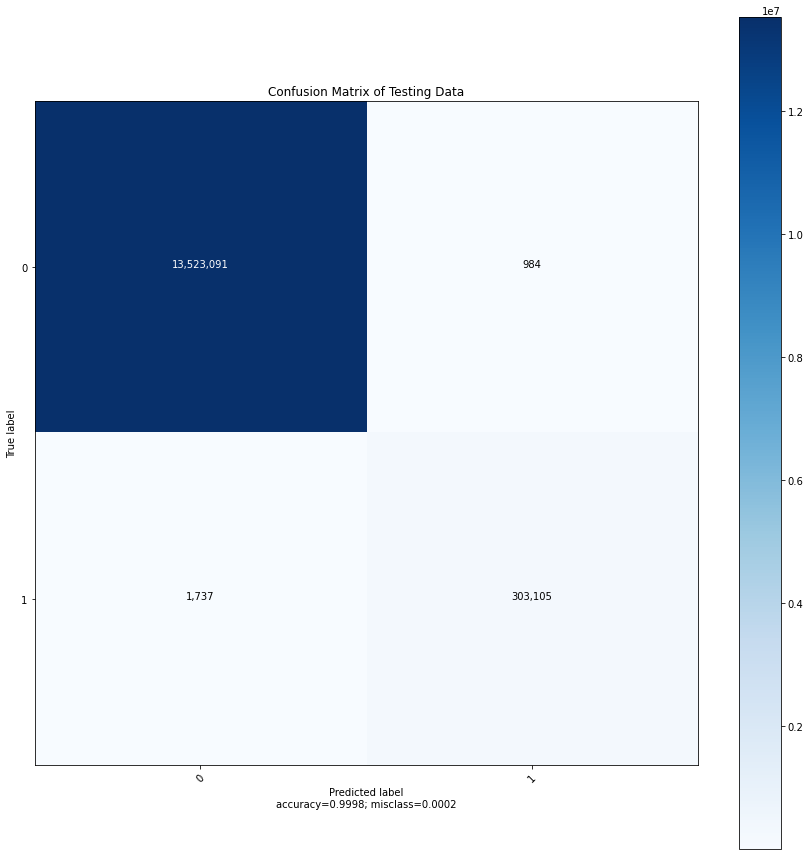

In [ ]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(test_label, prediction), 
                      normalize    = False,
                      target_names = np.unique(test_label),
                      title        = "Confusion Matrix of Testing Data")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_label, prediction,digits=4))

              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999  13524075
           1     0.9968    0.9943    0.9955    304842

    accuracy                         0.9998  13828917
   macro avg     0.9983    0.9971    0.9977  13828917
weighted avg     0.9998    0.9998    0.9998  13828917



In [ ]:
#model.eval()